In [3]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode
from scipy import interpolate
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [449]:
# parameters
δ = 0.01
η = 0.032
ξₐ = 1/4000
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*μ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
numy_bar = 100
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

In [162]:
# def func
def solve_smooth(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξ = args
    dy = y_grid[1] - y_grid[0]
    n_y = len(y_grid)
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid-ȳ)*(y_grid>ȳ)
    ϕ = - δ*η*y_grid**2
    ems = δ*η
    ems_old = ems
    πo = np.ones((len(θ_list), n_y))/len(θ_list)
    lhs_error = 1
    episode = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy)
        dϕdyy = derivative_1d(ϕ, 2, dy)
        temp = dϕdy + (η-1)*dΛ
        # update belief
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        π = πo*np.exp(weight)
        π[π <= 1e-15] = 1e-15
        π = π/np.sum(π, axis=0)
        # update control
        a = dϕdyy*σy**2 - 1/ξ*temp**2*σy**2
        b = (θ_list@π)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        # solve for ode
        A = - δ*np.ones(y_grid.shape)
        B = (θ_list@π)*ems
#         C = np.zeros(y_grid.shape)
        C = ems**2*σy**2/2
        D = δ*η*np.log(ems) + (θ_list@π)*(η-1)*dΛ*ems + ξₐ*np.sum(π*(np.log(π) - np.log(πo)), axis=0)\
        - 1/(2*ξ)*temp**2*ems**2*σy**2
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    h = - temp*ems*σy/ξ
    return ϕ, ems, π, h

In [163]:
# no ambguity
def solve_base(y_grid, args, tol=1e-8, ϵ=0.3):
    δ, η, θ, σy, γ1, γ2, γ3, ȳ = args
    hy = y_grid[1] - y_grid[0]
    # initialize the while loop
    episode = 0
    lhs_error = 1
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ϕ =  - δ*η*y_grid**2
    ems = - δ*η/((η-1)*dΛ*θ)
    ems_old = ems
    h_star = 0
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, hy)
        dϕdyy = derivative_1d(ϕ, 2, hy)
        temp = dϕdy + (η-1)*dΛ
        a = dϕdyy*σy**2  
        b = temp*θ
        c = δ*η
        Δ = b**2 - 4*a*c
        ems_new = (-b - np.sqrt(Δ))/(2*a)
        ems_new[ems_new <= 1e-15] = 1e-15    
        ems = ems_new*1 + ems_old*0
        # coefficients
        A = -δ*np.ones(y_grid.shape)
        B = ems*θ
        C = σy**2*ems**2/2
        D = δ*η*np.log(ems) + (η-1)*dΛ*ems*θ

        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, 0))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        ems_old = ems
        episode += 1
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    return ϕ, ems

In [164]:
# intensity
def get_intensity(y_grid, ς, ȳ=2):
    temp = 1/(np.sqrt(np.pi*2)*ς)*np.exp(-(y_grid - ȳ)**2/(2*ς**2))
#     temp *= v_bar - v_new
    return temp

In [165]:
# solve for ϕⱼ
ϕ_list = list()
ems_list = list()
π_list = list()
h_list = list()
ξₐ = 1/15_000
ξ = 0.002
for γ3 in γ3_list:
    args = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξ)
    ϕ, ems, π ,h = solve_smooth(y_grid, args)
    ϕ_list.append(ϕ)
    ems_list.append(ems)
    π_list.append(π)
    h_list.append(h)

episode: 1,	 ode error: 0.0017016403904338965,	 ft error: 0.001443636112991214
episode: 2,	 ode error: 0.0014064108280398325,	 ft error: 0.0012758068019328393
episode: 3,	 ode error: 0.0013052304174657305,	 ft error: 0.0012121582420587793
episode: 4,	 ode error: 0.0012389520791442356,	 ft error: 0.0011688399123368945
episode: 5,	 ode error: 0.0011879869562060328,	 ft error: 0.001133781799233532
episode: 6,	 ode error: 0.0011462560349501869,	 ft error: 0.0011034808505053229
episode: 7,	 ode error: 0.0011111238608528485,	 ft error: 0.0010766138661258997
episode: 8,	 ode error: 0.0010810300266519937,	 ft error: 0.0010525054069118397
episode: 9,	 ode error: 0.001054888233724831,	 ft error: 0.0010307655225830345
episode: 10,	 ode error: 0.0010318379671073372,	 ft error: 0.0010109909235031798
episode: 11,	 ode error: 0.001011258927662908,	 ft error: 0.0009929456392228624
episode: 12,	 ode error: 0.0009926451076851877,	 ft error: 0.0009762950689647833
episode: 13,	 ode error: 0.00097563677435

episode: 115,	 ode error: 0.0004613797057968832,	 ft error: 0.00046027763015246464
episode: 116,	 ode error: 0.00045898769779469226,	 ft error: 0.00045789799844650947
episode: 117,	 ode error: 0.00045661489787658476,	 ft error: 0.0004555373588536448
episode: 118,	 ode error: 0.00045426104676540304,	 ft error: 0.0004531954537697359
episode: 119,	 ode error: 0.00045192588652356175,	 ft error: 0.0004508720277035412
episode: 120,	 ode error: 0.00044960916136886663,	 ft error: 0.0004485668279017793
episode: 121,	 ode error: 0.0004473106183627062,	 ft error: 0.0004462796048991177
episode: 122,	 ode error: 0.0004450300079791251,	 ft error: 0.00044401011297489035
episode: 123,	 ode error: 0.0004427670845535916,	 ft error: 0.0004417581105063453
episode: 124,	 ode error: 0.00044052160661586434,	 ft error: 0.0004395233602199483
episode: 125,	 ode error: 0.00043829333711835924,	 ft error: 0.00043730562935089673
episode: 126,	 ode error: 0.00043608204357431404,	 ft error: 0.00043510468972748445
epi

episode: 279,	 ode error: 0.00022001962999964025,	 ft error: 0.00021969704024522863
episode: 280,	 ode error: 0.00021911727365283575,	 ft error: 0.00021879637847892672
episode: 281,	 ode error: 0.00021821929169231133,	 ft error: 0.0002179000767438035
episode: 282,	 ode error: 0.00021732565679419974,	 ft error: 0.0002170081078747832
episode: 283,	 ode error: 0.00021643634187432537,	 ft error: 0.00021612044494423907
episode: 284,	 ode error: 0.00021555132008527276,	 ft error: 0.00021523706125928707
episode: 285,	 ode error: 0.00021467056481363795,	 ft error: 0.0002143579303584553
episode: 286,	 ode error: 0.0002137940496766891,	 ft error: 0.00021348302600900093
episode: 287,	 ode error: 0.0002129217485198672,	 ft error: 0.00021261232220422718
episode: 288,	 ode error: 0.00021205363541400074,	 ft error: 0.00021174579316052267
episode: 289,	 ode error: 0.000211189684652416,	 ft error: 0.00021088341331481725
episode: 290,	 ode error: 0.00021032987074821755,	 ft error: 0.0002100251573218757


episode: 449,	 ode error: 0.00011322489551598004,	 ft error: 0.00011306372934394293
episode: 450,	 ode error: 0.00011280151234949274,	 ft error: 0.00011264083877769726
episode: 451,	 ode error: 0.00011237988450792764,	 ft error: 0.00011221970036295419
episode: 452,	 ode error: 0.00011196000364644537,	 ft error: 0.000111800305778569
episode: 453,	 ode error: 0.00011154186146874903,	 ft error: 0.00011138264675166858
episode: 454,	 ode error: 0.00011112544972663528,	 ft error: 0.00011096671505732755
episode: 455,	 ode error: 0.0001107107602197529,	 ft error: 0.00011055250251838326
episode: 456,	 ode error: 0.00011029778479538978,	 ft error: 0.0001101400010049732
episode: 457,	 ode error: 0.00010988651534803889,	 ft error: 0.00010972920243462747
episode: 458,	 ode error: 0.00010947694381921935,	 ft error: 0.00010932009877122803
episode: 459,	 ode error: 0.00010906906219702482,	 ft error: 0.00010891268202544806
episode: 460,	 ode error: 0.00010866286251592482,	 ft error: 0.00010850694425422

episode: 587,	 ode error: 6.842623072630071e-05,	 ft error: 6.83115754496431e-05
episode: 588,	 ode error: 6.818363448207537e-05,	 ft error: 6.806920641568015e-05
episode: 589,	 ode error: 6.794199813568887e-05,	 ft error: 6.782779598655624e-05
episode: 590,	 ode error: 6.77013175244439e-05,	 ft error: 6.758733999440159e-05
episode: 591,	 ode error: 6.746158848956112e-05,	 ft error: 6.734783427525537e-05
episode: 592,	 ode error: 6.722280687612649e-05,	 ft error: 6.710927466892688e-05
episode: 593,	 ode error: 6.6984968533133e-05,	 ft error: 6.687165701915743e-05
episode: 594,	 ode error: 6.674806931295625e-05,	 ft error: 6.663497717267208e-05
episode: 595,	 ode error: 6.651210507157071e-05,	 ft error: 6.639923097998916e-05
episode: 596,	 ode error: 6.627707166844841e-05,	 ft error: 6.616441429498077e-05
episode: 597,	 ode error: 6.604296496643357e-05,	 ft error: 6.593052297503474e-05
episode: 598,	 ode error: 6.5809780831632e-05,	 ft error: 6.569755288052259e-05
episode: 599,	 ode err

episode: 727,	 ode error: 4.207224123224326e-05,	 ft error: 4.1977118340844985e-05
episode: 728,	 ode error: 4.1928224210889434e-05,	 ft error: 4.1833177406881236e-05
episode: 729,	 ode error: 4.178471082410455e-05,	 ft error: 4.1689739679583636e-05
episode: 730,	 ode error: 4.16416991272121e-05,	 ft error: 4.154680322094225e-05
episode: 731,	 ode error: 4.149918718886799e-05,	 ft error: 4.1404366105668444e-05
episode: 732,	 ode error: 4.1357173090609666e-05,	 ft error: 4.1262426421773135e-05
episode: 733,	 ode error: 4.1215654926862895e-05,	 ft error: 4.112098226966473e-05
episode: 734,	 ode error: 4.1074630804628035e-05,	 ft error: 4.0980031762218504e-05
episode: 735,	 ode error: 4.093409884331424e-05,	 ft error: 4.083957302466098e-05
episode: 736,	 ode error: 4.079405717447428e-05,	 ft error: 4.069960419408418e-05
episode: 737,	 ode error: 4.065450394167755e-05,	 ft error: 4.056012341958441e-05
episode: 738,	 ode error: 4.051543730024753e-05,	 ft error: 4.042112886182281e-05
episode

episode: 901,	 ode error: 2.3232947917226684e-05,	 ft error: 2.3147140828609174e-05
episode: 902,	 ode error: 2.3154149973152334e-05,	 ft error: 2.3068380250757896e-05
episode: 903,	 ode error: 2.3075623439035536e-05,	 ft error: 2.298989094047521e-05
episode: 904,	 ode error: 2.2997367369493194e-05,	 ft error: 2.2911671952822548e-05
episode: 905,	 ode error: 2.291938082225279e-05,	 ft error: 2.2833722346099483e-05
episode: 906,	 ode error: 2.284166285855798e-05,	 ft error: 2.2756041182075047e-05
episode: 907,	 ode error: 2.276421254289191e-05,	 ft error: 2.267862752580267e-05
episode: 908,	 ode error: 2.268702894300356e-05,	 ft error: 2.260148044548142e-05
episode: 909,	 ode error: 2.2610111129968348e-05,	 ft error: 2.2524599012733553e-05
episode: 910,	 ode error: 2.2533458178004796e-05,	 ft error: 2.2447982302373215e-05
episode: 911,	 ode error: 2.2457069164720424e-05,	 ft error: 2.2371629392429575e-05
episode: 912,	 ode error: 2.238094317085805e-05,	 ft error: 2.2295539364239336e-05


episode: 1074,	 ode error: 1.2943945655831271e-05,	 ft error: 1.286287467585264e-05
episode: 1075,	 ode error: 1.2900476653927959e-05,	 ft error: 1.2819424923769345e-05
episode: 1076,	 ode error: 1.2857156326647932e-05,	 ft error: 1.2776123772493635e-05
episode: 1077,	 ode error: 1.2813984159399348e-05,	 ft error: 1.2732970707575916e-05
episode: 1078,	 ode error: 1.2770959639240198e-05,	 ft error: 1.2689965216532614e-05
episode: 1079,	 ode error: 1.2728082255218198e-05,	 ft error: 1.26471067884761e-05
episode: 1080,	 ode error: 1.2685351498036208e-05,	 ft error: 1.2604394914623545e-05
episode: 1081,	 ode error: 1.2642766860283491e-05,	 ft error: 1.2561829087579895e-05
episode: 1082,	 ode error: 1.2600327836180601e-05,	 ft error: 1.2519408802054896e-05
episode: 1083,	 ode error: 1.2558033921753397e-05,	 ft error: 1.2477133554261721e-05
episode: 1084,	 ode error: 1.2515884614919888e-05,	 ft error: 1.2435002842425824e-05
episode: 1085,	 ode error: 1.2473879415210508e-05,	 ft error: 1.2393

episode: 1200,	 ode error: 8.486729388468609e-06,	 ft error: 8.407583980106955e-06
episode: 1201,	 ode error: 8.458468395716127e-06,	 ft error: 8.379334835555604e-06
episode: 1202,	 ode error: 8.430303555247804e-06,	 ft error: 8.351181797622287e-06
episode: 1203,	 ode error: 8.402234535963152e-06,	 ft error: 8.323124535391154e-06
episode: 1204,	 ode error: 8.374261007846532e-06,	 ft error: 8.295162719102838e-06
episode: 1205,	 ode error: 8.346382642035791e-06,	 ft error: 8.267296019946285e-06
episode: 1206,	 ode error: 8.318599110797645e-06,	 ft error: 8.23952411049822e-06
episode: 1207,	 ode error: 8.29091008758341e-06,	 ft error: 8.211846664237429e-06
episode: 1208,	 ode error: 8.263315246931748e-06,	 ft error: 8.184263356007342e-06
episode: 1209,	 ode error: 8.235814264493497e-06,	 ft error: 8.156773861553446e-06
episode: 1210,	 ode error: 8.208406817202104e-06,	 ft error: 8.12937785796275e-06
episode: 1211,	 ode error: 8.181092582952706e-06,	 ft error: 8.102075023386224e-06
episode

episode: 1325,	 ode error: 5.604351876557171e-06,	 ft error: 5.526383435293844e-06
episode: 1326,	 ode error: 5.585873828689862e-06,	 ft error: 5.507912696096444e-06
episode: 1327,	 ode error: 5.567458317919257e-06,	 ft error: 5.4895044655778324e-06
episode: 1328,	 ode error: 5.549105129903898e-06,	 ft error: 5.471158529858171e-06
episode: 1329,	 ode error: 5.530814051149958e-06,	 ft error: 5.452874675265784e-06
episode: 1330,	 ode error: 5.512584868835489e-06,	 ft error: 5.434652689285484e-06
episode: 1331,	 ode error: 5.494417370871139e-06,	 ft error: 5.416492359749022e-06
episode: 1332,	 ode error: 5.4763113459744195e-06,	 ft error: 5.398393475621507e-06
episode: 1333,	 ode error: 5.4582665834989426e-06,	 ft error: 5.3803558263306374e-06
episode: 1334,	 ode error: 5.4402828736318555e-06,	 ft error: 5.36237920215991e-06
episode: 1335,	 ode error: 5.422360007184481e-06,	 ft error: 5.344463393971063e-06
episode: 1336,	 ode error: 5.404497775734454e-06,	 ft error: 5.326608193597279e-06


episode: 1451,	 ode error: 3.705691816847088e-06,	 ft error: 3.6284533805793404e-06
episode: 1452,	 ode error: 3.693623849400341e-06,	 ft error: 3.616389897103297e-06
episode: 1453,	 ode error: 3.6815965079248225e-06,	 ft error: 3.6043670221623065e-06
episode: 1454,	 ode error: 3.6696096538259932e-06,	 ft error: 3.592384617302306e-06
episode: 1455,	 ode error: 3.65766314915604e-06,	 ft error: 3.5804425446706034e-06
episode: 1456,	 ode error: 3.6457568564654498e-06,	 ft error: 3.568540666784581e-06
episode: 1457,	 ode error: 3.633890638619669e-06,	 ft error: 3.556678846601084e-06
episode: 1458,	 ode error: 3.622064359042835e-06,	 ft error: 3.5448569476783285e-06
episode: 1459,	 ode error: 3.610277881703353e-06,	 ft error: 3.533074834037124e-06
episode: 1460,	 ode error: 3.598531070930777e-06,	 ft error: 3.521332369998964e-06
episode: 1461,	 ode error: 3.586823791519025e-06,	 ft error: 3.509629420556104e-06
episode: 1462,	 ode error: 3.5751559088755642e-06,	 ft error: 3.4979658509783538e

episode: 1577,	 ode error: 2.464386075483305e-06,	 ft error: 2.3875951724964635e-06
episode: 1578,	 ode error: 2.4564866592492133e-06,	 ft error: 2.3796985024887585e-06
episode: 1579,	 ode error: 2.448613695066825e-06,	 ft error: 2.3718282739458125e-06
episode: 1580,	 ode error: 2.4407670931469614e-06,	 ft error: 2.3639843969858187e-06
episode: 1581,	 ode error: 2.4329467643030437e-06,	 ft error: 2.356166782490251e-06
episode: 1582,	 ode error: 2.42515261928897e-06,	 ft error: 2.3483753412249326e-06
episode: 1583,	 ode error: 2.4173845693322175e-06,	 ft error: 2.340609984557059e-06
episode: 1584,	 ode error: 2.409642526027592e-06,	 ft error: 2.332870624038863e-06
episode: 1585,	 ode error: 2.4019264012852936e-06,	 ft error: 2.32515717166204e-06
episode: 1586,	 ode error: 2.394236107180537e-06,	 ft error: 2.317469539533934e-06
episode: 1587,	 ode error: 2.3865715561005715e-06,	 ft error: 2.3098076400163148e-06
episode: 1588,	 ode error: 2.378932660896467e-06,	 ft error: 2.30217138607232

episode: 1703,	 ode error: 1.6510140531379681e-06,	 ft error: 1.5744970097384774e-06
episode: 1704,	 ode error: 1.6458316705723506e-06,	 ft error: 1.5693163058401924e-06
episode: 1705,	 ode error: 1.6406665503582206e-06,	 ft error: 1.5641528576989159e-06
episode: 1706,	 ode error: 1.6355186342509364e-06,	 ft error: 1.559006607212976e-06
episode: 1707,	 ode error: 1.6303878642463321e-06,	 ft error: 1.5538774963269608e-06
episode: 1708,	 ode error: 1.6252741826003423e-06,	 ft error: 1.5487654672167543e-06
episode: 1709,	 ode error: 1.620177531582237e-06,	 ft error: 1.5436704623357964e-06
episode: 1710,	 ode error: 1.6150978538726326e-06,	 ft error: 1.5385924242994342e-06
episode: 1711,	 ode error: 1.610035092067686e-06,	 ft error: 1.5335312958155343e-06
episode: 1712,	 ode error: 1.6049891892937294e-06,	 ft error: 1.5284870199389067e-06
episode: 1713,	 ode error: 1.5999600886288474e-06,	 ft error: 1.5234595398400108e-06
episode: 1714,	 ode error: 1.59494773346717e-06,	 ft error: 1.518448

episode: 1829,	 ode error: 1.116857759083387e-06,	 ft error: 1.0405079429315345e-06
episode: 1830,	 ode error: 1.1134503371804843e-06,	 ft error: 1.0371015447356118e-06
episode: 1831,	 ode error: 1.110054206021312e-06,	 ft error: 1.0337064332982537e-06
episode: 1832,	 ode error: 1.1066693277746956e-06,	 ft error: 1.0303225708024888e-06
episode: 1833,	 ode error: 1.1032956646338547e-06,	 ft error: 1.026949919385086e-06
episode: 1834,	 ode error: 1.0999331789704686e-06,	 ft error: 1.0235884414834992e-06
episode: 1835,	 ode error: 1.0965818333420491e-06,	 ft error: 1.0202380995814424e-06
episode: 1836,	 ode error: 1.093241590279328e-06,	 ft error: 1.0168988564401849e-06
episode: 1837,	 ode error: 1.0899124126274558e-06,	 ft error: 1.0135706747053479e-06
episode: 1838,	 ode error: 1.0865942632909973e-06,	 ft error: 1.0102535173926268e-06
episode: 1839,	 ode error: 1.0832871052408703e-06,	 ft error: 1.0069473474483281e-06
episode: 1840,	 ode error: 1.0799909016310063e-06,	 ft error: 1.00365

episode: 1955,	 ode error: 7.652948219426942e-07,	 ft error: 6.890468705796534e-07
episode: 1956,	 ode error: 7.630495467123065e-07,	 ft error: 6.868022180371118e-07
episode: 1957,	 ode error: 7.60811673025056e-07,	 ft error: 6.845649645759178e-07
episode: 1958,	 ode error: 7.585811760973818e-07,	 ft error: 6.823350854242202e-07
episode: 1959,	 ode error: 7.563580313139917e-07,	 ft error: 6.801125559720752e-07
episode: 1960,	 ode error: 7.541422141905648e-07,	 ft error: 6.778973517945763e-07
episode: 1961,	 ode error: 7.519337003053387e-07,	 ft error: 6.756894483742986e-07
episode: 1962,	 ode error: 7.497324652555246e-07,	 ft error: 6.734888213788537e-07
episode: 1963,	 ode error: 7.475384846875564e-07,	 ft error: 6.712954465221133e-07
episode: 1964,	 ode error: 7.453517344824896e-07,	 ft error: 6.691092995642078e-07
episode: 1965,	 ode error: 7.431721904983942e-07,	 ft error: 6.669303564965645e-07
episode: 1966,	 ode error: 7.409998287134702e-07,	 ft error: 6.647585932180918e-07
episo

episode: 2081,	 ode error: 5.334074001796078e-07,	 ft error: 4.5722132469006027e-07
episode: 2082,	 ode error: 5.319247370225372e-07,	 ft error: 4.5573903914575276e-07
episode: 2083,	 ode error: 5.304469366425313e-07,	 ft error: 4.5426161482860683e-07
episode: 2084,	 ode error: 5.289739828264308e-07,	 ft error: 4.527890356172589e-07
episode: 2085,	 ode error: 5.275058595312961e-07,	 ft error: 4.513212854597345e-07
episode: 2086,	 ode error: 5.260425506956479e-07,	 ft error: 4.498583482577997e-07
episode: 2087,	 ode error: 5.245840403919058e-07,	 ft error: 4.484002080982578e-07
episode: 2088,	 ode error: 5.231303126386044e-07,	 ft error: 4.4694684902165293e-07
episode: 2089,	 ode error: 5.21681351575709e-07,	 ft error: 4.454982551610476e-07
episode: 2090,	 ode error: 5.202371413901312e-07,	 ft error: 4.4405441076515267e-07
episode: 2091,	 ode error: 5.18797666302067e-07,	 ft error: 4.426152999901604e-07
episode: 2092,	 ode error: 5.173629106560709e-07,	 ft error: 4.411809072235595e-07
e

episode: 2207,	 ode error: 4.807620797157072e-07,	 ft error: 3.039838492961226e-07
episode: 2208,	 ode error: 4.817410886935429e-07,	 ft error: 3.030029546019497e-07
episode: 2209,	 ode error: 4.827169038346905e-07,	 ft error: 3.0202526084266434e-07
episode: 2210,	 ode error: 4.836895356213249e-07,	 ft error: 3.010507573554996e-07
episode: 2211,	 ode error: 4.846589945389822e-07,	 ft error: 3.000794337089848e-07
episode: 2212,	 ode error: 4.856252911020383e-07,	 ft error: 2.991112792866124e-07
episode: 2213,	 ode error: 4.86588435718617e-07,	 ft error: 2.9814628374943053e-07
episode: 2214,	 ode error: 4.875484387695207e-07,	 ft error: 2.971844365965796e-07
episode: 2215,	 ode error: 4.88505310714156e-07,	 ft error: 2.9622572739658925e-07
episode: 2216,	 ode error: 4.894590618059313e-07,	 ft error: 2.952701458336371e-07
episode: 2217,	 ode error: 4.904097023557177e-07,	 ft error: 2.9431768163816024e-07
episode: 2218,	 ode error: 4.913572426560632e-07,	 ft error: 2.933683244480771e-07
ep

episode: 2333,	 ode error: 5.820718695111584e-07,	 ft error: 2.024839529611115e-07
episode: 2334,	 ode error: 5.827211119551444e-07,	 ft error: 2.018335293341167e-07
episode: 2335,	 ode error: 5.833682465933385e-07,	 ft error: 2.0118521790642627e-07
episode: 2336,	 ode error: 5.840132803701641e-07,	 ft error: 2.005390117391463e-07
episode: 2337,	 ode error: 5.846562201390799e-07,	 ft error: 1.9989490380086425e-07
episode: 2338,	 ode error: 5.852970728301978e-07,	 ft error: 1.9925288733772345e-07
episode: 2339,	 ode error: 5.85935845259138e-07,	 ft error: 1.9861295541082996e-07
episode: 2340,	 ode error: 5.865725442817443e-07,	 ft error: 1.9797510126632706e-07
episode: 2341,	 ode error: 5.872071767013855e-07,	 ft error: 1.9733931798845047e-07
episode: 2342,	 ode error: 5.878397492858683e-07,	 ft error: 1.967055987308249e-07
episode: 2343,	 ode error: 5.884702688061438e-07,	 ft error: 1.9607393678585291e-07
episode: 2344,	 ode error: 5.890987420276335e-07,	 ft error: 1.954443254690667e-0

episode: 2457,	 ode error: 6.484512446615484e-07,	 ft error: 1.3598695398908678e-07
episode: 2458,	 ode error: 6.488854481285665e-07,	 ft error: 1.355520047134166e-07
episode: 2459,	 ode error: 6.493182484853177e-07,	 ft error: 1.3511846130391064e-07
episode: 2460,	 ode error: 6.497496502799217e-07,	 ft error: 1.3468631915776927e-07
episode: 2461,	 ode error: 6.501796581077695e-07,	 ft error: 1.3425557381097075e-07
episode: 2462,	 ode error: 6.506082765465795e-07,	 ft error: 1.338262205219376e-07
episode: 2463,	 ode error: 6.510355101123789e-07,	 ft error: 1.3339825487290735e-07
episode: 2464,	 ode error: 6.514613633310613e-07,	 ft error: 1.329716723073397e-07
episode: 2465,	 ode error: 6.51885840671166e-07,	 ft error: 1.3254646812991638e-07
episode: 2466,	 ode error: 6.523089467099777e-07,	 ft error: 1.321226381310418e-07
episode: 2467,	 ode error: 6.527306858685475e-07,	 ft error: 1.3170017761539773e-07
episode: 2468,	 ode error: 6.53151062652603e-07,	 ft error: 1.3127908211896244e-0

episode: 2615,	 ode error: 7.022669797496087e-07,	 ft error: 8.208184944236141e-08
episode: 2616,	 ode error: 7.02527732606849e-07,	 ft error: 8.182068111003046e-08
episode: 2617,	 ode error: 7.027876476541246e-07,	 ft error: 8.156035208317647e-08
episode: 2618,	 ode error: 7.03046727636744e-07,	 ft error: 8.130085970189013e-08
episode: 2619,	 ode error: 7.03304975192354e-07,	 ft error: 8.104220128313244e-08
episode: 2620,	 ode error: 7.035623930918503e-07,	 ft error: 8.078437395882729e-08
episode: 2621,	 ode error: 7.038189840032376e-07,	 ft error: 8.052737523097284e-08
episode: 2622,	 ode error: 7.04074750616096e-07,	 ft error: 8.027120225462259e-08
episode: 2623,	 ode error: 7.043296955740359e-07,	 ft error: 8.001585243925617e-08
episode: 2624,	 ode error: 7.045838215889721e-07,	 ft error: 7.976132300931601e-08
episode: 2625,	 ode error: 7.048371313257652e-07,	 ft error: 7.950761142054101e-08
episode: 2626,	 ode error: 7.050896274130632e-07,	 ft error: 7.925471492050326e-08
episode:

episode: 2746,	 ode error: 7.301915126874375e-07,	 ft error: 5.411409755481008e-08
episode: 2747,	 ode error: 7.303627308940424e-07,	 ft error: 5.394262335423061e-08
episode: 2748,	 ode error: 7.30533401434026e-07,	 ft error: 5.377169776573284e-08
episode: 2749,	 ode error: 7.307035260837452e-07,	 ft error: 5.360131896207469e-08
episode: 2750,	 ode error: 7.30873106664226e-07,	 ft error: 5.343148520853269e-08
episode: 2751,	 ode error: 7.310421448734374e-07,	 ft error: 5.326219479351302e-08
episode: 2752,	 ode error: 7.312106425080107e-07,	 ft error: 5.309344586664396e-08
episode: 2753,	 ode error: 7.31378601252471e-07,	 ft error: 5.292523669320204e-08
episode: 2754,	 ode error: 7.315460228828497e-07,	 ft error: 5.275756560785272e-08
episode: 2755,	 ode error: 7.317129091524103e-07,	 ft error: 5.2590430783353945e-08
episode: 2756,	 ode error: 7.318792617930572e-07,	 ft error: 5.242383060063046e-08
episode: 2757,	 ode error: 7.320450824960375e-07,	 ft error: 5.225776311679198e-08
episod

episode: 2870,	 ode error: 7.477449532895374e-07,	 ft error: 3.65351398671591e-08
episode: 2871,	 ode error: 7.478601342758139e-07,	 ft error: 3.641979680798121e-08
episode: 2872,	 ode error: 7.479749483906267e-07,	 ft error: 3.630482139453199e-08
episode: 2873,	 ode error: 7.480893967602448e-07,	 ft error: 3.619021221590302e-08
episode: 2874,	 ode error: 7.482034806153464e-07,	 ft error: 3.607596813874163e-08
episode: 2875,	 ode error: 7.483172011138592e-07,	 ft error: 3.596208807595443e-08
episode: 2876,	 ode error: 7.484305594076396e-07,	 ft error: 3.584857075541089e-08
episode: 2877,	 ode error: 7.485435566802028e-07,	 ft error: 3.573541504375832e-08
episode: 2878,	 ode error: 7.486561940977165e-07,	 ft error: 3.562261980764407e-08
episode: 2879,	 ode error: 7.487684727898111e-07,	 ft error: 3.551018379806722e-08
episode: 2880,	 ode error: 7.488803939302438e-07,	 ft error: 3.539810595106404e-08
episode: 2881,	 ode error: 7.489919586497291e-07,	 ft error: 3.528638513328186e-08
episo

episode: 2995,	 ode error: 7.596398428089688e-07,	 ft error: 2.4623996314199204e-08
episode: 2996,	 ode error: 7.597172045475118e-07,	 ft error: 2.4546532445546276e-08
episode: 2997,	 ode error: 7.59794320827345e-07,	 ft error: 2.4469314283126486e-08
episode: 2998,	 ode error: 7.598711924675832e-07,	 ft error: 2.4392341248698678e-08
episode: 2999,	 ode error: 7.599478202214216e-07,	 ft error: 2.431561241707699e-08
episode: 3000,	 ode error: 7.600242048613542e-07,	 ft error: 2.4239127117501685e-08
episode: 3001,	 ode error: 7.601003471897991e-07,	 ft error: 2.416288440165726e-08
episode: 3002,	 ode error: 7.601762479861893e-07,	 ft error: 2.4086883621913618e-08
episode: 3003,	 ode error: 7.60251908027464e-07,	 ft error: 2.401112406125172e-08
episode: 3004,	 ode error: 7.603273280560848e-07,	 ft error: 2.393560472509678e-08
episode: 3005,	 ode error: 7.604025088562552e-07,	 ft error: 2.3860325058337278e-08
episode: 3006,	 ode error: 7.604774511945061e-07,	 ft error: 2.3785284228305947e-0

episode: 3119,	 ode error: 7.675826563777232e-07,	 ft error: 1.667098910307363e-08
episode: 3120,	 ode error: 7.676348620627022e-07,	 ft error: 1.6618718577203023e-08
episode: 3121,	 ode error: 7.676869027621429e-07,	 ft error: 1.6566613405174145e-08
episode: 3122,	 ode error: 7.677387789442039e-07,	 ft error: 1.65146729393569e-08
episode: 3123,	 ode error: 7.67790491187849e-07,	 ft error: 1.646289662463977e-08
episode: 3124,	 ode error: 7.678420400017861e-07,	 ft error: 1.6411283998429838e-08
episode: 3125,	 ode error: 7.678934258832301e-07,	 ft error: 1.6359834528745232e-08
episode: 3126,	 ode error: 7.67944649364416e-07,	 ft error: 1.6308547660474442e-08
episode: 3127,	 ode error: 7.679957109716154e-07,	 ft error: 1.6257422954154187e-08
episode: 3128,	 ode error: 7.680466112395569e-07,	 ft error: 1.620645985467295e-08
episode: 3129,	 ode error: 7.680973506294601e-07,	 ft error: 1.6155657760659935e-08
episode: 3130,	 ode error: 7.681479296937259e-07,	 ft error: 1.61050162557815e-08
e

episode: 3243,	 ode error: 7.729462930895813e-07,	 ft error: 1.1300889599108466e-08
episode: 3244,	 ode error: 7.729815737434137e-07,	 ft error: 1.1265567853580016e-08
episode: 3245,	 ode error: 7.730167432659814e-07,	 ft error: 1.1230357407909786e-08
episode: 3246,	 ode error: 7.730518020495486e-07,	 ft error: 1.1195257868893787e-08
episode: 3247,	 ode error: 7.730867504035467e-07,	 ft error: 1.1160268889587321e-08
episode: 3248,	 ode error: 7.731215886835939e-07,	 ft error: 1.1125390099916052e-08
episode: 3249,	 ode error: 7.731563172576686e-07,	 ft error: 1.1090621199194572e-08
episode: 3250,	 ode error: 7.731909364735827e-07,	 ft error: 1.1055961747959605e-08
episode: 3251,	 ode error: 7.732254466822925e-07,	 ft error: 1.1021411538044331e-08
episode: 3252,	 ode error: 7.732598482302006e-07,	 ft error: 1.098697012998547e-08
episode: 3253,	 ode error: 7.732941414216425e-07,	 ft error: 1.0952637153708682e-08
episode: 3254,	 ode error: 7.733283266615678e-07,	 ft error: 1.09184123085285

episode: 74,	 ode error: 0.0005788549946043652,	 ft error: 0.0005768206221101978
episode: 75,	 ode error: 0.00057537471583201,	 ft error: 0.0005733723779364463
episode: 76,	 ode error: 0.0005719333305302183,	 ft error: 0.0005699621405296761
episode: 77,	 ode error: 0.0005685299561541633,	 ft error: 0.0005665890641303947
episode: 78,	 ode error: 0.0005651637427403365,	 ft error: 0.0005632523334319374
episode: 79,	 ode error: 0.0005618338712455706,	 ft error: 0.0005599511620779536
episode: 80,	 ode error: 0.0005585395519855897,	 ft error: 0.0005566847912429526
episode: 81,	 ode error: 0.000555280023164963,	 ft error: 0.0005534524882904134
episode: 82,	 ode error: 0.0005520548565466556,	 ft error: 0.0005501511937009106
episode: 83,	 ode error: 0.0005488637874530425,	 ft error: 0.0005469933985193775
episode: 84,	 ode error: 0.0005457063769998127,	 ft error: 0.000543869368079021
episode: 85,	 ode error: 0.0005425818468992271,	 ft error: 0.0005407768166791501
episode: 86,	 ode error: 0.00053

episode: 191,	 ode error: 0.00031084235766674364,	 ft error: 0.00030994219481605967
episode: 192,	 ode error: 0.0003091246442348083,	 ft error: 0.00030822854297329433
episode: 193,	 ode error: 0.00030741282013914265,	 ft error: 0.00030652078311351844
episode: 194,	 ode error: 0.00030570695741858516,	 ft error: 0.00030481898946032226
episode: 195,	 ode error: 0.0003040071273213281,	 ft error: 0.0003031232351520299
episode: 196,	 ode error: 0.0003023134001385732,	 ft error: 0.0003014335921009785
episode: 197,	 ode error: 0.00030062584505501544,	 ft error: 0.00029975013086732305
episode: 198,	 ode error: 0.0002989445300140554,	 ft error: 0.00029807292054461387
episode: 199,	 ode error: 0.00029726952159628945,	 ft error: 0.0002964020286562452
episode: 200,	 ode error: 0.0002956008849097935,	 ft error: 0.0002947375210629368
episode: 201,	 ode error: 0.00029393868349176827,	 ft error: 0.0002930794618804846
episode: 202,	 ode error: 0.00029228297922076615,	 ft error: 0.00029142791340563046
ep

episode: 311,	 ode error: 0.00015415811497798769,	 ft error: 0.00015372809869546034
episode: 312,	 ode error: 0.00015324846984908404,	 ft error: 0.00015282141938568103
episode: 313,	 ode error: 0.0001523442883385798,	 ft error: 0.0001519201834275739
episode: 314,	 ode error: 0.0001514455380232935,	 ft error: 0.00015102435851785853
episode: 315,	 ode error: 0.0001505521866182497,	 ft error: 0.00015013391248428395
episode: 316,	 ode error: 0.00014966420196762295,	 ft error: 0.00014924881327977685
episode: 317,	 ode error: 0.00014878155203968595,	 ft error: 0.00014836902897883328
episode: 318,	 ode error: 0.00014790420492432873,	 ft error: 0.00014749452777696367
episode: 319,	 ode error: 0.0001470321288323293,	 ft error: 0.0001466252779899757
episode: 320,	 ode error: 0.0001461652920957228,	 ft error: 0.0001457612480560792
episode: 321,	 ode error: 0.00014530366316876822,	 ft error: 0.00014490240653521522
episode: 322,	 ode error: 0.00014444721062932368,	 ft error: 0.00014404872211268757


episode: 431,	 ode error: 7.624098137391083e-05,	 ft error: 7.589561584915121e-05
episode: 432,	 ode error: 7.579746033104082e-05,	 ft error: 7.545406230445122e-05
episode: 433,	 ode error: 7.535640478397376e-05,	 ft error: 7.501495256335977e-05
episode: 434,	 ode error: 7.491780243012937e-05,	 ft error: 7.457827483671928e-05
episode: 435,	 ode error: 7.448164097704102e-05,	 ft error: 7.414401732223445e-05
episode: 436,	 ode error: 7.40479081440342e-05,	 ft error: 7.371216820740989e-05
episode: 437,	 ode error: 7.361659166411265e-05,	 ft error: 7.328271567308883e-05
episode: 438,	 ode error: 7.318767928588433e-05,	 ft error: 7.28556478962981e-05
episode: 439,	 ode error: 7.276115877553901e-05,	 ft error: 7.243095305364822e-05
episode: 440,	 ode error: 7.233701791875492e-05,	 ft error: 7.200861932427083e-05
episode: 441,	 ode error: 7.191524452250671e-05,	 ft error: 7.1588634892548e-05
episode: 442,	 ode error: 7.149582641696088e-05,	 ft error: 7.117098795100345e-05
episode: 443,	 ode e

episode: 553,	 ode error: 3.6999927611943e-05,	 ft error: 3.680317915311093e-05
episode: 554,	 ode error: 3.677723991600502e-05,	 ft error: 3.658123550948541e-05
episode: 555,	 ode error: 3.6555806854166126e-05,	 ft error: 3.636054146644493e-05
episode: 556,	 ode error: 3.633562128425741e-05,	 ft error: 3.6141089925107825e-05
episode: 557,	 ode error: 3.6116676110181504e-05,	 ft error: 3.592287383194966e-05
episode: 558,	 ode error: 3.5898964281847975e-05,	 ft error: 3.570588617921959e-05
episode: 559,	 ode error: 3.5682478795009704e-05,	 ft error: 3.549012000447771e-05
episode: 560,	 ode error: 3.5467212691039115e-05,	 ft error: 3.5275568390780165e-05
episode: 561,	 ode error: 3.525315905675329e-05,	 ft error: 3.506222446593895e-05
episode: 562,	 ode error: 3.504031102423595e-05,	 ft error: 3.485008140273009e-05
episode: 563,	 ode error: 3.4828661770584714e-05,	 ft error: 3.4639132418708605e-05
episode: 564,	 ode error: 3.4618204517597776e-05,	 ft error: 3.442937077539898e-05
episode:

episode: 677,	 ode error: 2.3396936884766318e-05,	 ft error: 2.397855209087622e-05
episode: 678,	 ode error: 2.3333317368736436e-05,	 ft error: 2.478267401206704e-05
episode: 679,	 ode error: 2.3272804805516843e-05,	 ft error: 2.3853245981036074e-05
episode: 680,	 ode error: 2.3209488571674302e-05,	 ft error: 2.4656790586277216e-05
episode: 681,	 ode error: 2.314927546206332e-05,	 ft error: 2.3728574215879188e-05
episode: 682,	 ode error: 2.3086261256582085e-05,	 ft error: 2.4531499966372793e-05
episode: 683,	 ode error: 2.3026346251163422e-05,	 ft error: 2.36045215275954e-05
episode: 684,	 ode error: 2.2963632785282862e-05,	 ft error: 2.4406810887785124e-05
episode: 685,	 ode error: 2.2901374286622884e-05,	 ft error: 2.436117084388817e-05
episode: 686,	 ode error: 2.2841920301843474e-05,	 ft error: 2.341622500519336e-05
episode: 687,	 ode error: 2.2779647818589577e-05,	 ft error: 2.422296471806205e-05
episode: 688,	 ode error: 2.2717837728235366e-05,	 ft error: 2.4175453570349226e-05


episode: 846,	 ode error: 1.4640501868997812e-05,	 ft error: 1.6013697739329185e-05
episode: 847,	 ode error: 1.4598812940694333e-05,	 ft error: 1.5971719256139643e-05
episode: 848,	 ode error: 1.4557228467238702e-05,	 ft error: 1.5929846731270923e-05
episode: 849,	 ode error: 1.4515748204180435e-05,	 ft error: 1.5888079889341454e-05
episode: 850,	 ode error: 1.4474371907634731e-05,	 ft error: 1.5846418456183973e-05
episode: 851,	 ode error: 1.443309933426819e-05,	 ft error: 1.5804862159816968e-05
episode: 852,	 ode error: 1.4391930241298425e-05,	 ft error: 1.5763410730479377e-05
episode: 853,	 ode error: 1.4350864386491335e-05,	 ft error: 1.5722063899393145e-05
episode: 854,	 ode error: 1.4309901528153292e-05,	 ft error: 1.56808214003476e-05
episode: 855,	 ode error: 1.4269041425130899e-05,	 ft error: 1.5639682968253875e-05
episode: 856,	 ode error: 1.422828383680451e-05,	 ft error: 1.5598648340706123e-05
episode: 857,	 ode error: 1.4187628523088235e-05,	 ft error: 1.5557717255853625e

episode: 976,	 ode error: 1.0014927166166436e-05,	 ft error: 1.1359814864643492e-05
episode: 977,	 ode error: 9.984940477188387e-06,	 ft error: 1.1329670332610916e-05
episode: 978,	 ode error: 9.955030428508829e-06,	 ft error: 1.129960285264677e-05
episode: 979,	 ode error: 9.925196835673341e-06,	 ft error: 1.1269612220146202e-05
episode: 980,	 ode error: 9.895439514674383e-06,	 ft error: 1.1239698231452674e-05
episode: 981,	 ode error: 9.865758281947285e-06,	 ft error: 1.120986068378858e-05
episode: 982,	 ode error: 9.836152954373903e-06,	 ft error: 1.1180099374769511e-05
episode: 983,	 ode error: 9.806623349272624e-06,	 ft error: 1.1150414103306324e-05
episode: 984,	 ode error: 9.777169284402236e-06,	 ft error: 1.1120804668668383e-05
episode: 985,	 ode error: 9.747790577962036e-06,	 ft error: 1.1091270871501266e-05
episode: 986,	 ode error: 9.718487048581781e-06,	 ft error: 1.1061812513190699e-05
episode: 987,	 ode error: 9.689258515326992e-06,	 ft error: 1.1032429396163243e-05
episo

episode: 1125,	 ode error: 6.299422963636583e-06,	 ft error: 7.630022851636461e-06
episode: 1126,	 ode error: 6.279010148130639e-06,	 ft error: 7.609628003904523e-06
episode: 1127,	 ode error: 6.258650223178014e-06,	 ft error: 7.589286821427696e-06
episode: 1128,	 ode error: 6.238343056040298e-06,	 ft error: 7.568999130895537e-06
episode: 1129,	 ode error: 6.218088514390642e-06,	 ft error: 7.548764759656805e-06
episode: 1130,	 ode error: 6.1978864663059816e-06,	 ft error: 7.528583536413336e-06
episode: 1131,	 ode error: 6.177736780267254e-06,	 ft error: 7.508455290468341e-06
episode: 1132,	 ode error: 6.1576393251573105e-06,	 ft error: 7.488379852651587e-06
episode: 1133,	 ode error: 6.1375939702511565e-06,	 ft error: 7.468357054683332e-06
episode: 1134,	 ode error: 6.1176005852272306e-06,	 ft error: 7.448386729058676e-06
episode: 1135,	 ode error: 6.097659040149811e-06,	 ft error: 7.428468710227176e-06
episode: 1136,	 ode error: 6.077769205477094e-06,	 ft error: 7.4086028333322784e-06

episode: 1254,	 ode error: 4.060185614366906e-06,	 ft error: 5.393255967517385e-06
episode: 1255,	 ode error: 4.045613774062492e-06,	 ft error: 5.378697548995745e-06
episode: 1256,	 ode error: 4.031080231937131e-06,	 ft error: 5.364177466440449e-06
episode: 1257,	 ode error: 4.016584891011028e-06,	 ft error: 5.3496956245920515e-06
episode: 1258,	 ode error: 4.00212765453643e-06,	 ft error: 5.335251928376139e-06
episode: 1259,	 ode error: 3.9877084259861415e-06,	 ft error: 5.320846283030553e-06
episode: 1260,	 ode error: 3.973327109060864e-06,	 ft error: 5.306478593642787e-06
episode: 1261,	 ode error: 3.958983607683833e-06,	 ft error: 5.292148765647283e-06
episode: 1262,	 ode error: 3.944677826007672e-06,	 ft error: 5.2778567045478715e-06
episode: 1263,	 ode error: 3.930409668405452e-06,	 ft error: 5.263602315987159e-06
episode: 1264,	 ode error: 3.91617903947508e-06,	 ft error: 5.249385505966264e-06
episode: 1265,	 ode error: 3.9019858440407355e-06,	 ft error: 5.2352061804284795e-06
e

episode: 1378,	 ode error: 2.517306933971596e-06,	 ft error: 3.852455075041099e-06
episode: 1379,	 ode error: 2.5068112892608345e-06,	 ft error: 3.84197898217753e-06
episode: 1380,	 ode error: 2.496343527764799e-06,	 ft error: 3.831530798990845e-06
episode: 1381,	 ode error: 2.4859035776327065e-06,	 ft error: 3.821110453316549e-06
episode: 1382,	 ode error: 2.4754913671926678e-06,	 ft error: 3.810717873256135e-06
episode: 1383,	 ode error: 2.465106824949112e-06,	 ft error: 3.8003529865410224e-06
episode: 1384,	 ode error: 2.454749879580103e-06,	 ft error: 3.790015721793124e-06
episode: 1385,	 ode error: 2.4444204599418393e-06,	 ft error: 3.779706007171757e-06
episode: 1386,	 ode error: 2.434118495065916e-06,	 ft error: 3.7694237713335283e-06
episode: 1387,	 ode error: 2.4238439141559915e-06,	 ft error: 3.759168943328247e-06
episode: 1388,	 ode error: 2.4135966465939124e-06,	 ft error: 3.748941452090075e-06
episode: 1389,	 ode error: 2.40337662193226e-06,	 ft error: 3.7387412264722197e-

episode: 1546,	 ode error: 2.15307363787186e-06,	 ft error: 2.4332457346000944e-06
episode: 1547,	 ode error: 2.156073016593705e-06,	 ft error: 2.426571858726856e-06
episode: 1548,	 ode error: 2.159066870693774e-06,	 ft error: 2.419915972745601e-06
episode: 1549,	 ode error: 2.162055204096825e-06,	 ft error: 2.4132780299344443e-06
episode: 1550,	 ode error: 2.1650380207660505e-06,	 ft error: 2.40665798220685e-06
episode: 1551,	 ode error: 2.168015324710993e-06,	 ft error: 2.4000557829912767e-06
episode: 1552,	 ode error: 2.1709871199800633e-06,	 ft error: 2.393471384895078e-06
episode: 1553,	 ode error: 2.173953410664227e-06,	 ft error: 2.386904741011331e-06
episode: 1554,	 ode error: 2.1769142008973307e-06,	 ft error: 2.380355804861012e-06
episode: 1555,	 ode error: 2.1798694948481313e-06,	 ft error: 2.3738245293059013e-06
episode: 1556,	 ode error: 2.1828192967305433e-06,	 ft error: 2.3673108679594934e-06
episode: 1557,	 ode error: 2.185763610796916e-06,	 ft error: 2.360814774562496e

episode: 1724,	 ode error: 2.604799470893313e-06,	 ft error: 1.4893804750384008e-06
episode: 1725,	 ode error: 2.6069033023233437e-06,	 ft error: 1.4852628057078951e-06
episode: 1726,	 ode error: 2.6090026906753615e-06,	 ft error: 1.4811563478373906e-06
episode: 1727,	 ode error: 2.611097642993374e-06,	 ft error: 1.4770610711964394e-06
episode: 1728,	 ode error: 2.6131881663253457e-06,	 ft error: 1.4729769460287516e-06
episode: 1729,	 ode error: 2.6152742677215722e-06,	 ft error: 1.4689039424623889e-06
episode: 1730,	 ode error: 2.6173559542335962e-06,	 ft error: 1.464842030879839e-06
episode: 1731,	 ode error: 2.619433232913177e-06,	 ft error: 1.4607911819642754e-06
episode: 1732,	 ode error: 2.6215061108111524e-06,	 ft error: 1.4567513657396762e-06
episode: 1733,	 ode error: 2.6235745949820463e-06,	 ft error: 1.4527225530511223e-06
episode: 1734,	 ode error: 2.6256386924802203e-06,	 ft error: 1.4487047140266756e-06
episode: 1735,	 ode error: 2.6276984103596563e-06,	 ft error: 1.44469

episode: 1901,	 ode error: 2.914316732698845e-06,	 ft error: 9.108102771877384e-07
episode: 1902,	 ode error: 2.9157420581604515e-06,	 ft error: 9.082743990251885e-07
episode: 1903,	 ode error: 2.91716414332194e-06,	 ft error: 9.057454866216268e-07
episode: 1904,	 ode error: 2.9185829944754237e-06,	 ft error: 9.032235212189099e-07
episode: 1905,	 ode error: 2.9199986179078113e-06,	 ft error: 9.007084840357653e-07
episode: 1906,	 ode error: 2.9214110198922966e-06,	 ft error: 8.982003565222163e-07
episode: 1907,	 ode error: 2.922820206701206e-06,	 ft error: 8.956991198276014e-07
episode: 1908,	 ode error: 2.9242261845941267e-06,	 ft error: 8.932047554135089e-07
episode: 1909,	 ode error: 2.925628959828152e-06,	 ft error: 8.907172446374438e-07
episode: 1910,	 ode error: 2.9270285386479066e-06,	 ft error: 8.882365691807264e-07
episode: 1911,	 ode error: 2.9284249272931912e-06,	 ft error: 8.857627105396393e-07
episode: 1912,	 ode error: 2.9298181319990357e-06,	 ft error: 8.832956501295119e-

episode: 2056,	 ode error: 3.100218933833811e-06,	 ft error: 5.905049418886144e-07
episode: 2057,	 ode error: 3.1012123278035424e-06,	 ft error: 5.888518178736221e-07
episode: 2058,	 ode error: 3.1022033618777916e-06,	 ft error: 5.87203266878833e-07
episode: 2059,	 ode error: 3.1031920410946835e-06,	 ft error: 5.855592762407658e-07
episode: 2060,	 ode error: 3.104178370484374e-06,	 ft error: 5.839198338857451e-07
episode: 2061,	 ode error: 3.105162355066936e-06,	 ft error: 5.82284926918993e-07
episode: 2062,	 ode error: 3.1061439998551245e-06,	 ft error: 5.806545434056121e-07
episode: 2063,	 ode error: 3.1071233098554593e-06,	 ft error: 5.790286709134174e-07
episode: 2064,	 ode error: 3.108100290060529e-06,	 ft error: 5.774072971374371e-07
episode: 2065,	 ode error: 3.109074945458639e-06,	 ft error: 5.757904097495696e-07
episode: 2066,	 ode error: 3.110047281032458e-06,	 ft error: 5.741779966530099e-07
episode: 2067,	 ode error: 3.11101730174877e-06,	 ft error: 5.725700456121752e-07
ep

episode: 2180,	 ode error: 3.206888113525927e-06,	 ft error: 4.1682159556087156e-07
episode: 2181,	 ode error: 3.20762474670356e-06,	 ft error: 4.156500800258275e-07
episode: 2182,	 ode error: 3.208359582295079e-06,	 ft error: 4.144818215266281e-07
episode: 2183,	 ode error: 3.2090926243377813e-06,	 ft error: 4.1331681141278575e-07
episode: 2184,	 ode error: 3.2098238768595868e-06,	 ft error: 4.121550406753031e-07
episode: 2185,	 ode error: 3.2105533438863006e-06,	 ft error: 4.1099650022422923e-07
episode: 2186,	 ode error: 3.211281029429525e-06,	 ft error: 4.0984118137438186e-07
episode: 2187,	 ode error: 3.21200693749658e-06,	 ft error: 4.086890752092824e-07
episode: 2188,	 ode error: 3.2127310720867614e-06,	 ft error: 4.075401730668782e-07
episode: 2189,	 ode error: 3.213453437191777e-06,	 ft error: 4.0639446597286655e-07
episode: 2190,	 ode error: 3.214174036794931e-06,	 ft error: 4.0525194523050034e-07
episode: 2191,	 ode error: 3.214892874872535e-06,	 ft error: 4.0411260207364374

episode: 2305,	 ode error: 3.2862465272596748e-06,	 ft error: 2.9300637301860055e-07
episode: 2306,	 ode error: 3.286787399030928e-06,	 ft error: 2.921798544774923e-07
episode: 2307,	 ode error: 3.2873269212543746e-06,	 ft error: 2.9135564461046926e-07
episode: 2308,	 ode error: 3.2878650970797306e-06,	 ft error: 2.9053373704531393e-07
episode: 2309,	 ode error: 3.2884019296512907e-06,	 ft error: 2.8971412515538253e-07
episode: 2310,	 ode error: 3.288937422102887e-06,	 ft error: 2.888968028575782e-07
episode: 2311,	 ode error: 3.289471577563039e-06,	 ft error: 2.880817638490722e-07
episode: 2312,	 ode error: 3.2900043991551707e-06,	 ft error: 2.8726900163043395e-07
episode: 2313,	 ode error: 3.290535889996038e-06,	 ft error: 2.864585100954368e-07
episode: 2314,	 ode error: 3.2910660531952412e-06,	 ft error: 2.8565028296438183e-07
episode: 2315,	 ode error: 3.2915948918569595e-06,	 ft error: 2.848443140732182e-07
episode: 2316,	 ode error: 3.2921224090762106e-06,	 ft error: 2.8404059688

episode: 2429,	 ode error: 3.343940757935093e-06,	 ft error: 2.063008951516676e-07
episode: 2430,	 ode error: 3.3443363761332333e-06,	 ft error: 2.057170357209574e-07
episode: 2431,	 ode error: 3.344730988752778e-06,	 ft error: 2.051348141236346e-07
episode: 2432,	 ode error: 3.3451245982089504e-06,	 ft error: 2.0455422537526044e-07
episode: 2433,	 ode error: 3.3455172069170812e-06,	 ft error: 2.0397526534719307e-07
episode: 2434,	 ode error: 3.3459088172843707e-06,	 ft error: 2.033979291706419e-07
episode: 2435,	 ode error: 3.346299431713519e-06,	 ft error: 2.0282221255505756e-07
episode: 2436,	 ode error: 3.346689052601318e-06,	 ft error: 2.022481109438997e-07
episode: 2437,	 ode error: 3.3470776823412525e-06,	 ft error: 2.0167561980375764e-07
episode: 2438,	 ode error: 3.347465323320735e-06,	 ft error: 2.0110473477469304e-07
episode: 2439,	 ode error: 3.3478519779173675e-06,	 ft error: 2.005354514967676e-07
episode: 2440,	 ode error: 3.3482376485115695e-06,	 ft error: 1.999677651705

episode: 2554,	 ode error: 3.3863192194422457e-06,	 ft error: 1.4467980390120427e-07
episode: 2555,	 ode error: 3.3866062937666272e-06,	 ft error: 1.4426909124518977e-07
episode: 2556,	 ode error: 3.386892626784145e-06,	 ft error: 1.4385953516401115e-07
episode: 2557,	 ode error: 3.3871782203237933e-06,	 ft error: 1.434511321419622e-07
episode: 2558,	 ode error: 3.3874630762091465e-06,	 ft error: 1.4304387927627227e-07
episode: 2559,	 ode error: 3.3877471962607424e-06,	 ft error: 1.426377729240221e-07
episode: 2560,	 ode error: 3.388030582294132e-06,	 ft error: 1.4223281024026518e-07
episode: 2561,	 ode error: 3.3883132361199326e-06,	 ft error: 1.4182898776711936e-07
episode: 2562,	 ode error: 3.3885951595463227e-06,	 ft error: 1.4142630265963815e-07
episode: 2563,	 ode error: 3.3888763543766013e-06,	 ft error: 1.410247512402078e-07
episode: 2564,	 ode error: 3.3891568224083757e-06,	 ft error: 1.4062433081422448e-07
episode: 2565,	 ode error: 3.3894365654399037e-06,	 ft error: 1.402250

episode: 2679,	 ode error: 3.4170007151403743e-06,	 ft error: 1.0135926293887895e-07
episode: 2680,	 ode error: 3.4172080451518234e-06,	 ft error: 1.0107072150276435e-07
episode: 2681,	 ode error: 3.417414832525235e-06,	 ft error: 1.0078299528260004e-07
episode: 2682,	 ode error: 3.4176210786267583e-06,	 ft error: 1.0049608211576411e-07
episode: 2683,	 ode error: 3.4178267848198316e-06,	 ft error: 1.0020997952738439e-07
episode: 2684,	 ode error: 3.4180319524622555e-06,	 ft error: 9.992468530857965e-08
episode: 2685,	 ode error: 3.418236582913457e-06,	 ft error: 9.964019733142242e-08
episode: 2686,	 ode error: 3.418440677526954e-06,	 ft error: 9.935651315573502e-08
episode: 2687,	 ode error: 3.4186442376524153e-06,	 ft error: 9.907363057263623e-08
episode: 2688,	 ode error: 3.41884726463577e-06,	 ft error: 9.879154740793927e-08
episode: 2689,	 ode error: 3.4190497598214826e-06,	 ft error: 9.851026145276295e-08
episode: 2690,	 ode error: 3.4192517245514704e-06,	 ft error: 9.822977029005

episode: 2803,	 ode error: 3.438966364271783e-06,	 ft error: 7.114495755254173e-08
episode: 2804,	 ode error: 3.4391158855378657e-06,	 ft error: 7.094190952276296e-08
episode: 2805,	 ode error: 3.4392650109456887e-06,	 ft error: 7.073943699327975e-08
episode: 2806,	 ode error: 3.439413741507789e-06,	 ft error: 7.05375382640631e-08
episode: 2807,	 ode error: 3.43956207823654e-06,	 ft error: 7.033621193576942e-08
episode: 2808,	 ode error: 3.4397100221402496e-06,	 ft error: 7.013545628524002e-08
episode: 2809,	 ode error: 3.439857574227118e-06,	 ft error: 6.993526949679771e-08
episode: 2810,	 ode error: 3.4400047355008447e-06,	 ft error: 6.973565028674708e-08
episode: 2811,	 ode error: 3.440151506960685e-06,	 ft error: 6.953659705914254e-08
episode: 2812,	 ode error: 3.440297889607249e-06,	 ft error: 6.93381078132697e-08
episode: 2813,	 ode error: 3.4404438844394124e-06,	 ft error: 6.914018149672962e-08
episode: 2814,	 ode error: 3.44058949245128e-06,	 ft error: 6.894281608567829e-08
epi

episode: 2929,	 ode error: 3.454995300931473e-06,	 ft error: 4.960868374657516e-08
episode: 2930,	 ode error: 3.455102178405575e-06,	 ft error: 4.946676036380697e-08
episode: 2931,	 ode error: 3.455208770037851e-06,	 ft error: 4.932524066275645e-08
episode: 2932,	 ode error: 3.4553150765713058e-06,	 ft error: 4.918412329033932e-08
episode: 2933,	 ode error: 3.4554210987446598e-06,	 ft error: 4.9043406974425e-08
episode: 2934,	 ode error: 3.4555268373002664e-06,	 ft error: 4.890309073200354e-08
episode: 2935,	 ode error: 3.4556322929741364e-06,	 ft error: 4.876317332563884e-08
episode: 2936,	 ode error: 3.455737466501684e-06,	 ft error: 4.8623653795450604e-08
episode: 2937,	 ode error: 3.455842358620438e-06,	 ft error: 4.8484530950262027e-08
episode: 2938,	 ode error: 3.455946970057518e-06,	 ft error: 4.834580352950739e-08
episode: 2939,	 ode error: 3.4560513015454656e-06,	 ft error: 4.820747051548224e-08
episode: 2940,	 ode error: 3.4561553538123768e-06,	 ft error: 4.8069530867352515e-

episode: 3055,	 ode error: 3.4664352022120877e-06,	 ft error: 3.456283613478828e-08
episode: 3056,	 ode error: 3.4665113535932955e-06,	 ft error: 3.4463737627610236e-08
episode: 3057,	 ode error: 3.4665872994949355e-06,	 ft error: 3.436492164906232e-08
episode: 3058,	 ode error: 3.4666630404578077e-06,	 ft error: 3.4266387204569724e-08
episode: 3059,	 ode error: 3.4667385770217906e-06,	 ft error: 3.4168133669632006e-08
episode: 3060,	 ode error: 3.4668139097249738e-06,	 ft error: 3.4070160257841195e-08
episode: 3061,	 ode error: 3.466889039104471e-06,	 ft error: 3.3972466055576245e-08
episode: 3062,	 ode error: 3.4669639656945226e-06,	 ft error: 3.38750504267719e-08
episode: 3063,	 ode error: 3.4670386900294238e-06,	 ft error: 3.3777912446242286e-08
episode: 3064,	 ode error: 3.467113212642927e-06,	 ft error: 3.368105153574626e-08
episode: 3065,	 ode error: 3.467187534065912e-06,	 ft error: 3.358446664288491e-08
episode: 3066,	 ode error: 3.4672616548289334e-06,	 ft error: 3.3488157050

episode: 3181,	 ode error: 3.4745752191381644e-06,	 ft error: 2.406165690305162e-08
episode: 3182,	 ode error: 3.4746293240818884e-06,	 ft error: 2.399252563983767e-08
episode: 3183,	 ode error: 3.474683281888915e-06,	 ft error: 2.392359206571104e-08
episode: 3184,	 ode error: 3.474737092952647e-06,	 ft error: 2.385485539426376e-08
episode: 3185,	 ode error: 3.474790757660958e-06,	 ft error: 2.378631512820843e-08
episode: 3186,	 ode error: 3.474844276405841e-06,	 ft error: 2.371797080495212e-08
episode: 3187,	 ode error: 3.4748976495732175e-06,	 ft error: 2.3649821626522037e-08
episode: 3188,	 ode error: 3.4749508775523707e-06,	 ft error: 2.3581867523529237e-08
episode: 3189,	 ode error: 3.475003960730144e-06,	 ft error: 2.3514107235407998e-08
episode: 3190,	 ode error: 3.4750568994911034e-06,	 ft error: 2.3446540935630665e-08
episode: 3191,	 ode error: 3.4751096942201953e-06,	 ft error: 2.3379167375196335e-08
episode: 3192,	 ode error: 3.475162345300902e-06,	 ft error: 2.3311986635058

episode: 3307,	 ode error: 3.480351667874658e-06,	 ft error: 1.6739025709514948e-08
episode: 3308,	 ode error: 3.480390011949752e-06,	 ft error: 1.6690841544523643e-08
episode: 3309,	 ode error: 3.4804282510232805e-06,	 ft error: 1.6642795347872795e-08
episode: 3310,	 ode error: 3.4804663853786545e-06,	 ft error: 1.6594886726358414e-08
episode: 3311,	 ode error: 3.480504415298959e-06,	 ft error: 1.6547115390859922e-08
episode: 3312,	 ode error: 3.480542341063647e-06,	 ft error: 1.6499480832525098e-08
episode: 3313,	 ode error: 3.480580162951738e-06,	 ft error: 1.645198266971478e-08
episode: 3314,	 ode error: 3.480617881243607e-06,	 ft error: 1.6404620671132502e-08
episode: 3315,	 ode error: 3.4806554962169174e-06,	 ft error: 1.6357394397314984e-08
episode: 3316,	 ode error: 3.4806930081493883e-06,	 ft error: 1.6310303246891422e-08
episode: 3317,	 ode error: 3.4807304173186835e-06,	 ft error: 1.626334708108394e-08
episode: 3318,	 ode error: 3.4807677239993774e-06,	 ft error: 1.621652531

episode: 3434,	 ode error: 3.4844681281133633e-06,	 ft error: 1.1603554043541447e-08
episode: 3435,	 ode error: 3.484495166337616e-06,	 ft error: 1.15700929971078e-08
episode: 3436,	 ode error: 3.4845221300610794e-06,	 ft error: 1.1536728250956715e-08
episode: 3437,	 ode error: 3.484549019481186e-06,	 ft error: 1.1503459064939511e-08
episode: 3438,	 ode error: 3.484575834803447e-06,	 ft error: 1.1470285334972779e-08
episode: 3439,	 ode error: 3.4846025762268673e-06,	 ft error: 1.1437206806630407e-08
episode: 3440,	 ode error: 3.4846292439520785e-06,	 ft error: 1.1404223479912398e-08
episode: 3441,	 ode error: 3.484655838177002e-06,	 ft error: 1.1371334568410774e-08
episode: 3442,	 ode error: 3.4846823591029195e-06,	 ft error: 1.1338540199338592e-08
episode: 3443,	 ode error: 3.484708806927644e-06,	 ft error: 1.1305839910102922e-08
episode: 3444,	 ode error: 3.4847351818501266e-06,	 ft error: 1.1273233596620358e-08
episode: 3445,	 ode error: 3.4847614840668247e-06,	 ft error: 1.12407207

episode: 95,	 ode error: 0.0007518785591762943,	 ft error: 0.0007521320413391801
episode: 96,	 ode error: 0.0007496352928586714,	 ft error: 0.0007498803871582606
episode: 97,	 ode error: 0.0007473987405329703,	 ft error: 0.0007476358887669593
episode: 98,	 ode error: 0.0007451688809614371,	 ft error: 0.0007453984914979062
episode: 99,	 ode error: 0.0007429456930592145,	 ft error: 0.0007431681441669054
episode: 100,	 ode error: 0.00074072915588545,	 ft error: 0.0007409447985700276
episode: 101,	 ode error: 0.0007385192486356017,	 ft error: 0.0007387284090820216
episode: 102,	 ode error: 0.0007363159506346635,	 ft error: 0.0007365189323460646
episode: 103,	 ode error: 0.000734119241331167,	 ft error: 0.0007343163270169077
episode: 104,	 ode error: 0.0007319291002917933,	 ft error: 0.0007321205535529979
episode: 105,	 ode error: 0.0007297455071965421,	 ft error: 0.0007299315740322045
episode: 106,	 ode error: 0.0007275684418343543,	 ft error: 0.0007277493519985042
episode: 107,	 ode error

episode: 263,	 ode error: 0.0004551863847087099,	 ft error: 0.00045502944850416005
episode: 264,	 ode error: 0.0004538291901014306,	 ft error: 0.00045367153124843684
episode: 265,	 ode error: 0.0004524760453815782,	 ft error: 0.0004523177030330237
episode: 266,	 ode error: 0.00045112693835859443,	 ft error: 0.00045096795024207603
episode: 267,	 ode error: 0.0004497818568823421,	 ft error: 0.0004496222593604558
episode: 268,	 ode error: 0.0004484407888428294,	 ft error: 0.00044828061696515026
episode: 269,	 ode error: 0.00044710372216993596,	 ft error: 0.00044694300972545714
episode: 270,	 ode error: 0.0004457706448331505,	 ft error: 0.0004456094243972253
episode: 271,	 ode error: 0.00044444154484130343,	 ft error: 0.00044427984782690244
episode: 272,	 ode error: 0.0004431164102423284,	 ft error: 0.0004429542669399702
episode: 273,	 ode error: 0.0004417952291230076,	 ft error: 0.0004416326687470967
episode: 274,	 ode error: 0.0004404779896087452,	 ft error: 0.0004403150403356713
episode

episode: 433,	 ode error: 0.0002739945151902296,	 ft error: 0.0002738691285017007
episode: 434,	 ode error: 0.00027317763761821657,	 ft error: 0.00027305256504216635
episode: 435,	 ode error: 0.00027236319552870604,	 ft error: 0.0002722384361446747
episode: 436,	 ode error: 0.00027155118166076345,	 ft error: 0.0002714267345436487
episode: 437,	 ode error: 0.00027074158877511613,	 ft error: 0.00027061745299682605
episode: 438,	 ode error: 0.0002699344096540984,	 ft error: 0.0002698105842810032
episode: 439,	 ode error: 0.0002691296371015755,	 ft error: 0.00026900612119800293
episode: 440,	 ode error: 0.00026832726394288606,	 ft error: 0.0002682040565687993
episode: 441,	 ode error: 0.00026752728302477467,	 ft error: 0.0002674043832370336
episode: 442,	 ode error: 0.0002667296872153284,	 ft error: 0.0002666070940673023
episode: 443,	 ode error: 0.00026593446940391234,	 ft error: 0.0002658121819467304
episode: 444,	 ode error: 0.0002651416225011064,	 ft error: 0.00026501963978196413
episo

episode: 599,	 ode error: 0.00016691239776556936,	 ft error: 0.00016682654200207242
episode: 600,	 ode error: 0.00016641478904811584,	 ft error: 0.00016632910345454333
episode: 601,	 ode error: 0.00016591866402655133,	 ft error: 0.00016583314793349366
episode: 602,	 ode error: 0.00016542401827769333,	 ft error: 0.00016533867101838537
episode: 603,	 ode error: 0.00016493084739154092,	 ft error: 0.00016484566830204939
episode: 604,	 ode error: 0.00016443914697123905,	 ft error: 0.00016435413538999172
episode: 605,	 ode error: 0.00016394891263303698,	 ft error: 0.00016386406790117974
episode: 606,	 ode error: 0.00016346014000624958,	 ft error: 0.0001633754614677648
episode: 607,	 ode error: 0.00016297282473322198,	 ft error: 0.0001628883117342032
episode: 608,	 ode error: 0.0001624869624692858,	 ft error: 0.00016240261435836642
episode: 609,	 ode error: 0.00016200254888272276,	 ft error: 0.00016191836501121734
episode: 610,	 ode error: 0.00016151957965472607,	 ft error: 0.0001614355593766

episode: 769,	 ode error: 0.00010047634862186147,	 ft error: 0.00010041163836937059
episode: 770,	 ode error: 0.00010017683574611565,	 ft error: 0.00010011221301620132
episode: 771,	 ode error: 9.987821597729092e-05,	 ft error: 9.981368043370428e-05
episode: 772,	 ode error: 9.95804866525988e-05,	 ft error: 9.951603796002721e-05
episode: 773,	 ode error: 9.928364511718637e-05,	 ft error: 9.921928294192214e-05
episode: 774,	 ode error: 9.898768872411651e-05,	 ft error: 9.892341273354255e-05
episode: 775,	 ode error: 9.869261483434245e-05,	 ft error: 9.86284246975074e-05
episode: 776,	 ode error: 9.839842081668096e-05,	 ft error: 9.83343162040684e-05
episode: 777,	 ode error: 9.810510404779601e-05,	 ft error: 9.804108463083254e-05
episode: 778,	 ode error: 9.781266191217044e-05,	 ft error: 9.774872736382594e-05
episode: 779,	 ode error: 9.752109180208388e-05,	 ft error: 9.745724179670753e-05
episode: 780,	 ode error: 9.723039111758755e-05,	 ft error: 9.716662533090781e-05
episode: 781,	 

episode: 937,	 ode error: 6.085097847133595e-05,	 ft error: 6.0797168648698184e-05
episode: 938,	 ode error: 6.0669626207452386e-05,	 ft error: 6.061586309470217e-05
episode: 939,	 ode error: 6.0488814741085396e-05,	 ft error: 6.043509817051559e-05
episode: 940,	 ode error: 6.0308542459709766e-05,	 ft error: 6.02548722640021e-05
episode: 941,	 ode error: 6.01288077556072e-05,	 ft error: 6.00751837682989e-05
episode: 942,	 ode error: 5.9949609025852e-05,	 ft error: 5.9896031081261666e-05
episode: 943,	 ode error: 5.977094467229786e-05,	 ft error: 5.971741260541823e-05
episode: 944,	 ode error: 5.9592813101565266e-05,	 ft error: 5.9539326747459764e-05
episode: 945,	 ode error: 5.941521272502092e-05,	 ft error: 5.936177192027622e-05
episode: 946,	 ode error: 5.923814195876991e-05,	 ft error: 5.918474654008817e-05
episode: 947,	 ode error: 5.906159922363947e-05,	 ft error: 5.9008249028667345e-05
episode: 948,	 ode error: 5.888558294516572e-05,	 ft error: 5.883227781176374e-05
episode: 949,

episode: 1106,	 ode error: 3.6748652014453355e-05,	 ft error: 3.670080391695215e-05
episode: 1107,	 ode error: 3.663917493029181e-05,	 ft error: 3.659135281455783e-05
episode: 1108,	 ode error: 3.653002432275508e-05,	 ft error: 3.648222810191208e-05
episode: 1109,	 ode error: 3.642119921830702e-05,	 ft error: 3.6373428805858143e-05
episode: 1110,	 ode error: 3.6312698646313694e-05,	 ft error: 3.6264953955829814e-05
episode: 1111,	 ode error: 3.6204521639034886e-05,	 ft error: 3.6156802584869085e-05
episode: 1112,	 ode error: 3.609666723161718e-05,	 ft error: 3.604897372809964e-05
episode: 1113,	 ode error: 3.5989134462083554e-05,	 ft error: 3.594146642383704e-05
episode: 1114,	 ode error: 3.588192237132513e-05,	 ft error: 3.5834279713449955e-05
episode: 1115,	 ode error: 3.5775030003090767e-05,	 ft error: 3.5727412641128886e-05
episode: 1116,	 ode error: 3.5668456403984035e-05,	 ft error: 3.562086425351607e-05
episode: 1117,	 ode error: 3.556220062344824e-05,	 ft error: 3.5514633600630

episode: 1274,	 ode error: 2.226518349770167e-05,	 ft error: 2.2220696620639524e-05
episode: 1275,	 ode error: 2.219889882244027e-05,	 ft error: 2.2154427013337807e-05
episode: 1276,	 ode error: 2.213281182339758e-05,	 ft error: 2.2088355034755036e-05
episode: 1277,	 ode error: 2.2066921911086156e-05,	 ft error: 2.202248009582538e-05
episode: 1278,	 ode error: 2.2001228497776047e-05,	 ft error: 2.1956801609055814e-05
episode: 1279,	 ode error: 2.1935730997491758e-05,	 ft error: 2.189131898820233e-05
episode: 1280,	 ode error: 2.1870428826001407e-05,	 ft error: 2.1826031649565168e-05
episode: 1281,	 ode error: 2.1805321400818678e-05,	 ft error: 2.1760939010554797e-05
episode: 1282,	 ode error: 2.1740408141193062e-05,	 ft error: 2.1696040490755873e-05
episode: 1283,	 ode error: 2.167568846810292e-05,	 ft error: 2.163133551155716e-05
episode: 1284,	 ode error: 2.1611161804257432e-05,	 ft error: 2.156682349550391e-05
episode: 1285,	 ode error: 2.1546827574085974e-05,	 ft error: 2.150250386

episode: 1444,	 ode error: 1.3892804530081305e-05,	 ft error: 1.3373346813468542e-05
episode: 1445,	 ode error: 1.3870508066815432e-05,	 ft error: 1.333346213263272e-05
episode: 1446,	 ode error: 1.3848272302942214e-05,	 ft error: 1.32936963995652e-05
episode: 1447,	 ode error: 1.382609707974606e-05,	 ft error: 1.3254049259595984e-05
episode: 1448,	 ode error: 1.380398223889833e-05,	 ft error: 1.3214520358934001e-05
episode: 1449,	 ode error: 1.378192762245917e-05,	 ft error: 1.317510934466711e-05
episode: 1450,	 ode error: 1.3759933072866164e-05,	 ft error: 1.3135815865733536e-05
episode: 1451,	 ode error: 1.3737998432936602e-05,	 ft error: 1.3096639571349064e-05
episode: 1452,	 ode error: 1.3716123545877225e-05,	 ft error: 1.3057580111932218e-05
episode: 1453,	 ode error: 1.3694308255267631e-05,	 ft error: 1.301863713947434e-05
episode: 1454,	 ode error: 1.3672552405065703e-05,	 ft error: 1.2979810306521882e-05
episode: 1455,	 ode error: 1.3650855839611438e-05,	 ft error: 1.294109926

episode: 1613,	 ode error: 1.087275520104021e-05,	 ft error: 8.072638296348819e-06
episode: 1614,	 ode error: 1.0858742958050913e-05,	 ft error: 8.048562034531267e-06
episode: 1615,	 ode error: 1.0844769461561877e-05,	 ft error: 8.024557576526611e-06
episode: 1616,	 ode error: 1.0830834607470774e-05,	 ft error: 8.000624708570658e-06
episode: 1617,	 ode error: 1.0816938291945123e-05,	 ft error: 7.976763216667923e-06
episode: 1618,	 ode error: 1.0803080411418919e-05,	 ft error: 7.952972888534509e-06
episode: 1619,	 ode error: 1.078926086258629e-05,	 ft error: 7.929253511701484e-06
episode: 1620,	 ode error: 1.0775479542405593e-05,	 ft error: 7.905604874532587e-06
episode: 1621,	 ode error: 1.0761736348103407e-05,	 ft error: 7.8820267661317e-06
episode: 1622,	 ode error: 1.0748031177167953e-05,	 ft error: 7.858518976157821e-06
episode: 1623,	 ode error: 1.0734363927347279e-05,	 ft error: 7.835081294732538e-06
episode: 1624,	 ode error: 1.0720734496652063e-05,	 ft error: 7.811713513041404e

episode: 1781,	 ode error: 8.989332529534065e-06,	 ft error: 4.887474696069205e-06
episode: 1782,	 ode error: 8.98055731014113e-06,	 ft error: 4.872897810768532e-06
episode: 1783,	 ode error: 8.971806637275301e-06,	 ft error: 4.858364399858614e-06
episode: 1784,	 ode error: 8.963080443730889e-06,	 ft error: 4.843874333582132e-06
episode: 1785,	 ode error: 8.95437866248522e-06,	 ft error: 4.829427482505588e-06
episode: 1786,	 ode error: 8.945701226694542e-06,	 ft error: 4.815023717843111e-06
episode: 1787,	 ode error: 8.9370480696886e-06,	 ft error: 4.800662911225162e-06
episode: 1788,	 ode error: 8.92841912496752e-06,	 ft error: 4.786344934559761e-06
episode: 1789,	 ode error: 8.919814326213781e-06,	 ft error: 4.772069660078741e-06
episode: 1790,	 ode error: 8.91123360728714e-06,	 ft error: 4.757836959967676e-06
episode: 1791,	 ode error: 8.902676902221995e-06,	 ft error: 4.743646707938698e-06
episode: 1792,	 ode error: 8.894144145221953e-06,	 ft error: 4.729498777287604e-06
episode: 1

episode: 1942,	 ode error: 8.584221959673803e-06,	 ft error: 3.0215583468144276e-06
episode: 1943,	 ode error: 8.58976050376975e-06,	 ft error: 3.0125464303235967e-06
episode: 1944,	 ode error: 8.595283452676663e-06,	 ft error: 3.0035613916383026e-06
episode: 1945,	 ode error: 8.600790849537847e-06,	 ft error: 2.9946031504986723e-06
episode: 1946,	 ode error: 8.606282737375428e-06,	 ft error: 2.9856716267373518e-06
episode: 1947,	 ode error: 8.61175915909449e-06,	 ft error: 2.9767667410659135e-06
episode: 1948,	 ode error: 8.617220157489687e-06,	 ft error: 2.9678884136870773e-06
episode: 1949,	 ode error: 8.622665775233961e-06,	 ft error: 2.9590365655899715e-06
episode: 1950,	 ode error: 8.628096054889831e-06,	 ft error: 2.9502111177174646e-06
episode: 1951,	 ode error: 8.633511038905532e-06,	 ft error: 2.941411991428759e-06
episode: 1952,	 ode error: 8.638910769613868e-06,	 ft error: 2.9326391081293166e-06
episode: 1953,	 ode error: 8.644295289235196e-06,	 ft error: 2.9238923897334512

episode: 2093,	 ode error: 9.26594832365385e-06,	 ft error: 1.924629595047763e-06
episode: 2094,	 ode error: 9.269561058958613e-06,	 ft error: 1.918889240559718e-06
episode: 2095,	 ode error: 9.273163552561493e-06,	 ft error: 1.913166006635899e-06
episode: 2096,	 ode error: 9.276755833082676e-06,	 ft error: 1.9074598419747497e-06
episode: 2097,	 ode error: 9.280337929065596e-06,	 ft error: 1.901770696107382e-06
episode: 2098,	 ode error: 9.283909868977198e-06,	 ft error: 1.8960985180560552e-06
episode: 2099,	 ode error: 9.287471681199972e-06,	 ft error: 1.8904432571205851e-06
episode: 2100,	 ode error: 9.291023394047248e-06,	 ft error: 1.8848048631096386e-06
episode: 2101,	 ode error: 9.294565035750721e-06,	 ft error: 1.879183285646846e-06
episode: 2102,	 ode error: 9.298096634465632e-06,	 ft error: 1.873578474540875e-06
episode: 2103,	 ode error: 9.301618218271556e-06,	 ft error: 1.8679903795541335e-06
episode: 2104,	 ode error: 9.30512981517063e-06,	 ft error: 1.8624189514204748e-06


episode: 2243,	 ode error: 9.707716117684764e-06,	 ft error: 1.2295839562267061e-06
episode: 2244,	 ode error: 9.710073191604124e-06,	 ft error: 1.2259165838024444e-06
episode: 2245,	 ode error: 9.712423546548268e-06,	 ft error: 1.222260149526718e-06
episode: 2246,	 ode error: 9.714767201449365e-06,	 ft error: 1.2186146206942066e-06
episode: 2247,	 ode error: 9.71710417518e-06,	 ft error: 1.2149799644145531e-06
episode: 2248,	 ode error: 9.719434486563325e-06,	 ft error: 1.2113561490001423e-06
episode: 2249,	 ode error: 9.721758154368588e-06,	 ft error: 1.207743141236802e-06
episode: 2250,	 ode error: 9.724075197317744e-06,	 ft error: 1.2041409099457687e-06
episode: 2251,	 ode error: 9.726385634083058e-06,	 ft error: 1.2005494220979074e-06
episode: 2252,	 ode error: 9.728689483280452e-06,	 ft error: 1.1969686461906401e-06
episode: 2253,	 ode error: 9.730986763479023e-06,	 ft error: 1.1933985500274988e-06
episode: 2254,	 ode error: 9.733277493187272e-06,	 ft error: 1.189839101597053e-06

episode: 2374,	 ode error: 9.965637236584135e-06,	 ft error: 8.314099658734975e-07
episode: 2375,	 ode error: 9.967257666147013e-06,	 ft error: 8.289301662208389e-07
episode: 2376,	 ode error: 9.968873457832568e-06,	 ft error: 8.264577624576368e-07
episode: 2377,	 ode error: 9.97048462478161e-06,	 ft error: 8.239927327957641e-07
episode: 2378,	 ode error: 9.972091180098349e-06,	 ft error: 8.215350553545757e-07
episode: 2379,	 ode error: 9.973693136854188e-06,	 ft error: 8.190847081609073e-07
episode: 2380,	 ode error: 9.97529050808191e-06,	 ft error: 8.166416693803729e-07
episode: 2381,	 ode error: 9.976883306770888e-06,	 ft error: 8.142059166234746e-07
episode: 2382,	 ode error: 9.978471545881645e-06,	 ft error: 8.117774291197903e-07
episode: 2383,	 ode error: 9.98005523834177e-06,	 ft error: 8.093561846186e-07
episode: 2384,	 ode error: 9.981634397037064e-06,	 ft error: 8.069421615168142e-07
episode: 2385,	 ode error: 9.98320903481897e-06,	 ft error: 8.045353386739359e-07
episode: 23

episode: 2492,	 ode error: 1.0128075457625854e-05,	 ft error: 5.844337698975485e-07
episode: 2493,	 ode error: 1.0129230263743054e-05,	 ft error: 5.82690595681464e-07
episode: 2494,	 ode error: 1.0130381754190311e-05,	 ft error: 5.809526207785817e-07
episode: 2495,	 ode error: 1.013152993840095e-05,	 ft error: 5.79219829136927e-07
episode: 2496,	 ode error: 1.0132674825778886e-05,	 ft error: 5.774922058147485e-07
episode: 2497,	 ode error: 1.0133816425715688e-05,	 ft error: 5.757697355464794e-07
episode: 2498,	 ode error: 1.0134954747570372e-05,	 ft error: 5.740524025114417e-07
episode: 2499,	 ode error: 1.0136089800671178e-05,	 ft error: 5.723401917216246e-07
episode: 2500,	 ode error: 1.0137221594323492e-05,	 ft error: 5.706330875876464e-07
episode: 2501,	 ode error: 1.0138350137806901e-05,	 ft error: 5.689310752602743e-07
episode: 2502,	 ode error: 1.0139475440374298e-05,	 ft error: 5.672341391501264e-07
episode: 2503,	 ode error: 1.0140597511251517e-05,	 ft error: 5.655422643617107

episode: 2657,	 ode error: 1.0279970395198523e-05,	 ft error: 3.570100473582194e-07
episode: 2658,	 ode error: 1.0280688298478329e-05,	 ft error: 3.5594518934164065e-07
episode: 2659,	 ode error: 1.0281404132667407e-05,	 ft error: 3.5488350748809816e-07
episode: 2660,	 ode error: 1.0282117903687953e-05,	 ft error: 3.538249922219183e-07
episode: 2661,	 ode error: 1.0282829617444459e-05,	 ft error: 3.527696340599462e-07
episode: 2662,	 ode error: 1.0283539279822407e-05,	 ft error: 3.5171742365780467e-07
episode: 2663,	 ode error: 1.0284246896692434e-05,	 ft error: 3.5066835171737587e-07
episode: 2664,	 ode error: 1.0284952473907347e-05,	 ft error: 3.496224087555048e-07
episode: 2665,	 ode error: 1.028565601730332e-05,	 ft error: 3.4857958533529576e-07
episode: 2666,	 ode error: 1.028635753270089e-05,	 ft error: 3.47539872482446e-07
episode: 2667,	 ode error: 1.0287057025904654e-05,	 ft error: 3.4650326048250396e-07
episode: 2668,	 ode error: 1.0287754502693658e-05,	 ft error: 3.454697401

episode: 2827,	 ode error: 1.037653900577185e-05,	 ft error: 2.1485036717320643e-07
episode: 2828,	 ode error: 1.0376978153186117e-05,	 ft error: 2.142095216484119e-07
episode: 2829,	 ode error: 1.0377416030729017e-05,	 ft error: 2.1357058769636933e-07
episode: 2830,	 ode error: 1.0377852642050896e-05,	 ft error: 2.1293355953466708e-07
episode: 2831,	 ode error: 1.0378287990791582e-05,	 ft error: 2.1229843133463433e-07
episode: 2832,	 ode error: 1.0378722080578966e-05,	 ft error: 2.1166519745263734e-07
episode: 2833,	 ode error: 1.037915491503294e-05,	 ft error: 2.1103385261511676e-07
episode: 2834,	 ode error: 1.0379586497762889e-05,	 ft error: 2.1040439062332736e-07
episode: 2835,	 ode error: 1.0380016832361282e-05,	 ft error: 2.097768060186726e-07
episode: 2836,	 ode error: 1.0380445922417846e-05,	 ft error: 2.091510933888152e-07
episode: 2837,	 ode error: 1.0380873771509613e-05,	 ft error: 2.0852724699760294e-07
episode: 2838,	 ode error: 1.038130038320428e-05,	 ft error: 2.0790526

episode: 2997,	 ode error: 1.0435569113441599e-05,	 ft error: 1.2929708942399643e-07
episode: 2998,	 ode error: 1.0435837339462318e-05,	 ft error: 1.28911422971519e-07
episode: 2999,	 ode error: 1.0436104787674251e-05,	 ft error: 1.2852690698765085e-07
episode: 3000,	 ode error: 1.0436371460321473e-05,	 ft error: 1.2814353781790783e-07
episode: 3001,	 ode error: 1.0436637359638374e-05,	 ft error: 1.277613120391023e-07
episode: 3002,	 ode error: 1.0436902487856948e-05,	 ft error: 1.2738022641308375e-07
episode: 3003,	 ode error: 1.0437166847201584e-05,	 ft error: 1.2700027737788666e-07
episode: 3004,	 ode error: 1.043743043988972e-05,	 ft error: 1.2662146164910126e-07
episode: 3005,	 ode error: 1.0437693268133833e-05,	 ft error: 1.2624377584979918e-07
episode: 3006,	 ode error: 1.0437955334141204e-05,	 ft error: 1.2586721660305206e-07
episode: 3007,	 ode error: 1.04382166401061e-05,	 ft error: 1.254917804394129e-07
episode: 3008,	 ode error: 1.0438477188223957e-05,	 ft error: 1.25117464

episode: 3166,	 ode error: 1.0471438083799497e-05,	 ft error: 7.804332083360954e-08
episode: 3167,	 ode error: 1.0471602178390114e-05,	 ft error: 7.78105308426221e-08
episode: 3168,	 ode error: 1.0471765795993521e-05,	 ft error: 7.757843524987726e-08
episode: 3169,	 ode error: 1.0471928937981843e-05,	 ft error: 7.734703137233605e-08
episode: 3170,	 ode error: 1.0472091605727463e-05,	 ft error: 7.711631809977545e-08
episode: 3171,	 ode error: 1.0472253800609758e-05,	 ft error: 7.688629298045295e-08
episode: 3172,	 ode error: 1.0472415523995512e-05,	 ft error: 7.665695388644109e-08
episode: 3173,	 ode error: 1.0472576777246106e-05,	 ft error: 7.642829873607168e-08
episode: 3174,	 ode error: 1.0472737561722808e-05,	 ft error: 7.62003257714916e-08
episode: 3175,	 ode error: 1.0472897878784077e-05,	 ft error: 7.597303277225484e-08
episode: 3176,	 ode error: 1.0473057729782027e-05,	 ft error: 7.574641770295247e-08
episode: 3177,	 ode error: 1.0473217116065448e-05,	 ft error: 7.55204785744349

episode: 3336,	 ode error: 1.0493470815731585e-05,	 ft error: 4.696586943427524e-08
episode: 3337,	 ode error: 1.0493570801802454e-05,	 ft error: 4.682577612695009e-08
episode: 3338,	 ode error: 1.0493670496618333e-05,	 ft error: 4.668610072607512e-08
episode: 3339,	 ode error: 1.0493769901025565e-05,	 ft error: 4.6546842075168016e-08
episode: 3340,	 ode error: 1.0493869015864107e-05,	 ft error: 4.640799850889425e-08
episode: 3341,	 ode error: 1.049396784197154e-05,	 ft error: 4.626956928710513e-08
episode: 3342,	 ode error: 1.0494066380191374e-05,	 ft error: 4.613155297576259e-08
episode: 3343,	 ode error: 1.0494164631356377e-05,	 ft error: 4.599394814082854e-08
episode: 3344,	 ode error: 1.0494262596298701e-05,	 ft error: 4.585675394963573e-08
episode: 3345,	 ode error: 1.0494360275850641e-05,	 ft error: 4.5719968968146084e-08
episode: 3346,	 ode error: 1.0494457670839071e-05,	 ft error: 4.5583592039877274e-08
episode: 3347,	 ode error: 1.0494554782090972e-05,	 ft error: 4.5447621684

episode: 3506,	 ode error: 1.0506889656144141e-05,	 ft error: 2.8263501354134728e-08
episode: 3507,	 ode error: 1.050695051997665e-05,	 ft error: 2.8179193746942964e-08
episode: 3508,	 ode error: 1.0507011206190042e-05,	 ft error: 2.809513769778486e-08
episode: 3509,	 ode error: 1.050707171529844e-05,	 ft error: 2.8011332096437396e-08
episode: 3510,	 ode error: 1.0507132047815925e-05,	 ft error: 2.7927776850381985e-08
episode: 3511,	 ode error: 1.0507192204259127e-05,	 ft error: 2.7844470618099137e-08
episode: 3512,	 ode error: 1.0507252185138386e-05,	 ft error: 2.7761412844477345e-08
episode: 3513,	 ode error: 1.0507311990963954e-05,	 ft error: 2.7678602789367922e-08
episode: 3514,	 ode error: 1.0507371622242784e-05,	 ft error: 2.759603985140006e-08
episode: 3515,	 ode error: 1.0507431079485394e-05,	 ft error: 2.7513723197906497e-08
episode: 3516,	 ode error: 1.0507490363199684e-05,	 ft error: 2.7431652042479254e-08
episode: 3517,	 ode error: 1.0507549473889497e-05,	 ft error: 2.73498

episode: 3676,	 ode error: 1.0515054733026457e-05,	 ft error: 1.700852037915072e-08
episode: 3677,	 ode error: 1.0515091750328957e-05,	 ft error: 1.695778457470413e-08
episode: 3678,	 ode error: 1.0515128659424027e-05,	 ft error: 1.6907200223181817e-08
episode: 3679,	 ode error: 1.051516546062833e-05,	 ft error: 1.685676663069439e-08
episode: 3680,	 ode error: 1.0515202154257686e-05,	 ft error: 1.6806483750982558e-08
episode: 3681,	 ode error: 1.0515238740628493e-05,	 ft error: 1.6756350751379046e-08
episode: 3682,	 ode error: 1.0515275220050346e-05,	 ft error: 1.6706367308068813e-08
episode: 3683,	 ode error: 1.0515311592832974e-05,	 ft error: 1.6656532773421755e-08
episode: 3684,	 ode error: 1.0515347859288748e-05,	 ft error: 1.660684719369717e-08
episode: 3685,	 ode error: 1.0515384019727567e-05,	 ft error: 1.655730950493132e-08
episode: 3686,	 ode error: 1.0515420074456662e-05,	 ft error: 1.6507919892161382e-08
episode: 3687,	 ode error: 1.0515456023789114e-05,	 ft error: 1.6458677

episode: 3846,	 ode error: 1.0520018956397623e-05,	 ft error: 1.0235382217708516e-08
episode: 3847,	 ode error: 1.0520041453084605e-05,	 ft error: 1.0204850251864055e-08
episode: 3848,	 ode error: 1.0520063883920758e-05,	 ft error: 1.0174409278048321e-08
episode: 3849,	 ode error: 1.0520086249092321e-05,	 ft error: 1.0144058926186972e-08
episode: 3850,	 ode error: 1.052010854879025e-05,	 ft error: 1.0113799242539301e-08
episode: 3851,	 ode error: 1.0520130783209086e-05,	 ft error: 1.008362976451238e-08
episode: 3852,	 ode error: 1.0520152952539056e-05,	 ft error: 1.0053550353328333e-08
episode: 3853,	 ode error: 1.0520175056970609e-05,	 ft error: 1.002356050013494e-08
episode: 3854,	 ode error: 1.0520197096691284e-05,	 ft error: 9.993660343710076e-09


In [166]:
ϕ_list = np.array(ϕ_list)
h_list = np.array(h_list)
π_list = np.array(π_list)

In [167]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θtemp_list = list()
for i in range(n_temp):
    same_temp = θ_list[i*n_carb:i*n_carb+n_carb+1]
    θtemp_list.append(np.average(same_temp))
θtemp_list = np.array(θtemp_list)
θcarb_list = list()
for i in range(n_carb):
    idx_carb = np.arange(i, n_θ+i, n_carb)
    same_carb = θ_list[idx_carb]
    θcarb_list.append(np.average(same_carb))
θcarb_list = np.array(θcarb_list)

In [418]:
np.median(θ_list)

0.00186963

# Jump model of damages
Intensity function:
$$
\mathcal{I}(y) = \begin{cases}
(\frac{1}{\sqrt{2\pi} \varsigma})\exp\left[- \frac{(y - \bar y)^2}{2\varsigma^2}\right], \quad y \leqslant \bar y\\
(\frac{1}{\sqrt{2\pi}\varsigma}), \quad y > \bar y
\end{cases}
$$

HJB
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{\pi^d} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta + \mathcal{I}(y)\sum_j \pi^d_j \left[\phi_j(y) - \phi(y) \right] \\
&  + \textbf{relative entropy}
\end{aligned}
$$
## Approach one:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \delta\eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2  + \frac{\xi_m}{2} h'h\\
& + ( \frac{d\phi}{dy}    + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e )\sigma_y h\\
& + \sum_i \pi_i^c \frac{d\phi}{dy} \theta_i \tilde e  + \sum_i \pi_i^c (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i)\\
&  + \mathcal{I}(y)\sum_j\hat\pi_j^d g_j\left[\phi_j(y) - \phi(y) \right]  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j + g_j \log g_j]
\end{aligned}
$$
The optimal $g_j$:
$$
g_j^* = \exp\{\frac{1}{\xi_m}\left( \phi(y) - \phi_j(y)\right)\}
$$
Plug back in
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j} &- \delta \phi(y) + \delta\eta \log\tilde e + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2 \\
& + \sum_i \pi_i^c \left[\frac{d\phi}{dy}  + (\eta -1)(\gamma_1 + \gamma_2 y)\right] \tilde e \theta_i + \xi_a \sum_i \hat\pi^c_i(\log \pi^c_i - \log \hat\pi^c_i) \\
&  +  \xi_m \mathcal{I}(y) \sum_j \hat\pi_j^d [1 - g_j^* ]
\end{aligned}
$$
Intensity altered to be $\iota^*(y) \mathcal{I} (y)$ where:
$$
\iota^*(y)  = \sum_j \hat\pi_j g_j^* 
$$
Distorted probability:
$$
\pi^*_j  = \frac{\exp\left(-\frac{1}{\xi_m} [\phi_j(y) - \phi(y)] \right) \hat\pi_j}{\iota^*(y)}
$$

In [446]:
# solve for approach 2
def solve_jump(y_grid, numy_bar, args, ϵ=0.3, tol=1e-8):
    """compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy = args
    # solve for ϕⱼ
    ϕ_list = list()
    for γ3 in γ3_list:
        args_post = (δ, η, θ_list, σy, γ1, γ2, γ3, ȳ, ξₐ, ξ)
        ϕ, _, _ , _ = solve_smooth(y_grid, args_post, tol=tol)
        ϕ_list.append(ϕ)
    ϕ_list = np.array(ϕ_list)
    # solve for HJB with jump function
    bound = np.average(np.exp(-1/ξₘ*ϕ_list), axis=0, weights=dmg_weight)
    # ϕ_bound = np.average(ϕ_avg_list, axis=0, weights=dmg_weight)
    bound = -ξₘ*np.log(bound)
    y_grid_cap = y_grid[:numy_bar+1]
    dΛ = γ1 + γ2*y_grid_cap
    ϕ = - δ*η*y_grid_cap**2
    dy = y_grid_cap[1] - y_grid_cap[0]
    ems = δ*η
    ems_old = ems
    episode = 0
    lhs_error = 1
    πᵈo = dmg_weight
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)
    while lhs_error > tol:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, True)
        dϕdyy = derivative_1d(ϕ, 2, dy, True)
        # update control
        temp = dϕdy + (η-1)*dΛ
        weight = np.array([ - 1/ξₐ*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πᶜ = πᶜo*np.exp(weight)
        πᶜ[πᶜ <= 1e-15] = 1e-15
        πᶜ = πᶜ/np.sum(πᶜ, axis=0)
        # update control
        a = dϕdyy*σy**2  - 1/ξ*temp**2*σy**2
        b = (θ_list@πᶜ)*temp
        c = δ*η
        Δ = b**2 - 4*a*c
        Δ[Δ < 0] = 0
        root1 = (-b - np.sqrt(Δ))/(2*a)
        root2 = (-b + np.sqrt(Δ))/(2*a)
        if root1.all() > 0:
            ems_new = root1
        else:
            ems_new = root2
        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        g_list = np.array([np.exp(1/ξₘ*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
#         g_list[g_list>700] = 700
        g_list_with_ϕ = np.vstack([g_list, -1/ξₘ*ϕ])
        max_of_two = np.max(g_list_with_ϕ, axis=0)
        nominator = g_list - max_of_two
        denominator =  np.exp(-1/ξₘ*ϕ - max_of_two)
        nominator = πᵈo@np.exp(nominator)
        # coefficients
        A = -δ*np.ones(y_grid_cap.shape)
        By = (θ_list@πᶜ)*ems
        Cyy = ems**2*σy**2/2
        D = δ*η*np.log(ems) + θ_list@πᶜ*(η-1)*dΛ*ems\
#         + ξₘ*get_intensity(y_grid_cap,ς)*(πᵈo@(1 - g_list))\
        + ξₐ*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
        - 1/(2*ξ)*temp**2*ems**2*σy**2
        # solver
        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, bound[numy_bar]))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        ems_old = ems
        print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    
    h =  - temp*ems*σy/ξ
    ι, πᵈ = get_ι(πᵈo, g_list)
    penalty = ξₘ*get_intensity(y_grid_cap, ς)*(πᵈo@(1 - g_list))
    return ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list

In [169]:
# compute proportional and distorted probability
def get_ι(πᵈo, g_list):
    ι = πᵈo@g_list
    n_dmg = len(πᵈo)
    π_star = np.array([g_list[i]*πᵈo[i]/ι for i in range(n_dmg)])
    return ι, π_star

In [170]:
def simulate_jump(y_grid, ems, πᶜ, πᵈ, ι, h, θ_list, T=100, dt=1):
    periods = int(T/dt)
    et = np.zeros(periods)
    yt = np.zeros(periods)
    πᶜt = np.zeros((periods, len(θ_list)))
    πᵈt = np.zeros((periods, len(πᵈ)))
    ιt = np.zeros(periods)
    ht = np.zeros(periods)
    # interpolate
    get_πᵈ = interpolate.interp1d(y_grid, πᵈ)
    get_πᶜ = interpolate.interp1d(y_grid, πᶜ)
    y0 = np.median(θ_list)*290
    y = y0
    for t in range(periods):
        if y > np.max(y_grid):
            break
        else:
            ems_point = np.interp(y, y_grid, ems)
            πᵈ_list = get_πᵈ(y)
            πᶜ_list = get_πᶜ(y)
            ι_point = np.interp(y, y_grid, ι)
            h_point = np.interp(y, y_grid, h)
            et[t] = ems_point
            πᵈt[t] = πᵈ_list
            πᶜt[t] = πᶜ_list
            ιt[t] = ι_point
            ht[t] = h_point
            dy = ems_point*np.median(θ_list)*dt
            y = dy + y
            yt[t] = y
    return yt, et, πᵈt, πᶜt, ιt, ht

In [490]:
# ξₘ is 1000, no ambiguity over damage
ς = 0.1
ξₐ = 1_000
ξ = 1/400
ξₘ = 1/400*5
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ, ems, πᶜ, ι, πᵈ, h, ϕ_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.0014888208155489151,	 ft error: 0.0013988976366621662
episode: 2,	 ode error: 0.0014295923486373277,	 ft error: 0.0013227295582513992
episode: 3,	 ode error: 0.0013148430328810876,	 ft error: 0.0012389624344725325
episode: 4,	 ode error: 0.001241136741451691,	 ft error: 0.0011853596547393031
episode: 5,	 ode error: 0.0011905613919903667,	 ft error: 0.0011465045615838161
episode: 6,	 ode error: 0.0011513906595912939,	 ft error: 0.0011150918883958288
episode: 7,	 ode error: 0.0011187512032657387,	 ft error: 0.0010884110986512886
episode: 8,	 ode error: 0.0010903508667216412,	 ft error: 0.0010641827356887826
episode: 9,	 ode error: 0.0010653181001195702,	 ft error: 0.001042349387289173
episode: 10,	 ode error: 0.0010429833155512114,	 ft error: 0.0010225312896549664
episode: 11,	 ode error: 0.0010227355363373871,	 ft error: 0.0010043069045699991
episode: 12,	 ode error: 0.0010042624475142886,	 ft error: 0.0009874891234497106
episode: 13,	 ode error: 0.000987233806

episode: 115,	 ode error: 0.0004685989585237209,	 ft error: 0.0004652820363125939
episode: 116,	 ode error: 0.0004661898577689377,	 ft error: 0.00046338468196881666
episode: 117,	 ode error: 0.00046375825535529397,	 ft error: 0.0004610586107536031
episode: 118,	 ode error: 0.0004613004324848978,	 ft error: 0.0004587157040863987
episode: 119,	 ode error: 0.00045885166860674595,	 ft error: 0.00045641625579032064
episode: 120,	 ode error: 0.000456422810915606,	 ft error: 0.000454142995200274
episode: 121,	 ode error: 0.0004540183434032356,	 ft error: 0.00045188987943166337
episode: 122,	 ode error: 0.00045164096871584756,	 ft error: 0.00044965385048431616
episode: 123,	 ode error: 0.00044929272287762474,	 ft error: 0.00044743288495470435
episode: 124,	 ode error: 0.0004469750846926218,	 ft error: 0.0004452253874816121
episode: 125,	 ode error: 0.00044468875559872806,	 ft error: 0.0004430301551729248
episode: 126,	 ode error: 0.00044243343833968724,	 ft error: 0.0004408464828712863
episode

episode: 273,	 ode error: 0.00023018972180114154,	 ft error: 0.00022968238297986038
episode: 274,	 ode error: 0.00022977960468803895,	 ft error: 0.0002284433927664716
episode: 275,	 ode error: 0.00022833588883124957,	 ft error: 0.00022803903987819268
episode: 276,	 ode error: 0.00022887651791303617,	 ft error: 0.0002265846498160131
episode: 277,	 ode error: 0.00022642048198743636,	 ft error: 0.00022556215934406895
episode: 278,	 ode error: 0.00022554298085995133,	 ft error: 0.000224878885021577
episode: 279,	 ode error: 0.0002245128637389499,	 ft error: 0.00022423948255504794
episode: 280,	 ode error: 0.00022480078857137643,	 ft error: 0.00022288733552265166
episode: 281,	 ode error: 0.00022273823493737023,	 ft error: 0.0002218842583021306
episode: 282,	 ode error: 0.00022187929085324385,	 ft error: 0.00022116610390048957
episode: 283,	 ode error: 0.0002208990159131536,	 ft error: 0.00022045696392127465
episode: 284,	 ode error: 0.00022050436166054174,	 ft error: 0.00021924004068795783

episode: 447,	 ode error: 0.00011771774647593406,	 ft error: 0.00011665277405500016
episode: 448,	 ode error: 0.00011792454618307635,	 ft error: 0.00011617197084349644
episode: 449,	 ode error: 0.00011533448185322196,	 ft error: 0.00011595398593698218
episode: 450,	 ode error: 0.00011589274142804042,	 ft error: 0.00011503095688538782
episode: 451,	 ode error: 0.00011558534043199572,	 ft error: 0.00011472032088529391
episode: 452,	 ode error: 0.00011550642669305245,	 ft error: 0.00011446313322412602
episode: 453,	 ode error: 0.00011566283717759699,	 ft error: 0.00011459766194455805
episode: 454,	 ode error: 0.00011649215871754523,	 ft error: 0.00011409697169647663
episode: 455,	 ode error: 0.000112653220315361,	 ft error: 0.00011416670344009672
episode: 456,	 ode error: 0.00011439389960575704,	 ft error: 0.00011296162997516865
episode: 457,	 ode error: 0.00011480133586761051,	 ft error: 0.00011266788640005669
episode: 458,	 ode error: 0.00011137447858331861,	 ft error: 0.000112488858323

episode: 605,	 ode error: 6.632367488372201e-05,	 ft error: 6.549644279471578e-05
episode: 606,	 ode error: 6.617750307084328e-05,	 ft error: 6.530396093697155e-05
episode: 607,	 ode error: 6.604559916415951e-05,	 ft error: 6.511906332199817e-05
episode: 608,	 ode error: 6.593219056544644e-05,	 ft error: 6.494408145823102e-05
episode: 609,	 ode error: 6.584390511137181e-05,	 ft error: 6.478283079998834e-05
episode: 610,	 ode error: 6.579184775509089e-05,	 ft error: 6.464208832169158e-05
episode: 611,	 ode error: 6.579641949905313e-05,	 ft error: 6.453540393751753e-05
episode: 612,	 ode error: 6.590042396037638e-05,	 ft error: 6.462142073011823e-05
episode: 613,	 ode error: 6.621183691123752e-05,	 ft error: 6.450233388103263e-05
episode: 614,	 ode error: 6.332210022870954e-05,	 ft error: 6.446390121224907e-05
episode: 615,	 ode error: 6.43683337165741e-05,	 ft error: 6.327038756581693e-05
episode: 616,	 ode error: 6.410485304242613e-05,	 ft error: 6.307523339998031e-05
episode: 617,	 od

episode: 768,	 ode error: 3.755844262679257e-05,	 ft error: 3.726567583272241e-05
episode: 769,	 ode error: 3.744136625366524e-05,	 ft error: 3.7125289607068776e-05
episode: 770,	 ode error: 3.732300198038398e-05,	 ft error: 3.698531968780265e-05
episode: 771,	 ode error: 3.720375895513678e-05,	 ft error: 3.6845772411082486e-05
episode: 772,	 ode error: 3.708395242822172e-05,	 ft error: 3.670668805993982e-05
episode: 773,	 ode error: 3.6963818744655506e-05,	 ft error: 3.656811453087624e-05
episode: 774,	 ode error: 3.684354097072172e-05,	 ft error: 3.643010270113397e-05
episode: 775,	 ode error: 3.6723252458930396e-05,	 ft error: 3.629269240236951e-05
episode: 776,	 ode error: 3.6612406933299335e-05,	 ft error: 3.531630013274094e-05
episode: 777,	 ode error: 3.868811042802224e-05,	 ft error: 3.7036819664747665e-05
episode: 778,	 ode error: 3.693297300137071e-05,	 ft error: 3.6440020436077455e-05
episode: 779,	 ode error: 3.66275822288487e-05,	 ft error: 3.615595816808722e-05
episode: 7

episode: 907,	 ode error: 2.378910116032477e-05,	 ft error: 2.341108037651196e-05
episode: 908,	 ode error: 2.3723109914209912e-05,	 ft error: 2.3300370574075302e-05
episode: 909,	 ode error: 2.3662822584245217e-05,	 ft error: 2.208142692035342e-05
episode: 910,	 ode error: 2.5512636587744428e-05,	 ft error: 2.4100797895720838e-05
episode: 911,	 ode error: 2.381852549979504e-05,	 ft error: 2.3454316382722405e-05
episode: 912,	 ode error: 2.3371933448665155e-05,	 ft error: 2.3257022838674146e-05
episode: 913,	 ode error: 2.325005686670226e-05,	 ft error: 2.3109626634496932e-05
episode: 914,	 ode error: 2.3213929499054232e-05,	 ft error: 2.297715142603185e-05
episode: 915,	 ode error: 2.3164663824618644e-05,	 ft error: 2.285273844375435e-05
episode: 916,	 ode error: 2.310715695012593e-05,	 ft error: 2.2734460191006778e-05
episode: 917,	 ode error: 2.3043920316114918e-05,	 ft error: 2.2623927008885714e-05
episode: 918,	 ode error: 2.2986203928932348e-05,	 ft error: 2.138655062713472e-05
e

episode: 1082,	 ode error: 1.3632624370103763e-05,	 ft error: 1.33965508433929e-05
episode: 1083,	 ode error: 1.3641750808545544e-05,	 ft error: 1.327961647541731e-05
episode: 1084,	 ode error: 1.3623387727363821e-05,	 ft error: 1.318211316552372e-05
episode: 1085,	 ode error: 1.360269982838972e-05,	 ft error: 1.2396727018133363e-05
episode: 1086,	 ode error: 1.4819576323399277e-05,	 ft error: 1.3869947527398823e-05
episode: 1087,	 ode error: 1.3443422342297338e-05,	 ft error: 1.3327801900118546e-05
episode: 1088,	 ode error: 1.3377041039900825e-05,	 ft error: 1.3146926365082783e-05
episode: 1089,	 ode error: 1.338994409715022e-05,	 ft error: 1.302924821468728e-05
episode: 1090,	 ode error: 1.337388412786045e-05,	 ft error: 1.2931867422669163e-05
episode: 1091,	 ode error: 1.3354843544481913e-05,	 ft error: 1.216214175869812e-05
episode: 1092,	 ode error: 1.452445516521468e-05,	 ft error: 1.3606290815426636e-05
episode: 1093,	 ode error: 1.3174015092748468e-05,	 ft error: 1.30726165306

episode: 1252,	 ode error: 9.60486256247541e-06,	 ft error: 8.795485375972153e-06
episode: 1253,	 ode error: 8.303901780111391e-06,	 ft error: 8.23651797612901e-06
episode: 1254,	 ode error: 8.272341674176505e-06,	 ft error: 8.038462283218214e-06
episode: 1255,	 ode error: 8.327219544445696e-06,	 ft error: 7.928313865909753e-06
episode: 1256,	 ode error: 8.349051556568853e-06,	 ft error: 7.461622084694216e-06
episode: 1257,	 ode error: 8.896609258518084e-06,	 ft error: 8.428584412865463e-06
episode: 1258,	 ode error: 8.094007815576142e-06,	 ft error: 8.006881169845641e-06
episode: 1259,	 ode error: 8.2211852273018e-06,	 ft error: 7.850390189948857e-06
episode: 1260,	 ode error: 8.261702091665372e-06,	 ft error: 7.472638447377408e-06
episode: 1261,	 ode error: 8.920853764749588e-06,	 ft error: 8.391153436052012e-06
episode: 1262,	 ode error: 7.987722701227411e-06,	 ft error: 7.942005683843808e-06
episode: 1263,	 ode error: 8.128585237836424e-06,	 ft error: 7.777899295897488e-06
episode:

episode: 1429,	 ode error: 5.547137154294276e-06,	 ft error: 5.246828277405413e-06
episode: 1430,	 ode error: 5.617706124923911e-06,	 ft error: 4.606376555124636e-06
episode: 1431,	 ode error: 5.3837045489673165e-06,	 ft error: 4.383844735764142e-06
episode: 1432,	 ode error: 5.597501410474861e-06,	 ft error: 5.596208617434743e-06
episode: 1433,	 ode error: 5.327572158884465e-06,	 ft error: 5.305876653732833e-06
episode: 1434,	 ode error: 5.493482408880498e-06,	 ft error: 5.1910324715594615e-06
episode: 1435,	 ode error: 5.563630183305049e-06,	 ft error: 4.535717891736754e-06
episode: 1436,	 ode error: 5.315342822280315e-06,	 ft error: 4.310820048471683e-06
episode: 1437,	 ode error: 5.5210011901045235e-06,	 ft error: 5.537128815596981e-06
episode: 1438,	 ode error: 5.276923805113808e-06,	 ft error: 5.246576120637725e-06
episode: 1439,	 ode error: 5.4405919006624915e-06,	 ft error: 5.13372642942563e-06
episode: 1440,	 ode error: 5.509795540074576e-06,	 ft error: 4.460700183071357e-06
e

episode: 1607,	 ode error: 3.83947869795015e-06,	 ft error: 3.5397004555700238e-06
episode: 1608,	 ode error: 3.916534101103264e-06,	 ft error: 2.8888616560955134e-06
episode: 1609,	 ode error: 3.5628178377066595e-06,	 ft error: 2.5971763386450908e-06
episode: 1610,	 ode error: 3.670544019296405e-06,	 ft error: 3.892632472329849e-06
episode: 1611,	 ode error: 3.672480216548521e-06,	 ft error: 3.5985614237297554e-06
episode: 1612,	 ode error: 3.826524727775838e-06,	 ft error: 3.500503143807898e-06
episode: 1613,	 ode error: 3.8950306449881365e-06,	 ft error: 2.7715019455346974e-06
episode: 1614,	 ode error: 3.508164994940827e-06,	 ft error: 2.535260271649409e-06
episode: 1615,	 ode error: 3.6768373333196346e-06,	 ft error: 3.8025056360117366e-06
episode: 1616,	 ode error: 3.655095190636926e-06,	 ft error: 3.5209179112769924e-06
episode: 1617,	 ode error: 3.7975008162980913e-06,	 ft error: 3.4353449600751005e-06
episode: 1618,	 ode error: 3.858972296686119e-06,	 ft error: 2.6707742096602

episode: 69,	 ode error: 0.0006049401497277538,	 ft error: 0.0006020167539134171
episode: 70,	 ode error: 0.000601220433501929,	 ft error: 0.0005983342871652166
episode: 71,	 ode error: 0.0005975449382979029,	 ft error: 0.0005946950137929984
episode: 72,	 ode error: 0.0005939126033677159,	 ft error: 0.0005910979174217578
episode: 73,	 ode error: 0.000590322398079462,	 ft error: 0.0005875420099328565
episode: 74,	 ode error: 0.0005867733222247641,	 ft error: 0.0005840263319678343
episode: 75,	 ode error: 0.0005832644083510045,	 ft error: 0.000580549954220649
episode: 76,	 ode error: 0.0005797947179563693,	 ft error: 0.0005771119749889073
episode: 77,	 ode error: 0.0005763633454316341,	 ft error: 0.0005737115230833428
episode: 78,	 ode error: 0.0005729694170564766,	 ft error: 0.0005703477567892482
episode: 79,	 ode error: 0.000569612083215492,	 ft error: 0.0005670198570936296
episode: 80,	 ode error: 0.0005662905263860307,	 ft error: 0.0005637270346625183
episode: 81,	 ode error: 0.00056

episode: 227,	 ode error: 0.0002563389106016637,	 ft error: 0.0002557101647818194
episode: 228,	 ode error: 0.00025489072283524307,	 ft error: 0.0002542494613699357
episode: 229,	 ode error: 0.0002534485011083875,	 ft error: 0.0002518062728538532
episode: 230,	 ode error: 0.0002519329221122011,	 ft error: 0.0002506532120304106
episode: 231,	 ode error: 0.00025044298224244615,	 ft error: 0.0002499781571620868
episode: 232,	 ode error: 0.00024915806125534463,	 ft error: 0.00024855519656905023
episode: 233,	 ode error: 0.00024778303605271996,	 ft error: 0.00024716049243952526
episode: 234,	 ode error: 0.00024638468349446024,	 ft error: 0.0002457613692546009
episode: 235,	 ode error: 0.00024498726344218517,	 ft error: 0.0002434827377160535
episode: 236,	 ode error: 0.00024348964679317083,	 ft error: 0.00024300053793361218
episode: 237,	 ode error: 0.00024219548655440945,	 ft error: 0.0002416145908235486
episode: 238,	 ode error: 0.00024084231916437669,	 ft error: 0.00024024292388960072
epi

episode: 386,	 ode error: 0.0001024650133233493,	 ft error: 0.00010218095226272965
episode: 387,	 ode error: 0.00010187513883633866,	 ft error: 0.00010159357094932653
episode: 388,	 ode error: 0.00010128856490585912,	 ft error: 0.00010100946895486944
episode: 389,	 ode error: 0.00010070527546052546,	 ft error: 0.0001004286302404058
episode: 390,	 ode error: 0.00010012525266242219,	 ft error: 9.985103689394426e-05
episode: 391,	 ode error: 9.954848049989907e-05,	 ft error: 9.927667330785392e-05
episode: 392,	 ode error: 9.897494216075842e-05,	 ft error: 9.870552239651942e-05
episode: 393,	 ode error: 9.840461973660965e-05,	 ft error: 9.81375681216821e-05
episode: 394,	 ode error: 9.783749869130204e-05,	 ft error: 9.757279459704504e-05
episode: 395,	 ode error: 9.72735603846542e-05,	 ft error: 9.701118358927674e-05
episode: 396,	 ode error: 9.671278961865919e-05,	 ft error: 9.645272012933268e-05
episode: 397,	 ode error: 9.615516814124464e-05,	 ft error: 9.589738711212234e-05
episode: 39

episode: 512,	 ode error: 4.9159188526580965e-05,	 ft error: 4.907307922248638e-05
episode: 513,	 ode error: 4.887004174716238e-05,	 ft error: 4.878487466018766e-05
episode: 514,	 ode error: 4.858252150442973e-05,	 ft error: 4.8498290001359565e-05
episode: 515,	 ode error: 4.829661986987838e-05,	 ft error: 4.821331740977042e-05
episode: 516,	 ode error: 4.8012326224335143e-05,	 ft error: 4.792994640769044e-05
episode: 517,	 ode error: 4.772963228793527e-05,	 ft error: 4.764816859091636e-05
episode: 518,	 ode error: 4.74485289292813e-05,	 ft error: 4.736797489221049e-05
episode: 519,	 ode error: 4.71690050514752e-05,	 ft error: 4.70893548599564e-05
episode: 520,	 ode error: 4.6891054714315187e-05,	 ft error: 4.681230197457753e-05
episode: 521,	 ode error: 4.6614666896115206e-05,	 ft error: 4.6536805664484e-05
episode: 522,	 ode error: 4.633983350864747e-05,	 ft error: 4.626285757756051e-05
episode: 523,	 ode error: 4.6066545456860766e-05,	 ft error: 4.5990448736034827e-05
episode: 524,	

episode: 631,	 ode error: 2.5040757915075715e-05,	 ft error: 2.572122461125028e-05
episode: 632,	 ode error: 2.4976393274025392e-05,	 ft error: 2.5656205720805035e-05
episode: 633,	 ode error: 2.491218024226787e-05,	 ft error: 2.5591344843580353e-05
episode: 634,	 ode error: 2.4848118264008236e-05,	 ft error: 2.552664207758811e-05
episode: 635,	 ode error: 2.4784207443800092e-05,	 ft error: 2.546209268048753e-05
episode: 636,	 ode error: 2.4720446621337102e-05,	 ft error: 2.5397697209460224e-05
episode: 637,	 ode error: 2.46568364236094e-05,	 ft error: 2.5333460500834293e-05
episode: 638,	 ode error: 2.4593375913410832e-05,	 ft error: 2.526937567903324e-05
episode: 639,	 ode error: 2.453006508440199e-05,	 ft error: 2.5205445626623933e-05
episode: 640,	 ode error: 2.4466903414530555e-05,	 ft error: 2.5141669434761614e-05
episode: 641,	 ode error: 2.440389053727526e-05,	 ft error: 2.5078044881693407e-05
episode: 642,	 ode error: 2.4341025822530383e-05,	 ft error: 2.5014572048511857e-05
e

episode: 795,	 ode error: 1.6285794682187104e-05,	 ft error: 1.6906032017244742e-05
episode: 796,	 ode error: 1.6242411755117793e-05,	 ft error: 1.686070931749643e-05
episode: 797,	 ode error: 1.6196415369763167e-05,	 ft error: 1.7723151568884342e-05
episode: 798,	 ode error: 1.6151069649945047e-05,	 ft error: 1.7622748484796835e-05
episode: 799,	 ode error: 1.610832281952475e-05,	 ft error: 1.674055555420338e-05
episode: 800,	 ode error: 1.6065314486558488e-05,	 ft error: 1.6704044555384177e-05
episode: 801,	 ode error: 1.6022427804677944e-05,	 ft error: 1.6656466440406286e-05
episode: 802,	 ode error: 1.5979663743066915e-05,	 ft error: 1.660721734011069e-05
episode: 803,	 ode error: 1.5937016419644988e-05,	 ft error: 1.655913005803774e-05
episode: 804,	 ode error: 1.5894481923461526e-05,	 ft error: 1.6513036705372946e-05
episode: 805,	 ode error: 1.5852055333103886e-05,	 ft error: 1.646868813237612e-05
episode: 806,	 ode error: 1.5807018322544904e-05,	 ft error: 1.733054954368892e-05

episode: 933,	 ode error: 1.1112259934916905e-05,	 ft error: 1.2634844293868408e-05
episode: 934,	 ode error: 1.10819740658081e-05,	 ft error: 1.1706854957695134e-05
episode: 935,	 ode error: 1.1051387348244611e-05,	 ft error: 1.1680796016555936e-05
episode: 936,	 ode error: 1.1020898247904456e-05,	 ft error: 1.1643989274087257e-05
episode: 937,	 ode error: 1.0990505974924558e-05,	 ft error: 1.1605579045247116e-05
episode: 938,	 ode error: 1.096020750225872e-05,	 ft error: 1.1568480203112224e-05
episode: 939,	 ode error: 1.0927240743596484e-05,	 ft error: 1.2451898035841421e-05
episode: 940,	 ode error: 1.089493564609788e-05,	 ft error: 1.2350145945812241e-05
episode: 941,	 ode error: 1.0862485071617332e-05,	 ft error: 1.238398571054104e-05
episode: 942,	 ode error: 1.083282679976199e-05,	 ft error: 1.145705333167879e-05
episode: 943,	 ode error: 1.0802863609309332e-05,	 ft error: 1.143161304492657e-05
episode: 944,	 ode error: 1.0772997527100538e-05,	 ft error: 1.139544862017311e-05
e

episode: 1055,	 ode error: 7.80312796324622e-06,	 ft error: 8.425518623830786e-06
episode: 1056,	 ode error: 7.780855105912873e-06,	 ft error: 8.397144434073764e-06
episode: 1057,	 ode error: 7.758658224352833e-06,	 ft error: 8.36720958854546e-06
episode: 1058,	 ode error: 7.73653514298431e-06,	 ft error: 8.338538427359507e-06
episode: 1059,	 ode error: 7.71173361619639e-06,	 ft error: 9.227213436646214e-06
episode: 1060,	 ode error: 7.687568862257466e-06,	 ft error: 9.133939507753135e-06
episode: 1061,	 ode error: 7.663245096642673e-06,	 ft error: 9.174513715277019e-06
episode: 1062,	 ode error: 7.64168038122043e-06,	 ft error: 8.259304562577749e-06
episode: 1063,	 ode error: 7.619799518173776e-06,	 ft error: 8.241899665008268e-06
episode: 1064,	 ode error: 7.5979938441323184e-06,	 ft error: 8.214002460889732e-06
episode: 1065,	 ode error: 7.576264038651264e-06,	 ft error: 8.184547218824853e-06
episode: 1066,	 ode error: 7.554607748135972e-06,	 ft error: 8.156353672149341e-06
episode:

episode: 1207,	 ode error: 4.890402807295645e-06,	 ft error: 5.509617510545776e-06
episode: 1208,	 ode error: 4.875631236824309e-06,	 ft error: 5.4888782044746715e-06
episode: 1209,	 ode error: 4.860919143621434e-06,	 ft error: 5.466600861622299e-06
episode: 1210,	 ode error: 4.846260915135499e-06,	 ft error: 5.445547992047328e-06
episode: 1211,	 ode error: 4.828905424341989e-06,	 ft error: 6.342330186430897e-06
episode: 1212,	 ode error: 4.812164898561257e-06,	 ft error: 6.256534039473146e-06
episode: 1213,	 ode error: 4.795249827504533e-06,	 ft error: 6.303673483453362e-06
episode: 1214,	 ode error: 4.781076170608104e-06,	 ft error: 5.395784808207479e-06
episode: 1215,	 ode error: 4.766569743406494e-06,	 ft error: 5.3857308660263765e-06
episode: 1216,	 ode error: 4.7521205586525364e-06,	 ft error: 5.365318040348918e-06
episode: 1217,	 ode error: 4.737729795344428e-06,	 ft error: 5.343367511014922e-06
episode: 1218,	 ode error: 4.723392614358629e-06,	 ft error: 5.3226411216254306e-06


episode: 1383,	 ode error: 2.6846069313991036e-06,	 ft error: 3.3040846153404675e-06
episode: 1384,	 ode error: 2.6756200661471068e-06,	 ft error: 3.2891859082923025e-06
episode: 1385,	 ode error: 2.666677348348408e-06,	 ft error: 3.272745789581477e-06
episode: 1386,	 ode error: 2.6577738541011726e-06,	 ft error: 3.2575111621677144e-06
episode: 1387,	 ode error: 2.646149147325107e-06,	 ft error: 4.162772796513966e-06
episode: 1388,	 ode error: 2.6351250104618526e-06,	 ft error: 4.082658426792415e-06
episode: 1389,	 ode error: 2.62391259904415e-06,	 ft error: 4.135091897922161e-06
episode: 1390,	 ode error: 2.6154352578514365e-06,	 ft error: 3.230508535713439e-06
episode: 1391,	 ode error: 2.6066112433844072e-06,	 ft error: 3.2261420501144187e-06
episode: 1392,	 ode error: 2.597830446500021e-06,	 ft error: 3.2114485934431336e-06
episode: 1393,	 ode error: 2.589092970806914e-06,	 ft error: 3.195215514649926e-06
episode: 1394,	 ode error: 2.580395614050219e-06,	 ft error: 3.18018742122746

episode: 8,	 ode error: 0.0010904671781728488,	 ft error: 0.0010642717718767638
episode: 9,	 ode error: 0.0010654655245661679,	 ft error: 0.001042472134909116
episode: 10,	 ode error: 0.0010430714198170475,	 ft error: 0.0010225820668356006
episode: 11,	 ode error: 0.0010227894017472003,	 ft error: 0.0010043657519073334
episode: 12,	 ode error: 0.001004297339460961,	 ft error: 0.0009874870745211202
episode: 13,	 ode error: 0.000987254738223425,	 ft error: 0.000971867029641027
episode: 14,	 ode error: 0.0009714792743128334,	 ft error: 0.000957146949595658
episode: 15,	 ode error: 0.0009567509017418762,	 ft error: 0.0009462010302465837
episode: 16,	 ode error: 0.0009433498209876265,	 ft error: 0.0009433467162670423
episode: 17,	 ode error: 0.000940536409290357,	 ft error: 0.0009405064343299385
episode: 18,	 ode error: 0.0009377309009245795,	 ft error: 0.0009378638863507746
episode: 19,	 ode error: 0.0009349339270301645,	 ft error: 0.0009350115394120631
episode: 20,	 ode error: 0.000932145

episode: 160,	 ode error: 0.0006136909917243501,	 ft error: 0.0006133699986680258
episode: 161,	 ode error: 0.0006118615588061782,	 ft error: 0.0006115522673274625
episode: 162,	 ode error: 0.0006100375484834985,	 ft error: 0.000609739843974629
episode: 163,	 ode error: 0.0006082189426908839,	 ft error: 0.0006079326984978716
episode: 164,	 ode error: 0.0006064057276700296,	 ft error: 0.0006061308044065286
episode: 165,	 ode error: 0.0006045978862654584,	 ft error: 0.000604334134134595
episode: 166,	 ode error: 0.0006027954042771835,	 ft error: 0.0006025426649502545
episode: 167,	 ode error: 0.000600998265659304,	 ft error: 0.0006007563732500498
episode: 168,	 ode error: 0.0005992064549315475,	 ft error: 0.0005989752281529889
episode: 169,	 ode error: 0.0005974199568017329,	 ft error: 0.0005971992084876736
episode: 170,	 ode error: 0.0005956387563232171,	 ft error: 0.0005954282892674939
episode: 171,	 ode error: 0.0005938628369944535,	 ft error: 0.0005936624519663666
episode: 172,	 ode 

episode: 326,	 ode error: 0.00037368220830100727,	 ft error: 0.0003738362736836291
episode: 327,	 ode error: 0.0003725672107666325,	 ft error: 0.00037271783168396633
episode: 328,	 ode error: 0.00037145554877637246,	 ft error: 0.00037160278942012054
episode: 329,	 ode error: 0.00037034721230430384,	 ft error: 0.0003704911309333296
episode: 330,	 ode error: 0.00036924219082825607,	 ft error: 0.0003693828450916185
episode: 331,	 ode error: 0.0003681404758541393,	 ft error: 0.00036827792627152267
episode: 332,	 ode error: 0.00036704205423788386,	 ft error: 0.000367176357563744
episode: 333,	 ode error: 0.0003659469187340663,	 ft error: 0.0003660781319062464
episode: 334,	 ode error: 0.00036485505922688856,	 ft error: 0.0003649832389319522
episode: 335,	 ode error: 0.0003637664640761696,	 ft error: 0.00036389166296391107
episode: 336,	 ode error: 0.0003626811247332514,	 ft error: 0.0003628033973857951
episode: 337,	 ode error: 0.00036159903075997214,	 ft error: 0.0003617184307072585
episod

episode: 492,	 ode error: 0.00022758442441934566,	 ft error: 0.00022755308968937701
episode: 493,	 ode error: 0.00022690570743897753,	 ft error: 0.00022687417175056476
episode: 494,	 ode error: 0.00022622901568223068,	 ft error: 0.00022619728198567762
episode: 495,	 ode error: 0.00022555434236062226,	 ft error: 0.00022552241399881323
episode: 496,	 ode error: 0.000224881682071526,	 ft error: 0.0002248495617985143
episode: 497,	 ode error: 0.00022421102885180602,	 ft error: 0.0002241787199558365
episode: 498,	 ode error: 0.0002235423765410906,	 ft error: 0.00022350988244856004
episode: 499,	 ode error: 0.00022287571806253032,	 ft error: 0.00022284304144729966
episode: 500,	 ode error: 0.00022221104965417264,	 ft error: 0.00022217819341072143
episode: 501,	 ode error: 0.00022154836362195428,	 ft error: 0.00022151533094654416
episode: 502,	 ode error: 0.0002208876544540797,	 ft error: 0.00022085444838906843
episode: 503,	 ode error: 0.0002202289165961983,	 ft error: 0.0002201955399186902


episode: 659,	 ode error: 0.00013808789844111746,	 ft error: 0.0001383930160755535
episode: 660,	 ode error: 0.00013767511804441937,	 ft error: 0.0001379768728980435
episode: 661,	 ode error: 0.0001372635786797107,	 ft error: 0.00013756201739138313
episode: 662,	 ode error: 0.00013685327627722347,	 ft error: 0.00013714844891381714
episode: 663,	 ode error: 0.00013644420821465862,	 ft error: 0.00013673616291676183
episode: 664,	 ode error: 0.00013603636937919202,	 ft error: 0.0001363251422581424
episode: 665,	 ode error: 0.00013562975601724323,	 ft error: 0.0001359153911723495
episode: 666,	 ode error: 0.00013522436483244602,	 ft error: 0.00013550690893283462
episode: 667,	 ode error: 0.0001348201917447466,	 ft error: 0.00013509968371040276
episode: 668,	 ode error: 0.00013441723320337562,	 ft error: 0.00013469371856436596
episode: 669,	 ode error: 0.0001340154851245392,	 ft error: 0.0001342890016715892
episode: 670,	 ode error: 0.0001336149440858286,	 ft error: 0.00013388552974576604
e

episode: 829,	 ode error: 8.304736841626022e-05,	 ft error: 8.3106344459886e-05
episode: 830,	 ode error: 8.27994809206433e-05,	 ft error: 8.2857913077522e-05
episode: 831,	 ode error: 8.255233393805142e-05,	 ft error: 8.261022725585451e-05
episode: 832,	 ode error: 8.230592557176254e-05,	 ft error: 8.23632853815907e-05
episode: 833,	 ode error: 8.206025417980232e-05,	 ft error: 8.211708273637523e-05
episode: 834,	 ode error: 8.181531687658124e-05,	 ft error: 8.18716203160319e-05
episode: 835,	 ode error: 8.15711115127037e-05,	 ft error: 8.162689393996966e-05
episode: 836,	 ode error: 8.13276365373278e-05,	 ft error: 8.138290470717051e-05
episode: 837,	 ode error: 8.10848889504555e-05,	 ft error: 8.113964508292086e-05
episode: 838,	 ode error: 8.084286668760213e-05,	 ft error: 8.089711563084394e-05
episode: 839,	 ode error: 8.060156805924994e-05,	 ft error: 8.065531215642463e-05
episode: 840,	 ode error: 8.036099044649166e-05,	 ft error: 8.041423564188652e-05
episode: 841,	 ode error: 

episode: 998,	 ode error: 5.01166361806932e-05,	 ft error: 5.01249468888576e-05
episode: 999,	 ode error: 4.996712095002359e-05,	 ft error: 4.997528007015066e-05
episode: 1000,	 ode error: 4.981805266829169e-05,	 ft error: 4.982606135979969e-05
episode: 1001,	 ode error: 4.966942888870321e-05,	 ft error: 4.9677287840323624e-05
episode: 1002,	 ode error: 4.9521249936011194e-05,	 ft error: 4.952895965563513e-05
episode: 1003,	 ode error: 4.937351241172841e-05,	 ft error: 4.938107643723266e-05
episode: 1004,	 ode error: 4.922621622632621e-05,	 ft error: 4.923363459484002e-05
episode: 1005,	 ode error: 4.907935964308294e-05,	 ft error: 4.908663286631865e-05
episode: 1006,	 ode error: 4.8932941508685913e-05,	 ft error: 4.8940069961589394e-05
episode: 1007,	 ode error: 4.878696060286081e-05,	 ft error: 4.8793945918307324e-05
episode: 1008,	 ode error: 4.864141531370973e-05,	 ft error: 4.864825714096892e-05
episode: 1009,	 ode error: 4.8496304539252626e-05,	 ft error: 4.850300532951065e-05
ep

episode: 1165,	 ode error: 3.043174076580962e-05,	 ft error: 3.042447110921757e-05
episode: 1166,	 ode error: 3.0340987636295674e-05,	 ft error: 3.033366372778845e-05
episode: 1167,	 ode error: 3.025050564014163e-05,	 ft error: 3.0243129206658503e-05
episode: 1168,	 ode error: 3.0160293205389e-05,	 ft error: 3.0152864348385416e-05
episode: 1169,	 ode error: 3.007034982271885e-05,	 ft error: 3.006286826275536e-05
episode: 1170,	 ode error: 2.9980675079503563e-05,	 ft error: 2.9973141809913617e-05
episode: 1171,	 ode error: 2.9891267917259764e-05,	 ft error: 2.98836828734513e-05
episode: 1172,	 ode error: 2.980212749587128e-05,	 ft error: 2.9794490337039146e-05
episode: 1173,	 ode error: 2.97132532299702e-05,	 ft error: 2.9705565227217123e-05
episode: 1174,	 ode error: 2.9624644239101315e-05,	 ft error: 2.961690551162947e-05
episode: 1175,	 ode error: 2.95363003092893e-05,	 ft error: 2.952850997532212e-05
episode: 1176,	 ode error: 2.94482192066659e-05,	 ft error: 2.9440379035507634e-05


episode: 1335,	 ode error: 1.8317653932186078e-05,	 ft error: 1.8304606981591386e-05
episode: 1336,	 ode error: 1.8263052064785776e-05,	 ft error: 1.8249983522872215e-05
episode: 1337,	 ode error: 1.820861268270256e-05,	 ft error: 1.819552445644912e-05
episode: 1338,	 ode error: 1.815433598334427e-05,	 ft error: 1.814122782657172e-05
episode: 1339,	 ode error: 1.8100221379730797e-05,	 ft error: 1.8087092733589292e-05
episode: 1340,	 ode error: 1.804626827235016e-05,	 ft error: 1.8033118816494314e-05
episode: 1341,	 ode error: 1.799247593970571e-05,	 ft error: 1.7979307985055426e-05
episode: 1342,	 ode error: 1.7938844267274476e-05,	 ft error: 1.792565654625452e-05
episode: 1343,	 ode error: 1.7885372482503645e-05,	 ft error: 1.787216485559425e-05
episode: 1344,	 ode error: 1.7832060610594412e-05,	 ft error: 1.7818833545531675e-05
episode: 1345,	 ode error: 1.7778907730028057e-05,	 ft error: 1.776566052422157e-05
episode: 1346,	 ode error: 1.7725913200789195e-05,	 ft error: 1.7712647504

episode: 1503,	 ode error: 1.1749429764208255e-05,	 ft error: 1.1079532481472754e-05
episode: 1504,	 ode error: 1.1730950987390125e-05,	 ft error: 1.1046471747599984e-05
episode: 1505,	 ode error: 1.1712522937738772e-05,	 ft error: 1.1013511157971964e-05
episode: 1506,	 ode error: 1.169414479198452e-05,	 ft error: 1.0980648705814316e-05
episode: 1507,	 ode error: 1.1675817067010492e-05,	 ft error: 1.0947883255091329e-05
episode: 1508,	 ode error: 1.1657539873393502e-05,	 ft error: 1.0915216810912048e-05
episode: 1509,	 ode error: 1.1639311783266991e-05,	 ft error: 1.0882647468365056e-05
episode: 1510,	 ode error: 1.1621133574027784e-05,	 ft error: 1.085017476726291e-05
episode: 1511,	 ode error: 1.1603005253912604e-05,	 ft error: 1.0817799364903902e-05
episode: 1512,	 ode error: 1.158492628285288e-05,	 ft error: 1.0785521944445264e-05
episode: 1513,	 ode error: 1.1566896864943915e-05,	 ft error: 1.07533377824894e-05
episode: 1514,	 ode error: 1.1548917009070043e-05,	 ft error: 1.072125

episode: 1621,	 ode error: 9.88410477734199e-06,	 ft error: 7.78721861669866e-06
episode: 1622,	 ode error: 9.870744400463592e-06,	 ft error: 7.763983953246179e-06
episode: 1623,	 ode error: 9.857420255931838e-06,	 ft error: 7.740817387635879e-06
episode: 1624,	 ode error: 9.84413371997547e-06,	 ft error: 7.717720482460408e-06
episode: 1625,	 ode error: 9.830883503067675e-06,	 ft error: 7.694693737967755e-06
episode: 1626,	 ode error: 9.817669548942315e-06,	 ft error: 7.67173476056334e-06
episode: 1627,	 ode error: 9.804492532915931e-06,	 ft error: 7.648843642858266e-06
episode: 1628,	 ode error: 9.791351758617068e-06,	 ft error: 7.6260209562935745e-06
episode: 1629,	 ode error: 9.778246794366708e-06,	 ft error: 7.603266704292455e-06
episode: 1630,	 ode error: 9.765178516287648e-06,	 ft error: 7.580581601746017e-06
episode: 1631,	 ode error: 9.752146113298175e-06,	 ft error: 7.5579620345544996e-06
episode: 1632,	 ode error: 9.73914921914405e-06,	 ft error: 7.535411776042149e-06
episode

episode: 1781,	 ode error: 8.155314777224887e-06,	 ft error: 4.82773423774822e-06
episode: 1782,	 ode error: 8.146749852264469e-06,	 ft error: 4.8133310458683045e-06
episode: 1783,	 ode error: 8.138209436119213e-06,	 ft error: 4.79896990280652e-06
episode: 1784,	 ode error: 8.129693013375198e-06,	 ft error: 4.784651556806926e-06
episode: 1785,	 ode error: 8.121200664734346e-06,	 ft error: 4.770374769184442e-06
episode: 1786,	 ode error: 8.112730089919218e-06,	 ft error: 4.756142298056876e-06
episode: 1787,	 ode error: 8.104285361568552e-06,	 ft error: 4.741951664851326e-06
episode: 1788,	 ode error: 8.09586341285011e-06,	 ft error: 4.727803183437093e-06
episode: 1789,	 ode error: 8.087464389214887e-06,	 ft error: 4.7136963499117e-06
episode: 1790,	 ode error: 8.079089481703516e-06,	 ft error: 4.699633002850738e-06
episode: 1791,	 ode error: 8.070737945076067e-06,	 ft error: 4.6856107467629915e-06
episode: 1792,	 ode error: 8.062409908198203e-06,	 ft error: 4.67163091794065e-06
episode:

episode: 1897,	 ode error: 7.305892858325291e-06,	 ft error: 3.41357131593741e-06
episode: 1898,	 ode error: 7.299706382574374e-06,	 ft error: 3.403386671189483e-06
episode: 1899,	 ode error: 7.29353738688003e-06,	 ft error: 3.393232545501057e-06
episode: 1900,	 ode error: 7.287385870306024e-06,	 ft error: 3.383108707760707e-06
episode: 1901,	 ode error: 7.2812509003838705e-06,	 ft error: 3.3730152322145974e-06
episode: 1902,	 ode error: 7.275134564448892e-06,	 ft error: 3.362950475871429e-06
episode: 1903,	 ode error: 7.26903527565291e-06,	 ft error: 3.3529162199452678e-06
episode: 1904,	 ode error: 7.262952427190235e-06,	 ft error: 3.342912520779932e-06
episode: 1905,	 ode error: 7.256886030949002e-06,	 ft error: 3.332939730408639e-06
episode: 1906,	 ode error: 7.250837274294316e-06,	 ft error: 3.3229955620495133e-06
episode: 1907,	 ode error: 7.244806113547584e-06,	 ft error: 3.3130808736736572e-06
episode: 1908,	 ode error: 7.238791316554262e-06,	 ft error: 3.303195522802449e-06
ep

episode: 2027,	 ode error: 7.824318591107289e-06,	 ft error: 2.3147761053776694e-06
episode: 2028,	 ode error: 7.828574972324249e-06,	 ft error: 2.3078706015700057e-06
episode: 2029,	 ode error: 7.832819356032123e-06,	 ft error: 2.3009847523181026e-06
episode: 2030,	 ode error: 7.837051642766235e-06,	 ft error: 2.294119378770665e-06
episode: 2031,	 ode error: 7.841272297907866e-06,	 ft error: 2.287274028835625e-06
episode: 2032,	 ode error: 7.845480632328564e-06,	 ft error: 2.2804497351129145e-06
episode: 2033,	 ode error: 7.849677414290204e-06,	 ft error: 2.2736460622563293e-06
episode: 2034,	 ode error: 7.8538622078293e-06,	 ft error: 2.266862471437629e-06
episode: 2035,	 ode error: 7.858035094653981e-06,	 ft error: 2.2600994409778994e-06
episode: 2036,	 ode error: 7.86219613661174e-06,	 ft error: 2.253356782833116e-06
episode: 2037,	 ode error: 7.866345687013063e-06,	 ft error: 2.246633269651725e-06
episode: 2038,	 ode error: 7.870483560684068e-06,	 ft error: 2.239930006799525e-06
e

episode: 107,	 ode error: 0.004410181812521755,	 ft error: 0.0005007659858240315
episode: 108,	 ode error: 0.004421801281546498,	 ft error: 0.0004980927816087301
episode: 109,	 ode error: 0.004433533988894914,	 ft error: 0.0004954353329474545
episode: 110,	 ode error: 0.004445381882903658,	 ft error: 0.000492793152757851
episode: 111,	 ode error: 0.0044573469646135245,	 ft error: 0.0004901657715395668
episode: 112,	 ode error: 0.004469431286242871,	 ft error: 0.00048755273736364457
episode: 113,	 ode error: 0.004481636950636791,	 ft error: 0.00048495361585370694
episode: 114,	 ode error: 0.004493966111392347,	 ft error: 0.00048236799015432635
episode: 115,	 ode error: 0.004506420973447423,	 ft error: 0.00047979546088071834
episode: 116,	 ode error: 0.004519003793985378,	 ft error: 0.0004772356460453394
episode: 117,	 ode error: 0.004531716883556668,	 ft error: 0.00047468818095856846
episode: 118,	 ode error: 0.004544562607353736,	 ft error: 0.00047215271810130877
episode: 119,	 ode err

episode: 272,	 ode error: 0.02191878054194242,	 ft error: 0.00018528377960388975
episode: 273,	 ode error: 0.022917397670825533,	 ft error: 0.0001840503632377875
episode: 274,	 ode error: 0.02401810252408679,	 ft error: 0.00018282314060679336
episode: 275,	 ode error: 0.025236496307221173,	 ft error: 0.0001816019918030043
episode: 276,	 ode error: 0.02659140517048488,	 ft error: 0.00018038677301072023
episode: 277,	 ode error: 0.028105735798215823,	 ft error: 0.0001791773076776267
episode: 278,	 ode error: 0.029807613392267746,	 ft error: 0.00017797337356566245
episode: 279,	 ode error: 0.031731915780326365,	 ft error: 0.0001769261033585795
episode: 280,	 ode error: 0.033925796591859236,	 ft error: 0.00017576215165876485
episode: 281,	 ode error: 0.03646194038403579,	 ft error: 0.00017459689984180665
episode: 282,	 ode error: 0.039408449216237214,	 ft error: 0.00017343321005657925
episode: 283,	 ode error: 0.042855971536762974,	 ft error: 0.00017227266155092624
episode: 284,	 ode error

episode: 450,	 ode error: 0.00011042363299180059,	 ft error: 0.00010850159543741393
episode: 451,	 ode error: 0.0001098686900148023,	 ft error: 0.00010793551426597353
episode: 452,	 ode error: 0.00010925607772943911,	 ft error: 0.00010730985897011483
episode: 453,	 ode error: 0.00010858886829371184,	 ft error: 0.00010662788998116088
episode: 454,	 ode error: 0.00010787011988505868,	 ft error: 0.00010590001562331419
episode: 455,	 ode error: 0.00010735889220826479,	 ft error: 0.000105440858702797
episode: 456,	 ode error: 0.00010685138901831093,	 ft error: 0.00010492318494312777
episode: 457,	 ode error: 0.00010628994678160762,	 ft error: 0.00010434986137919147
episode: 458,	 ode error: 0.0001056772827799809,	 ft error: 0.00010372376652504715
episode: 459,	 ode error: 0.00010501611088566338,	 ft error: 0.00010304777066744616
episode: 460,	 ode error: 0.00010444805677668859,	 ft error: 0.00010253729005983472
episode: 461,	 ode error: 0.00010398081652039583,	 ft error: 0.00010206066110664

episode: 638,	 ode error: 4.7943502325946625e-05,	 ft error: 4.684594726566775e-05
episode: 639,	 ode error: 4.776129037103495e-05,	 ft error: 4.665962134026147e-05
episode: 640,	 ode error: 4.756988411603366e-05,	 ft error: 4.646990548348717e-05
episode: 641,	 ode error: 4.73771007463321e-05,	 ft error: 4.6303562562452494e-05
episode: 642,	 ode error: 4.720521341529014e-05,	 ft error: 4.6127701094471805e-05
episode: 643,	 ode error: 4.702416247138628e-05,	 ft error: 4.594258050487354e-05
episode: 644,	 ode error: 4.683420298080734e-05,	 ft error: 4.5763350477179277e-05
episode: 645,	 ode error: 4.665116020242466e-05,	 ft error: 4.559733918825064e-05
episode: 646,	 ode error: 4.647987070198901e-05,	 ft error: 4.5422110467874255e-05
episode: 647,	 ode error: 4.6299705987348306e-05,	 ft error: 4.523791622112102e-05
episode: 648,	 ode error: 4.61109137267371e-05,	 ft error: 4.50694072823508e-05
episode: 649,	 ode error: 4.5937876636247444e-05,	 ft error: 4.490348715767423e-05
episode: 650

episode: 827,	 ode error: 1.863116474513037e-05,	 ft error: 1.8367781326258936e-05
episode: 828,	 ode error: 1.8430463166768337e-05,	 ft error: 1.816692189858064e-05
episode: 829,	 ode error: 1.8230662153802756e-05,	 ft error: 1.7965520287127612e-05
episode: 830,	 ode error: 1.803140631959695e-05,	 ft error: 1.7764192557408652e-05
episode: 831,	 ode error: 1.7832332317238575e-05,	 ft error: 1.756403345737345e-05
episode: 832,	 ode error: 1.7633894480829655e-05,	 ft error: 1.73644376314878e-05
episode: 833,	 ode error: 1.7436144354227696e-05,	 ft error: 1.716548339213142e-05
episode: 834,	 ode error: 1.7239117943274127e-05,	 ft error: 1.6967805373640142e-05
episode: 835,	 ode error: 1.704322196721946e-05,	 ft error: 1.6770343427794748e-05
episode: 836,	 ode error: 1.684808017069872e-05,	 ft error: 1.6573377412722655e-05
episode: 837,	 ode error: 1.6653328459747402e-05,	 ft error: 1.6377468298652463e-05
episode: 838,	 ode error: 1.645941431689137e-05,	 ft error: 1.6182329373841862e-05
ep

Text(0.5, 1.0, '$\\xi_a = 1,000, \\quad  \\xi_b =1/400, \\quad \\xi_p = 1/400\\times 5, \\quad \\sigma_y = 1.2 θ_{median} $')

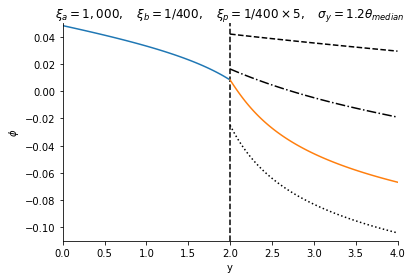

In [503]:
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_list), axis=0, weights=dmg_weight)
# ϕ_bound = np.average(ϕ_avg_list, axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
plt.plot(y_grid[:numy_bar+1], ϕ)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])
plt.plot(y_grid[numy_bar:], ϕ_list[0][numy_bar:], linestyle="--", color="black" )
plt.plot(y_grid[numy_bar:], ϕ_list[1][numy_bar:], linestyle="-.", color="black")
plt.plot(y_grid[numy_bar:], ϕ_list[2][numy_bar:], linestyle=":", color="black")
plt.vlines(x=2, ymin=-0.11, ymax=0.05, linestyle="dashed", color="black")
plt.xlim(0,4)
plt.ylim(-0.11, 0.05)
plt.ylabel('$\phi$')
plt.xlabel('y')
plt.title(r'$\xi_a = 1,000, \quad  \xi_b =1/400, \quad \xi_p = 1/400\times 5, \quad \sigma_y = 1.2 θ_{median} $')
# plt.savefig("ϕ.pdf", facecolor="w", edgecolor='w', bbox_inches="tight")

In [494]:
ϕ[-1], ϕ_bound[numy_bar]

(0.008361144758233961, 0.008361144732379531)

In [500]:
yt, et, πᵈt, πᶜt, ιt, ht = simulate_jump(y_grid[:numy_bar+1], ems, πᶜ, πᵈ, ι, h, θ_list)

(0.0, 8.685021723920029)

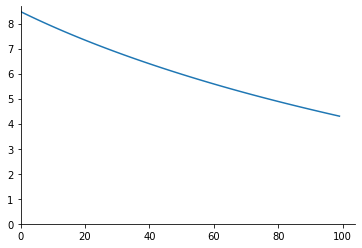

In [501]:
plt.plot(et[et>0])
plt.xlim(left=0)
plt.ylim(bottom=0)

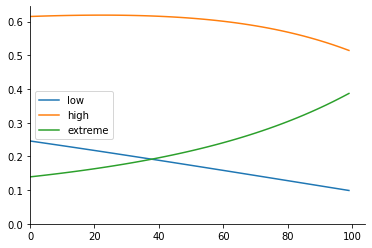

In [502]:
plt.plot(πᵈt[:,0], label="low")
plt.plot(πᵈt[:,1], label="high")
plt.plot(πᵈt[:,2], label="extreme")
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.legend()

In [456]:
ξₐ = 1/4_000
ξ = 1/400
ξₘ = ξ
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θ_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ_avg, ems_avg, πᶜ_avg, ι_avg, πᵈ_avg, h_avg, ϕ_avg_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.001488820815159573,	 ft error: 0.001398897054269229
episode: 2,	 ode error: 0.001423609733474749,	 ft error: 0.0013157624888644182
episode: 3,	 ode error: 0.0013071651245506457,	 ft error: 0.0012298869897838403
episode: 4,	 ode error: 0.0012343575910489589,	 ft error: 0.0011770865807980038
episode: 5,	 ode error: 0.0011841649842612516,	 ft error: 0.0011390019820798545
episode: 6,	 ode error: 0.0011448740898370093,	 ft error: 0.0011078542174908276
episode: 7,	 ode error: 0.0011120064280478988,	 ft error: 0.0010807545233205203
episode: 8,	 ode error: 0.0010835989065063108,	 ft error: 0.0010570703955224462
episode: 9,	 ode error: 0.0010583361098916964,	 ft error: 0.0010351216184950086
episode: 10,	 ode error: 0.0010358716333418302,	 ft error: 0.0010152467102591551
episode: 11,	 ode error: 0.0010155532642903819,	 ft error: 0.0009969968642717347
episode: 12,	 ode error: 0.0009970492908762576,	 ft error: 0.000980176660121838
episode: 13,	 ode error: 0.00098001064896

episode: 108,	 ode error: 0.000480477746061572,	 ft error: 0.0004774242218357044
episode: 109,	 ode error: 0.00047791516537573425,	 ft error: 0.0004760832975822064
episode: 110,	 ode error: 0.00047535390710021284,	 ft error: 0.0004733515079123387
episode: 111,	 ode error: 0.0004728866701290361,	 ft error: 0.0004710472311047695
episode: 112,	 ode error: 0.00047047632608852223,	 ft error: 0.000467045772168731
episode: 113,	 ode error: 0.0004681021116070494,	 ft error: 0.00046503271941499236
episode: 114,	 ode error: 0.0004656484241658611,	 ft error: 0.0004639480387462249
episode: 115,	 ode error: 0.00046317555354297233,	 ft error: 0.00046128684639647666
episode: 116,	 ode error: 0.0004608078413670623,	 ft error: 0.0004588133424038877
episode: 117,	 ode error: 0.00045846189939119516,	 ft error: 0.0004556527101317112
episode: 118,	 ode error: 0.00045616532082859017,	 ft error: 0.0004543370834734703
episode: 119,	 ode error: 0.0004537895384087834,	 ft error: 0.0004522150766510016
episode: 1

episode: 228,	 ode error: 0.0002742988393996423,	 ft error: 0.00027330122291275666
episode: 229,	 ode error: 0.00027315729089678333,	 ft error: 0.000272396433712042
episode: 230,	 ode error: 0.0002718668804592262,	 ft error: 0.00027100522568620133
episode: 231,	 ode error: 0.0002708258782880219,	 ft error: 0.00027027017920099505
episode: 232,	 ode error: 0.00027020420552073977,	 ft error: 0.00026870841044523974
episode: 233,	 ode error: 0.0002684756102121368,	 ft error: 0.0002674746420131685
episode: 234,	 ode error: 0.00026736415596812944,	 ft error: 0.000266551771048428
episode: 235,	 ode error: 0.00026613864546319815,	 ft error: 0.0002657515289427685
episode: 236,	 ode error: 0.00026592008184079467,	 ft error: 0.0002641682345549262
episode: 237,	 ode error: 0.00026388767783476323,	 ft error: 0.00026294296132910644
episode: 238,	 ode error: 0.00026281379647647275,	 ft error: 0.0002620871772192104
episode: 239,	 ode error: 0.00026159319389220065,	 ft error: 0.0002612764592291086
episo

episode: 348,	 ode error: 0.00016850418885795042,	 ft error: 0.00016776321730721522
episode: 349,	 ode error: 0.00016894231106657966,	 ft error: 0.00016678313452173077
episode: 350,	 ode error: 0.00016602297126875817,	 ft error: 0.00016663580445235954
episode: 351,	 ode error: 0.0001666453398139582,	 ft error: 0.0001657086296355757
episode: 352,	 ode error: 0.00016675659205360991,	 ft error: 0.00016475025755441353
episode: 353,	 ode error: 0.00016405533090804107,	 ft error: 0.0001644778752483515
episode: 354,	 ode error: 0.00016437653419422644,	 ft error: 0.00016359985176570466
episode: 355,	 ode error: 0.00016414912863386153,	 ft error: 0.0001625518139241472
episode: 356,	 ode error: 0.00016217682440342399,	 ft error: 0.0001621985084241523
episode: 357,	 ode error: 0.00016184016232149284,	 ft error: 0.0001614365959073244
episode: 358,	 ode error: 0.00016131358570238194,	 ft error: 0.000160928939612337
episode: 359,	 ode error: 0.00016105002993757275,	 ft error: 0.00016046358105567077


episode: 467,	 ode error: 0.0001076890315264981,	 ft error: 0.000106337866503566
episode: 468,	 ode error: 0.00010767390587828132,	 ft error: 0.0001061326222120268
episode: 469,	 ode error: 0.0001080667967566874,	 ft error: 0.00010590715190351523
episode: 470,	 ode error: 0.00010464712669761792,	 ft error: 0.00010542301492691883
episode: 471,	 ode error: 0.00010531590682172592,	 ft error: 0.00010438608621488044
episode: 472,	 ode error: 0.00010471004244159716,	 ft error: 0.00010398653285085177
episode: 473,	 ode error: 0.00010420069968371346,	 ft error: 0.00010358644387674829
episode: 474,	 ode error: 0.00010376324897188769,	 ft error: 0.00010319440807211866
episode: 475,	 ode error: 0.00010333877201692252,	 ft error: 0.00010280767234407037
episode: 476,	 ode error: 0.00010292634144289494,	 ft error: 0.00010242509366459318
episode: 477,	 ode error: 0.0001025251486392255,	 ft error: 0.0001020460138595238
episode: 478,	 ode error: 0.00010213438029741425,	 ft error: 0.00010167006468803086

episode: 589,	 ode error: 6.839883423831222e-05,	 ft error: 6.795039343326463e-05
episode: 590,	 ode error: 6.807796206551259e-05,	 ft error: 6.76844691841159e-05
episode: 591,	 ode error: 6.776938884719931e-05,	 ft error: 6.74273564569422e-05
episode: 592,	 ode error: 6.747023112469623e-05,	 ft error: 6.717511524030144e-05
episode: 593,	 ode error: 6.723070259450801e-05,	 ft error: 6.692565545222037e-05
episode: 594,	 ode error: 6.701261843655877e-05,	 ft error: 6.667788578040383e-05
episode: 595,	 ode error: 6.679230309802713e-05,	 ft error: 6.643126681469177e-05
episode: 596,	 ode error: 6.657039877235363e-05,	 ft error: 6.618556265977626e-05
episode: 597,	 ode error: 6.634742915698406e-05,	 ft error: 6.594069948668199e-05
episode: 598,	 ode error: 6.612381184626227e-05,	 ft error: 6.569668486104685e-05
episode: 599,	 ode error: 6.589987447515322e-05,	 ft error: 6.545356246198213e-05
episode: 600,	 ode error: 6.567587102655206e-05,	 ft error: 6.521138751098647e-05
episode: 601,	 ode

episode: 711,	 ode error: 4.6824815471115436e-05,	 ft error: 4.545234992462307e-05
episode: 712,	 ode error: 4.512360617329374e-05,	 ft error: 4.4771522626912974e-05
episode: 713,	 ode error: 4.470577290871503e-05,	 ft error: 4.447449710225093e-05
episode: 714,	 ode error: 4.4457494280287406e-05,	 ft error: 4.4258723727065116e-05
episode: 715,	 ode error: 4.435069699784363e-05,	 ft error: 4.405570573698392e-05
episode: 716,	 ode error: 4.4231565205855796e-05,	 ft error: 4.386015561156272e-05
episode: 717,	 ode error: 4.410400915574528e-05,	 ft error: 4.3681823532690234e-05
episode: 718,	 ode error: 4.3979169494453934e-05,	 ft error: 4.27168424865787e-05
episode: 719,	 ode error: 4.573526490081318e-05,	 ft error: 4.430704869391733e-05
episode: 720,	 ode error: 4.398514897301011e-05,	 ft error: 4.3595519129598546e-05
episode: 721,	 ode error: 4.352636613661235e-05,	 ft error: 4.330849629530231e-05
episode: 722,	 ode error: 4.3275877471287316e-05,	 ft error: 4.3093356723357866e-05
episode

episode: 832,	 ode error: 3.0193994013312498e-05,	 ft error: 2.850431387248683e-05
episode: 833,	 ode error: 3.1760469831929256e-05,	 ft error: 3.056700313893805e-05
episode: 834,	 ode error: 3.0114612416192008e-05,	 ft error: 2.9866076603999685e-05
episode: 835,	 ode error: 2.977197351644752e-05,	 ft error: 2.9618094663253863e-05
episode: 836,	 ode error: 2.97404375765349e-05,	 ft error: 2.943733239189894e-05
episode: 837,	 ode error: 2.9678930358057734e-05,	 ft error: 2.9278577454277165e-05
episode: 838,	 ode error: 2.961194554617296e-05,	 ft error: 2.794143276333335e-05
episode: 839,	 ode error: 3.1019401730898516e-05,	 ft error: 2.992357040836983e-05
episode: 840,	 ode error: 2.9455117785711477e-05,	 ft error: 2.9254769440337225e-05
episode: 841,	 ode error: 2.9206236068783057e-05,	 ft error: 2.901361769477399e-05
episode: 842,	 ode error: 2.9171957313612966e-05,	 ft error: 2.8838250727021102e-05
episode: 843,	 ode error: 2.9109080973016197e-05,	 ft error: 2.8684359002379794e-05
ep

episode: 954,	 ode error: 2.0236112502462615e-05,	 ft error: 2.0156621848866723e-05
episode: 955,	 ode error: 2.0309425524632062e-05,	 ft error: 1.995476104264815e-05
episode: 956,	 ode error: 2.0306644960750705e-05,	 ft error: 1.8393137268674087e-05
episode: 957,	 ode error: 2.119876570803186e-05,	 ft error: 2.0514429870989913e-05
episode: 958,	 ode error: 1.995631831830998e-05,	 ft error: 1.994806264065304e-05
episode: 959,	 ode error: 2.004378125625443e-05,	 ft error: 1.9731892269928924e-05
episode: 960,	 ode error: 2.0039955132879813e-05,	 ft error: 1.959490410564461e-05
episode: 961,	 ode error: 2.001139588816384e-05,	 ft error: 1.804413992362308e-05
episode: 962,	 ode error: 2.0320030013716876e-05,	 ft error: 1.803061054704569e-05
episode: 963,	 ode error: 2.1463548670782413e-05,	 ft error: 2.0426081185562217e-05
episode: 964,	 ode error: 1.988699359629269e-05,	 ft error: 1.972131560404322e-05
episode: 965,	 ode error: 1.9621321972795587e-05,	 ft error: 1.946375639899171e-05
epis

episode: 1076,	 ode error: 1.4080672152770482e-05,	 ft error: 1.3899966634552582e-05
episode: 1077,	 ode error: 1.4126480618648009e-05,	 ft error: 1.3772933019328323e-05
episode: 1078,	 ode error: 1.4135433932137916e-05,	 ft error: 1.2287311986931376e-05
episode: 1079,	 ode error: 1.4132227662632594e-05,	 ft error: 1.225650925584798e-05
episode: 1080,	 ode error: 1.461017530699155e-05,	 ft error: 1.424188431770057e-05
episode: 1081,	 ode error: 1.3749330038276297e-05,	 ft error: 1.3783034335361951e-05
episode: 1082,	 ode error: 1.3878029766943513e-05,	 ft error: 1.3598971522870337e-05
episode: 1083,	 ode error: 1.3914838097809972e-05,	 ft error: 1.2214023412023453e-05
episode: 1084,	 ode error: 1.4207216233973999e-05,	 ft error: 1.217318900561167e-05
episode: 1085,	 ode error: 1.4837531127776275e-05,	 ft error: 1.4257882069273106e-05
episode: 1086,	 ode error: 1.3696823446499896e-05,	 ft error: 1.3685920071370336e-05
episode: 1087,	 ode error: 1.3635184564494886e-05,	 ft error: 1.34667

episode: 1198,	 ode error: 9.91874040565696e-06,	 ft error: 9.722958350319444e-06
episode: 1199,	 ode error: 9.990271368309853e-06,	 ft error: 8.514198783643456e-06
episode: 1200,	 ode error: 9.953233844662863e-06,	 ft error: 8.317642171198902e-06
episode: 1201,	 ode error: 1.0192337130502998e-05,	 ft error: 1.008728728569645e-05
episode: 1202,	 ode error: 9.656254909714136e-06,	 ft error: 9.73425532973619e-06
episode: 1203,	 ode error: 9.813639705699229e-06,	 ft error: 9.58552501322448e-06
episode: 1204,	 ode error: 9.876349009514999e-06,	 ft error: 8.315122350920542e-06
episode: 1205,	 ode error: 9.747942048396918e-06,	 ft error: 8.147551181480103e-06
episode: 1206,	 ode error: 9.961376292746374e-06,	 ft error: 9.901192738748232e-06
episode: 1207,	 ode error: 9.561188080627189e-06,	 ft error: 9.576979238419086e-06
episode: 1208,	 ode error: 9.702189592579154e-06,	 ft error: 9.438367620471604e-06
episode: 1209,	 ode error: 9.756520743926583e-06,	 ft error: 8.131804074690274e-06
episod

episode: 1321,	 ode error: 7.182096367178126e-06,	 ft error: 6.8878532718622916e-06
episode: 1322,	 ode error: 7.2363399502556455e-06,	 ft error: 5.672425038664534e-06
episode: 1323,	 ode error: 6.901213143898168e-06,	 ft error: 5.518149056952619e-06
episode: 1324,	 ode error: 7.045065269126595e-06,	 ft error: 7.136486992187496e-06
episode: 1325,	 ode error: 6.986993285609854e-06,	 ft error: 6.870481780510418e-06
episode: 1326,	 ode error: 7.112162981982384e-06,	 ft error: 5.893986097307846e-06
episode: 1327,	 ode error: 7.091950836076301e-06,	 ft error: 5.649475483699799e-06
episode: 1328,	 ode error: 7.346163498132873e-06,	 ft error: 7.246576243097325e-06
episode: 1329,	 ode error: 6.793406462981383e-06,	 ft error: 6.9014125294447615e-06
episode: 1330,	 ode error: 6.969231126295302e-06,	 ft error: 6.7614344188606425e-06
episode: 1331,	 ode error: 7.045990874808756e-06,	 ft error: 5.690946093632003e-06
episode: 1332,	 ode error: 6.921036848450191e-06,	 ft error: 5.462740693291483e-06


episode: 1443,	 ode error: 5.310010756724411e-06,	 ft error: 3.972303823350972e-06
episode: 1444,	 ode error: 5.538544313939001e-06,	 ft error: 5.461006576552389e-06
episode: 1445,	 ode error: 5.0428849887018115e-06,	 ft error: 5.132635703998986e-06
episode: 1446,	 ode error: 5.216336398415687e-06,	 ft error: 5.000487354744898e-06
episode: 1447,	 ode error: 5.2949081987900245e-06,	 ft error: 4.063002106378481e-06
episode: 1448,	 ode error: 5.149899293476032e-06,	 ft error: 3.828484615372996e-06
episode: 1449,	 ode error: 5.345366630544741e-06,	 ft error: 5.32616328541291e-06
episode: 1450,	 ode error: 5.032363296606206e-06,	 ft error: 5.035928429102573e-06
episode: 1451,	 ode error: 5.182507177555547e-06,	 ft error: 4.916847328034768e-06
episode: 1452,	 ode error: 5.248946641684977e-06,	 ft error: 3.906502802746478e-06
episode: 1453,	 ode error: 4.992274061770777e-06,	 ft error: 3.704873145100411e-06
episode: 1454,	 ode error: 5.161303887791179e-06,	 ft error: 5.191925762255504e-06
epi

episode: 1565,	 ode error: 4.088551633871359e-06,	 ft error: 2.9281196704579924e-06
episode: 1566,	 ode error: 3.900879752887442e-06,	 ft error: 2.6988680651429675e-06
episode: 1567,	 ode error: 4.091557440949315e-06,	 ft error: 4.089949397582486e-06
episode: 1568,	 ode error: 3.845532763788856e-06,	 ft error: 3.816374355564145e-06
episode: 1569,	 ode error: 3.990344967200903e-06,	 ft error: 3.705975048599412e-06
episode: 1570,	 ode error: 4.055701116706021e-06,	 ft error: 2.7962811816745203e-06
episode: 1571,	 ode error: 3.7645222084788923e-06,	 ft error: 2.5928640653982704e-06
episode: 1572,	 ode error: 3.9289894750642144e-06,	 ft error: 3.9860195665218185e-06
episode: 1573,	 ode error: 3.830873803668442e-06,	 ft error: 3.733996055433712e-06
episode: 1574,	 ode error: 3.96989063767097e-06,	 ft error: 3.1234043743981017e-06
episode: 1575,	 ode error: 4.01503880059534e-06,	 ft error: 2.851929303757106e-06
episode: 1576,	 ode error: 4.298367547096835e-06,	 ft error: 4.166522634639162e-0

episode: 13,	 ode error: 0.000979984196998072,	 ft error: 0.0009645234301207974
episode: 14,	 ode error: 0.0009642346307933824,	 ft error: 0.0009499116975758299
episode: 15,	 ode error: 0.0009495332638828207,	 ft error: 0.0009362355437156067
episode: 16,	 ode error: 0.0009357772993098216,	 ft error: 0.0009233555297985472
episode: 17,	 ode error: 0.0009228343494768589,	 ft error: 0.000911172404927839
episode: 18,	 ode error: 0.0009106018162486403,	 ft error: 0.0008995607954682209
episode: 19,	 ode error: 0.0008989806857231414,	 ft error: 0.0008885468147131505
episode: 20,	 ode error: 0.0008879292230657917,	 ft error: 0.000878032987148937
episode: 21,	 ode error: 0.0008773839307014693,	 ft error: 0.0008679684784069011
episode: 22,	 ode error: 0.000867293100087456,	 ft error: 0.0008583110523669845
episode: 23,	 ode error: 0.0008576134738852786,	 ft error: 0.0008490248069482377
episode: 24,	 ode error: 0.0008483083992199948,	 ft error: 0.0008400093124678761
episode: 25,	 ode error: 0.00083

episode: 118,	 ode error: 0.00045513871002982487,	 ft error: 0.00045337925565444354
episode: 119,	 ode error: 0.0004527734341039476,	 ft error: 0.0004511267738057864
episode: 120,	 ode error: 0.0004504181702506475,	 ft error: 0.0004487834335537011
episode: 121,	 ode error: 0.0004480778041119059,	 ft error: 0.0004464549532834719
episode: 122,	 ode error: 0.0004457517626445586,	 ft error: 0.0004441408186180394
episode: 123,	 ode error: 0.00044343980942613973,	 ft error: 0.00044184076310725456
episode: 124,	 ode error: 0.00044114176823945007,	 ft error: 0.00043955452597490197
episode: 125,	 ode error: 0.0004388574435899219,	 ft error: 0.00043728185469479874
episode: 126,	 ode error: 0.0004365866118595115,	 ft error: 0.0004350225006215005
episode: 127,	 ode error: 0.00043432902949263306,	 ft error: 0.00043277621378785364
episode: 128,	 ode error: 0.0004320844419303888,	 ft error: 0.0004305427416503629
episode: 129,	 ode error: 0.00042985259008473746,	 ft error: 0.0004283218303463912
episod

episode: 232,	 ode error: 0.0002455382083506387,	 ft error: 0.00024486460640805085
episode: 233,	 ode error: 0.00024413435964447752,	 ft error: 0.0002434654106843459
episode: 234,	 ode error: 0.0002427377746169702,	 ft error: 0.00024207349744847137
episode: 235,	 ode error: 0.0002413484324278835,	 ft error: 0.00024068884399898
episode: 236,	 ode error: 0.00023996631212086365,	 ft error: 0.00023931142753462015
episode: 237,	 ode error: 0.00023859139260571868,	 ft error: 0.00023794122514138316
episode: 238,	 ode error: 0.00023722365264504418,	 ft error: 0.00023657821378565702
episode: 239,	 ode error: 0.00023586307084384587,	 ft error: 0.00023522237030763432
episode: 240,	 ode error: 0.00023450962564145405,	 ft error: 0.00023387367141756526
episode: 241,	 ode error: 0.00023316329530526341,	 ft error: 0.0002325320936933754
episode: 242,	 ode error: 0.0002318240579259757,	 ft error: 0.0002311976135778669
episode: 243,	 ode error: 0.0002304918914138995,	 ft error: 0.00022987020737779326
epi

episode: 349,	 ode error: 0.00012423257049353907,	 ft error: 0.00012395036390127717
episode: 350,	 ode error: 0.00012350707468651405,	 ft error: 0.0001232274763228227
episode: 351,	 ode error: 0.00012278577312422223,	 ft error: 0.00012250876677994776
episode: 352,	 ode error: 0.00012206864228983083,	 ft error: 0.00012179421167606472
episode: 353,	 ode error: 0.0001213556587652294,	 ft error: 0.00012108378752577013
episode: 354,	 ode error: 0.00012064679923092501,	 ft error: 0.00012037747095468287
episode: 355,	 ode error: 0.00011994204046609776,	 ft error: 0.00011967523869807947
episode: 356,	 ode error: 0.00011924135934858666,	 ft error: 0.00011897706760066278
episode: 357,	 ode error: 0.0001185447328549416,	 ft error: 0.00011828293461570624
episode: 358,	 ode error: 0.00011785213806061903,	 ft error: 0.00011759281680445248
episode: 359,	 ode error: 0.00011716355213997013,	 ft error: 0.00011690669133595141
episode: 360,	 ode error: 0.00011647895236640486,	 ft error: 0.0001162245354860

episode: 470,	 ode error: 6.110803350815148e-05,	 ft error: 6.095373204656936e-05
episode: 471,	 ode error: 6.0747284244054177e-05,	 ft error: 6.0594267294415235e-05
episode: 472,	 ode error: 6.038858620521304e-05,	 ft error: 6.0236844289518476e-05
episode: 473,	 ode error: 6.00319276487176e-05,	 ft error: 5.988145137347338e-05
episode: 474,	 ode error: 5.96772968947133e-05,	 ft error: 5.952807695018547e-05
episode: 475,	 ode error: 5.932468232624306e-05,	 ft error: 5.917670948543212e-05
episode: 476,	 ode error: 5.897407238903362e-05,	 ft error: 5.88273375068162e-05
episode: 477,	 ode error: 5.862545559141472e-05,	 ft error: 5.8479949603766165e-05
episode: 478,	 ode error: 5.827882050415663e-05,	 ft error: 5.813453442721217e-05
episode: 479,	 ode error: 5.793415576021911e-05,	 ft error: 5.779108068942422e-05
episode: 480,	 ode error: 5.759145005473302e-05,	 ft error: 5.74495771640815e-05
episode: 481,	 ode error: 5.7250692144694324e-05,	 ft error: 5.7110012685763586e-05
episode: 482,	

episode: 591,	 ode error: 2.9467233789824774e-05,	 ft error: 2.974334959220578e-05
episode: 592,	 ode error: 2.928712006765213e-05,	 ft error: 2.9667935107444608e-05
episode: 593,	 ode error: 2.9108025267161972e-05,	 ft error: 2.9592703296709804e-05
episode: 594,	 ode error: 2.8929943659999555e-05,	 ft error: 2.9517653731513105e-05
episode: 595,	 ode error: 2.8752869552662675e-05,	 ft error: 2.944278598456899e-05
episode: 596,	 ode error: 2.8640518490714444e-05,	 ft error: 2.936809962955182e-05
episode: 597,	 ode error: 2.8566860886881853e-05,	 ft error: 2.9293594241997883e-05
episode: 598,	 ode error: 2.8493377448180092e-05,	 ft error: 2.9219269397721036e-05
episode: 599,	 ode error: 2.8420067805825952e-05,	 ft error: 2.9145124674674616e-05
episode: 600,	 ode error: 2.8346931591663812e-05,	 ft error: 2.9071159651552124e-05
episode: 601,	 ode error: 2.827396843816651e-05,	 ft error: 2.899737390792597e-05
episode: 602,	 ode error: 2.8201177978435317e-05,	 ft error: 2.8923767025218948e-0

episode: 712,	 ode error: 2.1168824884077288e-05,	 ft error: 2.1830109241232264e-05
episode: 713,	 ode error: 2.111306461998711e-05,	 ft error: 2.1773987021270667e-05
episode: 714,	 ode error: 2.1057439749860277e-05,	 ft error: 2.171800284012556e-05
episode: 715,	 ode error: 2.100194997313798e-05,	 ft error: 2.1662156379151365e-05
episode: 716,	 ode error: 2.094659498980993e-05,	 ft error: 2.1606447320581444e-05
episode: 717,	 ode error: 2.089137450041962e-05,	 ft error: 2.1550875347181125e-05
episode: 718,	 ode error: 2.0836288206060513e-05,	 ft error: 2.149544014246746e-05
episode: 719,	 ode error: 2.078133580837914e-05,	 ft error: 2.1440141390593564e-05
episode: 720,	 ode error: 2.0726517009569343e-05,	 ft error: 2.1384978776418005e-05
episode: 721,	 ode error: 2.0671831512375982e-05,	 ft error: 2.1329951985597322e-05
episode: 722,	 ode error: 2.0617279020091275e-05,	 ft error: 2.1275060704400994e-05
episode: 723,	 ode error: 2.0562859236561388e-05,	 ft error: 2.1220304619422314e-05

episode: 833,	 ode error: 1.5309743417633523e-05,	 ft error: 1.5951809823992746e-05
episode: 834,	 ode error: 1.5268358816400586e-05,	 ft error: 1.5905709016712326e-05
episode: 835,	 ode error: 1.5227083864447567e-05,	 ft error: 1.5861405957065533e-05
episode: 836,	 ode error: 1.5185914729810612e-05,	 ft error: 1.5818631354814115e-05
episode: 837,	 ode error: 1.5142285016754255e-05,	 ft error: 1.6631537283126146e-05
episode: 838,	 ode error: 1.5099219703244718e-05,	 ft error: 1.65503070571546e-05
episode: 839,	 ode error: 1.5058659017314194e-05,	 ft error: 1.5703082027011355e-05
episode: 840,	 ode error: 1.5017857206806631e-05,	 ft error: 1.5668552187468137e-05
episode: 841,	 ode error: 1.4977171660875648e-05,	 ft error: 1.5623666076563607e-05
episode: 842,	 ode error: 1.4936602383817694e-05,	 ft error: 1.5577398123356456e-05
episode: 843,	 ode error: 1.4896145453373983e-05,	 ft error: 1.5532260305012313e-05
episode: 844,	 ode error: 1.485579599793901e-05,	 ft error: 1.5488906361278698

episode: 954,	 ode error: 1.0920459461735758e-05,	 ft error: 1.1554130107313081e-05
episode: 955,	 ode error: 1.089007948873913e-05,	 ft error: 1.1517857801563818e-05
episode: 956,	 ode error: 1.085719427541018e-05,	 ft error: 1.2347482449513725e-05
episode: 957,	 ode error: 1.0824877917633112e-05,	 ft error: 1.2266666743314855e-05
episode: 958,	 ode error: 1.0795040467202283e-05,	 ft error: 1.142914328429214e-05
episode: 959,	 ode error: 1.0764941589657312e-05,	 ft error: 1.140477461928959e-05
episode: 960,	 ode error: 1.0734933604833886e-05,	 ft error: 1.137063141533103e-05
episode: 961,	 ode error: 1.0705016492604849e-05,	 ft error: 1.1335201523995458e-05
episode: 962,	 ode error: 1.0675186498953598e-05,	 ft error: 1.1300855112863589e-05
episode: 963,	 ode error: 1.0642862628523785e-05,	 ft error: 1.2126987614565396e-05
episode: 964,	 ode error: 1.0611095561366028e-05,	 ft error: 1.2049735592691013e-05
episode: 965,	 ode error: 1.0579234952648816e-05,	 ft error: 1.20701952593949e-05

episode: 1073,	 ode error: 7.715044256093409e-06,	 ft error: 8.338315567480808e-06
episode: 1074,	 ode error: 7.690269843341576e-06,	 ft error: 9.174814756506e-06
episode: 1075,	 ode error: 7.666041743505629e-06,	 ft error: 9.10204068182291e-06
episode: 1076,	 ode error: 7.641702767226943e-06,	 ft error: 9.129411048987754e-06
episode: 1077,	 ode error: 7.619990489722924e-06,	 ft error: 8.256905558815902e-06
episode: 1078,	 ode error: 7.5979875559747695e-06,	 ft error: 8.23930744454221e-06
episode: 1079,	 ode error: 7.576059907269761e-06,	 ft error: 8.211769324042995e-06
episode: 1080,	 ode error: 7.5542073243452484e-06,	 ft error: 8.1829968724458e-06
episode: 1081,	 ode error: 7.532425432194554e-06,	 ft error: 8.155519224603558e-06
episode: 1082,	 ode error: 7.508121412683655e-06,	 ft error: 8.99248443739925e-06
episode: 1083,	 ode error: 7.4843623770767624e-06,	 ft error: 8.920186971283588e-06
episode: 1084,	 ode error: 7.4604914497924414e-06,	 ft error: 8.94798580935302e-06
episode: 

episode: 1194,	 ode error: 5.317509864852639e-06,	 ft error: 6.80139217720116e-06
episode: 1195,	 ode error: 5.2994281269069235e-06,	 ft error: 6.7347879339809315e-06
episode: 1196,	 ode error: 5.281221707257851e-06,	 ft error: 6.767876710028764e-06
episode: 1197,	 ode error: 5.265628533331377e-06,	 ft error: 5.900835655346659e-06
episode: 1198,	 ode error: 5.249731480659034e-06,	 ft error: 5.889297673191315e-06
episode: 1199,	 ode error: 5.233894295267284e-06,	 ft error: 5.867950107855495e-06
episode: 1200,	 ode error: 5.218116776662074e-06,	 ft error: 5.84538544187487e-06
episode: 1201,	 ode error: 5.202394643570178e-06,	 ft error: 5.824086008824244e-06
episode: 1202,	 ode error: 5.184132500591428e-06,	 ft error: 6.668082034207157e-06
episode: 1203,	 ode error: 5.166398725814353e-06,	 ft error: 6.601825851595041e-06
episode: 1204,	 ode error: 5.148539469719722e-06,	 ft error: 6.635240609754549e-06
episode: 1205,	 ode error: 5.133292831212478e-06,	 ft error: 5.7684611113236386e-06
epi

episode: 1315,	 ode error: 3.580696608798141e-06,	 ft error: 4.20090786259116e-06
episode: 1316,	 ode error: 3.5667075661871322e-06,	 ft error: 5.04644061934123e-06
episode: 1317,	 ode error: 3.5532240697035177e-06,	 ft error: 4.987651202453351e-06
episode: 1318,	 ode error: 3.5421721837692916e-06,	 ft error: 4.169793123449487e-06
episode: 1319,	 ode error: 3.5308192068734677e-06,	 ft error: 4.164077228308027e-06
episode: 1320,	 ode error: 3.519509979578293e-06,	 ft error: 4.1489689471888025e-06
episode: 1321,	 ode error: 3.5082446153140556e-06,	 ft error: 4.13259822435591e-06
episode: 1322,	 ode error: 3.4970196897139813e-06,	 ft error: 4.117202310656895e-06
episode: 1323,	 ode error: 3.483252952143505e-06,	 ft error: 4.9626817570762784e-06
episode: 1324,	 ode error: 3.469990358451663e-06,	 ft error: 4.904333620510867e-06
episode: 1325,	 ode error: 3.4591586004290497e-06,	 ft error: 4.0867948375896326e-06
episode: 1326,	 ode error: 3.448025279566172e-06,	 ft error: 4.081303267543709e-

episode: 1437,	 ode error: 2.320913929359158e-06,	 ft error: 2.9494726627258645e-06
episode: 1438,	 ode error: 2.312805934934377e-06,	 ft error: 2.947012124193682e-06
episode: 1439,	 ode error: 2.3047332682675406e-06,	 ft error: 2.935164205286149e-06
episode: 1440,	 ode error: 2.2966960750736044e-06,	 ft error: 2.9220474653697077e-06
episode: 1441,	 ode error: 2.2886909670194434e-06,	 ft error: 2.9098928659247276e-06
episode: 1442,	 ode error: 2.280713740398122e-06,	 ft error: 2.899262195541393e-06
episode: 1443,	 ode error: 2.270199788835639e-06,	 ft error: 3.7436969107842075e-06
episode: 1444,	 ode error: 2.260165205984603e-06,	 ft error: 3.6931790098916157e-06
episode: 1445,	 ode error: 2.252549965532809e-06,	 ft error: 2.8805152345670604e-06
episode: 1446,	 ode error: 2.244625951121164e-06,	 ft error: 2.87841671972137e-06
episode: 1447,	 ode error: 2.236736419683775e-06,	 ft error: 2.8668970703318863e-06
episode: 1448,	 ode error: 2.2288815680873892e-06,	 ft error: 2.85408734282862

episode: 1559,	 ode error: 1.6088470005098249e-06,	 ft error: 2.0497393594248736e-06
episode: 1560,	 ode error: 1.6101000644994177e-06,	 ft error: 2.0400313208967145e-06
episode: 1561,	 ode error: 1.6113586120390395e-06,	 ft error: 2.0318058491115383e-06
episode: 1562,	 ode error: 1.6160595866982798e-06,	 ft error: 2.88029257096654e-06
episode: 1563,	 ode error: 1.623106508656842e-06,	 ft error: 2.8322537264438563e-06
episode: 1564,	 ode error: 1.6266236208493652e-06,	 ft error: 2.020060886111693e-06
episode: 1565,	 ode error: 1.6278708475595677e-06,	 ft error: 2.0202853234900973e-06
episode: 1566,	 ode error: 1.6291026116179406e-06,	 ft error: 2.0110796942450957e-06
episode: 1567,	 ode error: 1.6303236703902636e-06,	 ft error: 2.000577566142747e-06
episode: 1568,	 ode error: 1.6315426572049638e-06,	 ft error: 1.9910023000650296e-06
episode: 1,	 ode error: 0.0014888210065495224,	 ft error: 0.0013988332576194455
episode: 2,	 ode error: 0.0014235288881512028,	 ft error: 0.001315631166556

episode: 93,	 ode error: 0.0007551760818110403,	 ft error: 0.000754828019932062
episode: 94,	 ode error: 0.0007529247280748942,	 ft error: 0.0007525867228807872
episode: 95,	 ode error: 0.0007506800594353653,	 ft error: 0.0007503519003834724
episode: 96,	 ode error: 0.0007484420565740395,	 ft error: 0.0007481235360463103
episode: 97,	 ode error: 0.0007462107002206179,	 ft error: 0.0007459016137982555
episode: 98,	 ode error: 0.000743985971152117,	 ft error: 0.0007436861178346822
episode: 99,	 ode error: 0.0007417678501922052,	 ft error: 0.0007414770325728122
episode: 100,	 ode error: 0.0007395563182106535,	 ft error: 0.000739274342613401
episode: 101,	 ode error: 0.0007373513561228858,	 ft error: 0.0007370780327066336
episode: 102,	 ode error: 0.0007351529448896331,	 ft error: 0.0007348880877190596
episode: 103,	 ode error: 0.0007329610655166716,	 ft error: 0.0007327044926030054
episode: 104,	 ode error: 0.0007307756990546597,	 ft error: 0.0007305272323662043
episode: 105,	 ode error: 

episode: 207,	 ode error: 0.0005373046108784539,	 ft error: 0.0005371110907183285
episode: 208,	 ode error: 0.0005357009046897817,	 ft error: 0.0005360784341369024
episode: 209,	 ode error: 0.0005341021935985259,	 ft error: 0.0005344107431481023
episode: 210,	 ode error: 0.0005325090311632201,	 ft error: 0.0005325563796281195
episode: 211,	 ode error: 0.0005309205713840677,	 ft error: 0.000530983383678213
episode: 212,	 ode error: 0.0005293368049797628,	 ft error: 0.0005294144307099504
episode: 213,	 ode error: 0.000527757719571459,	 ft error: 0.0005278496154708517
episode: 214,	 ode error: 0.0005261833028283851,	 ft error: 0.0005262889222670588
episode: 215,	 ode error: 0.0005246135425530444,	 ft error: 0.0005247323066314101
episode: 216,	 ode error: 0.000523048426681467,	 ft error: 0.0005231797239162866
episode: 217,	 ode error: 0.0005214879432459013,	 ft error: 0.0005216311419097471
episode: 218,	 ode error: 0.0005199320803384934,	 ft error: 0.0005200865405481879
episode: 219,	 ode 

episode: 322,	 ode error: 0.00038104854092344616,	 ft error: 0.0003810892944594117
episode: 323,	 ode error: 0.0003799118826540537,	 ft error: 0.00037995083575011657
episode: 324,	 ode error: 0.0003787786197730591,	 ft error: 0.0003788158044632876
episode: 325,	 ode error: 0.0003776487420601494,	 ft error: 0.0003776841899013247
episode: 326,	 ode error: 0.0003765222393269167,	 ft error: 0.00037655598139794505
episode: 327,	 ode error: 0.00037539910141675325,	 ft error: 0.00037543116832017276
episode: 328,	 ode error: 0.00037427931820475826,	 ft error: 0.0003743097400672746
episode: 329,	 ode error: 0.00037316287959763487,	 ft error: 0.00037319168607251785
episode: 330,	 ode error: 0.00037204977553359215,	 ft error: 0.0003720769958026153
episode: 331,	 ode error: 0.000370939995982242,	 ft error: 0.0003709656587581415
episode: 332,	 ode error: 0.00036983353094449634,	 ft error: 0.0003698576644739956
episode: 333,	 ode error: 0.00036873037045246444,	 ft error: 0.0003687530025198634
episod

episode: 436,	 ode error: 0.0002710794728733115,	 ft error: 0.0002710340646016237
episode: 437,	 ode error: 0.00027027105567441407,	 ft error: 0.00027022543441700597
episode: 438,	 ode error: 0.00026946505027206763,	 ft error: 0.00026941922007380403
episode: 439,	 ode error: 0.0002686614494614146,	 ft error: 0.0002686154142943672
episode: 440,	 ode error: 0.0002678602460593004,	 ft error: 0.000267814009823573
episode: 441,	 ode error: 0.0002670614329041978,	 ft error: 0.0002670149994298913
episode: 442,	 ode error: 0.00026626500285614676,	 ft error: 0.00026621837590413516
episode: 443,	 ode error: 0.0002654709487966789,	 ft error: 0.0002654241320601547
episode: 444,	 ode error: 0.0002646792636287553,	 ft error: 0.00026463226073432844
episode: 445,	 ode error: 0.0002638899402766956,	 ft error: 0.00026384275478584057
episode: 446,	 ode error: 0.0002631029716861122,	 ft error: 0.0002630556070959874
episode: 447,	 ode error: 0.0002623183508238424,	 ft error: 0.0002622708105688709
episode: 

episode: 552,	 ode error: 0.00019160661985028588,	 ft error: 0.00019175380795867966
episode: 553,	 ode error: 0.0001910346738149811,	 ft error: 0.00019117860989246543
episode: 554,	 ode error: 0.00019046444322256466,	 ft error: 0.00019060518183039443
episode: 555,	 ode error: 0.00018989592279754057,	 ft error: 0.00019003351732327367
episode: 556,	 ode error: 0.0001893291072835382,	 ft error: 0.00018946360997640355
episode: 557,	 ode error: 0.00018876399144317235,	 ft error: 0.00018889545344296285
episode: 558,	 ode error: 0.00018820057005789262,	 ft error: 0.00018832904142650672
episode: 559,	 ode error: 0.00018763883792784198,	 ft error: 0.00018776436767680335
episode: 560,	 ode error: 0.00018707878987171765,	 ft error: 0.00018720142599099043
episode: 561,	 ode error: 0.00018652042072663216,	 ft error: 0.0001866402102125575
episode: 562,	 ode error: 0.00018596372534798896,	 ft error: 0.00018608071422671996
episode: 563,	 ode error: 0.00018540869860934027,	 ft error: 0.0001855229319656

episode: 670,	 ode error: 0.0001346785726363686,	 ft error: 0.00013464453022827655
episode: 671,	 ode error: 0.00013427695627915267,	 ft error: 0.0001342422857595708
episode: 672,	 ode error: 0.00013387653966817983,	 ft error: 0.00013384124857444374
episode: 673,	 ode error: 0.00013347731920296398,	 ft error: 0.00013344141497131923
episode: 674,	 ode error: 0.00013307929129405813,	 ft error: 0.00013304278126018607
episode: 675,	 ode error: 0.00013268245236301257,	 ft error: 0.0001326453437646332
episode: 676,	 ode error: 0.00013228679884233832,	 ft error: 0.00013224909882018448
episode: 677,	 ode error: 0.0001318923271754704,	 ft error: 0.0001318540427752239
episode: 678,	 ode error: 0.00013149903381673206,	 ft error: 0.00013146017198974644
episode: 679,	 ode error: 0.0001311069152312935,	 ft error: 0.00013106748283730116
episode: 680,	 ode error: 0.00013071596789514099,	 ft error: 0.0001306759717026318
episode: 681,	 ode error: 0.00013032618829503587,	 ft error: 0.00013028563498306464

episode: 804,	 ode error: 9.027156669424064e-05,	 ft error: 9.019457037055349e-05
episode: 805,	 ode error: 9.00025301891846e-05,	 ft error: 8.992539742037435e-05
episode: 806,	 ode error: 8.97342965516533e-05,	 ft error: 8.965702885226542e-05
episode: 807,	 ode error: 8.946686338253589e-05,	 ft error: 8.938946225042765e-05
episode: 808,	 ode error: 8.920022828992342e-05,	 ft error: 8.912269520697236e-05
episode: 809,	 ode error: 8.893438888909035e-05,	 ft error: 8.88567253210885e-05
episode: 810,	 ode error: 8.866934280246999e-05,	 ft error: 8.85915501991815e-05
episode: 811,	 ode error: 8.840508765963384e-05,	 ft error: 8.83271674551045e-05
episode: 812,	 ode error: 8.814162109726902e-05,	 ft error: 8.806357471015844e-05
episode: 813,	 ode error: 8.787894075915753e-05,	 ft error: 8.780076959276814e-05
episode: 814,	 ode error: 8.761704429615237e-05,	 ft error: 8.753874973871367e-05
episode: 815,	 ode error: 8.735592936615999e-05,	 ft error: 8.727751279080653e-05
episode: 816,	 ode er

episode: 953,	 ode error: 5.787173850777135e-05,	 ft error: 5.778496568631386e-05
episode: 954,	 ode error: 5.769937178363104e-05,	 ft error: 5.761257650005458e-05
episode: 955,	 ode error: 5.752751925928784e-05,	 ft error: 5.744070183541505e-05
episode: 956,	 ode error: 5.735617940010279e-05,	 ft error: 5.726934015432006e-05
episode: 957,	 ode error: 5.718535067602247e-05,	 ft error: 5.7098489923505344e-05
episode: 958,	 ode error: 5.7015031561566615e-05,	 ft error: 5.6928149614471346e-05
episode: 959,	 ode error: 5.68452205358136e-05,	 ft error: 5.675831770315942e-05
episode: 960,	 ode error: 5.6675916082386335e-05,	 ft error: 5.658899267027562e-05
episode: 961,	 ode error: 5.650711668944144e-05,	 ft error: 5.6420173000920615e-05
episode: 962,	 ode error: 5.633882084965058e-05,	 ft error: 5.625185718477477e-05
episode: 963,	 ode error: 5.6171027060193755e-05,	 ft error: 5.60840437158668e-05
episode: 964,	 ode error: 5.600373382273847e-05,	 ft error: 5.5916731093360227e-05
episode: 96

episode: 1111,	 ode error: 3.613043624470496e-05,	 ft error: 3.6042656045102525e-05
episode: 1112,	 ode error: 3.60229227311438e-05,	 ft error: 3.593514583362841e-05
episode: 1113,	 ode error: 3.591572990360118e-05,	 ft error: 3.5827956370582115e-05
episode: 1114,	 ode error: 3.580885680537428e-05,	 ft error: 3.572108669816498e-05
episode: 1115,	 ode error: 3.570230248261348e-05,	 ft error: 3.561453586195529e-05
episode: 1116,	 ode error: 3.5596065984319506e-05,	 ft error: 3.5508302909983046e-05
episode: 1117,	 ode error: 3.549014636233024e-05,	 ft error: 3.540238689351642e-05
episode: 1118,	 ode error: 3.5384542671313985e-05,	 ft error: 3.5296786866367835e-05
episode: 1119,	 ode error: 3.527925396876186e-05,	 ft error: 3.519150188517155e-05
episode: 1120,	 ode error: 3.517427931497546e-05,	 ft error: 3.508653100966116e-05
episode: 1121,	 ode error: 3.506961777306511e-05,	 ft error: 3.49818733020683e-05
episode: 1122,	 ode error: 3.4965268408936e-05,	 ft error: 3.487752782763143e-05
ep

episode: 1278,	 ode error: 2.197258223562656e-05,	 ft error: 2.1885787674785773e-05
episode: 1279,	 ode error: 2.190729680162716e-05,	 ft error: 2.1820509069162924e-05
episode: 1280,	 ode error: 2.1842206087142792e-05,	 ft error: 2.175542518231821e-05
episode: 1281,	 ode error: 2.177730951136831e-05,	 ft error: 2.1690535433558738e-05
episode: 1282,	 ode error: 2.1712606495230893e-05,	 ft error: 2.162583924348686e-05
episode: 1283,	 ode error: 2.1648096461384866e-05,	 ft error: 2.1561336034786605e-05
episode: 1284,	 ode error: 2.1583778834207562e-05,	 ft error: 2.1497025231807337e-05
episode: 1285,	 ode error: 2.151965303979304e-05,	 ft error: 2.1432906260610007e-05
episode: 1286,	 ode error: 2.14557185059471e-05,	 ft error: 2.1368978548735873e-05
episode: 1287,	 ode error: 2.1391974662183805e-05,	 ft error: 2.1305241525715335e-05
episode: 1288,	 ode error: 2.1328420939718123e-05,	 ft error: 2.1241694622605355e-05
episode: 1289,	 ode error: 2.1265056771461142e-05,	 ft error: 2.117833727

episode: 1446,	 ode error: 1.3394402476839e-05,	 ft error: 1.3250078811412788e-05
episode: 1447,	 ode error: 1.3372466999741219e-05,	 ft error: 1.3210558996631002e-05
episode: 1448,	 ode error: 1.3350591186612196e-05,	 ft error: 1.3171157059686338e-05
episode: 1449,	 ode error: 1.332877488170938e-05,	 ft error: 1.3131872648730614e-05
episode: 1450,	 ode error: 1.3307017929663572e-05,	 ft error: 1.309270541330343e-05
episode: 1451,	 ode error: 1.3285320175481721e-05,	 ft error: 1.3053655003915829e-05
episode: 1452,	 ode error: 1.3263681464543756e-05,	 ft error: 1.301472107200404e-05
episode: 1453,	 ode error: 1.3242101642604516e-05,	 ft error: 1.2975903270021998e-05
episode: 1454,	 ode error: 1.3220580555788968e-05,	 ft error: 1.2937201251718896e-05
episode: 1455,	 ode error: 1.3199118050597374e-05,	 ft error: 1.2898614671399041e-05
episode: 1456,	 ode error: 1.3177713973898503e-05,	 ft error: 1.2860143184985814e-05
episode: 1457,	 ode error: 1.3156368172930925e-05,	 ft error: 1.2821786

episode: 1603,	 ode error: 1.0591241223627398e-05,	 ft error: 8.289904150221572e-06
episode: 1604,	 ode error: 1.057698569717683e-05,	 ft error: 8.265179024200913e-06
episode: 1605,	 ode error: 1.0562769527056e-05,	 ft error: 8.24052764437459e-06
episode: 1606,	 ode error: 1.054859260781185e-05,	 ft error: 8.215949790594628e-06
episode: 1607,	 ode error: 1.0534454834263939e-05,	 ft error: 8.19144524363824e-06
episode: 1608,	 ode error: 1.0520356101495013e-05,	 ft error: 8.167013784884011e-06
episode: 1609,	 ode error: 1.05062963048555e-05,	 ft error: 8.14265519645067e-06
episode: 1610,	 ode error: 1.04922753399625e-05,	 ft error: 8.118369260456948e-06
episode: 1611,	 ode error: 1.0478293102698528e-05,	 ft error: 8.094155760871951e-06
episode: 1612,	 ode error: 1.046434948921231e-05,	 ft error: 8.070014481202186e-06
episode: 1613,	 ode error: 1.0450444395915808e-05,	 ft error: 8.045945206249424e-06
episode: 1614,	 ode error: 1.0436577719483953e-05,	 ft error: 8.021947720907956e-06
episo

episode: 1762,	 ode error: 8.756054557207617e-06,	 ft error: 5.155712966738632e-06
episode: 1763,	 ode error: 8.746893449580955e-06,	 ft error: 5.140335893744075e-06
episode: 1764,	 ode error: 8.73775792277121e-06,	 ft error: 5.125004684062666e-06
episode: 1765,	 ode error: 8.728647906941065e-06,	 ft error: 5.109719200905675e-06
episode: 1766,	 ode error: 8.719563332437205e-06,	 ft error: 5.094479307623153e-06
episode: 1767,	 ode error: 8.710504129788516e-06,	 ft error: 5.079284868490334e-06
episode: 1768,	 ode error: 8.701470229707064e-06,	 ft error: 5.064135747643676e-06
episode: 1769,	 ode error: 8.692461563087525e-06,	 ft error: 5.0490318102836e-06
episode: 1770,	 ode error: 8.683478061005263e-06,	 ft error: 5.033972921518008e-06
episode: 1771,	 ode error: 8.674519654719502e-06,	 ft error: 5.018958946824878e-06
episode: 1772,	 ode error: 8.665586275668698e-06,	 ft error: 5.003989752329815e-06
episode: 1773,	 ode error: 8.656677855472003e-06,	 ft error: 4.989065204482243e-06
episode

episode: 1914,	 ode error: 7.6207139969951994e-06,	 ft error: 3.274235513134327e-06
episode: 1915,	 ode error: 7.6147360598268775e-06,	 ft error: 3.264470045718134e-06
episode: 1916,	 ode error: 7.608774956904223e-06,	 ft error: 3.254733704124065e-06
episode: 1917,	 ode error: 7.602830641652011e-06,	 ft error: 3.245026401615947e-06
episode: 1918,	 ode error: 7.596903067622587e-06,	 ft error: 3.2353480513650874e-06
episode: 1919,	 ode error: 7.590992188491381e-06,	 ft error: 3.2256985673292013e-06
episode: 1920,	 ode error: 7.5850979580584495e-06,	 ft error: 3.2160778629108933e-06
episode: 1921,	 ode error: 7.579220330249105e-06,	 ft error: 3.2064858526692497e-06
episode: 1922,	 ode error: 7.573359259112914e-06,	 ft error: 3.1969224508858014e-06
episode: 1923,	 ode error: 7.567514698822053e-06,	 ft error: 3.18738757239719e-06
episode: 1924,	 ode error: 7.561686603673159e-06,	 ft error: 3.17788113190128e-06
episode: 1925,	 ode error: 7.5558749280860065e-06,	 ft error: 3.168403044604788e-

episode: 2073,	 ode error: 7.729534222139509e-06,	 ft error: 2.0363434404905662e-06
episode: 2074,	 ode error: 7.73332021655597e-06,	 ft error: 2.0302700154406494e-06
episode: 2075,	 ode error: 7.737095491026757e-06,	 ft error: 2.0242147043270098e-06
episode: 2076,	 ode error: 7.740860075456327e-06,	 ft error: 2.0181774534426084e-06
episode: 2077,	 ode error: 7.744613999670662e-06,	 ft error: 2.0121582085715537e-06
episode: 2078,	 ode error: 7.748357293410621e-06,	 ft error: 2.006156916145585e-06
episode: 2079,	 ode error: 7.752089986336822e-06,	 ft error: 2.0001735227352197e-06
episode: 2080,	 ode error: 7.755812108031555e-06,	 ft error: 1.9942079749572334e-06
episode: 1,	 ode error: 0.001489373800145985,	 ft error: 0.056354023116715765
episode: 2,	 ode error: 0.0073896815214591505,	 ft error: 0.006125489048523708
episode: 3,	 ode error: 0.0028665383253952785,	 ft error: 0.0028039364734437806
episode: 4,	 ode error: 0.001295565313346355,	 ft error: 0.0014819312017050133
episode: 5,	 o

episode: 109,	 ode error: 0.00048465338387707144,	 ft error: 0.000482718166035373
episode: 110,	 ode error: 0.00048197000676382926,	 ft error: 0.00048005200141034804
episode: 111,	 ode error: 0.00047929992568618437,	 ft error: 0.00047739901559963605
episode: 112,	 ode error: 0.0004766427706791544,	 ft error: 0.0004747588427957833
episode: 113,	 ode error: 0.00047399819121454875,	 ft error: 0.0004721311366451958
episode: 114,	 ode error: 0.0004713657927417357,	 ft error: 0.0004695366214312278
episode: 115,	 ode error: 0.0004687310926156478,	 ft error: 0.0004669141493092675
episode: 116,	 ode error: 0.0004661133536935947,	 ft error: 0.00046430940416654354
episode: 117,	 ode error: 0.00046351024181983736,	 ft error: 0.00046172014301452957
episode: 118,	 ode error: 0.000460920225234817,	 ft error: 0.00045914461833397824
episode: 119,	 ode error: 0.0004583423314178217,	 ft error: 0.0004565816369349445
episode: 120,	 ode error: 0.0004557759243548178,	 ft error: 0.0004540304063531282
episode:

episode: 243,	 ode error: 0.00021098550970516004,	 ft error: 0.00021063772760318106
episode: 244,	 ode error: 0.0002095538550361775,	 ft error: 0.0002092128823631458
episode: 245,	 ode error: 0.00020813020734814923,	 ft error: 0.00020779598494981288
episode: 246,	 ode error: 0.00020671452854264464,	 ft error: 0.00020638699770587449
episode: 247,	 ode error: 0.00020530678045448624,	 ft error: 0.00020498588290567463
episode: 248,	 ode error: 0.00020390692486224767,	 ft error: 0.00020359260276524757
episode: 249,	 ode error: 0.00020251492349827795,	 ft error: 0.00020220711945145392
episode: 250,	 ode error: 0.00020113073805855903,	 ft error: 0.00020082939509118622
episode: 251,	 ode error: 0.00019975433021221045,	 ft error: 0.00019945939177971883
episode: 252,	 ode error: 0.00019838566161055088,	 ft error: 0.00019809707159005227
episode: 253,	 ode error: 0.00019702469389607305,	 ft error: 0.00019674239658031464
episode: 254,	 ode error: 0.00019567138871099332,	 ft error: 0.000195395328802

episode: 371,	 ode error: 8.07935667097398e-05,	 ft error: 8.074007380613757e-05
episode: 372,	 ode error: 8.011293676092807e-05,	 ft error: 8.005525349435993e-05
episode: 373,	 ode error: 7.943625539792438e-05,	 ft error: 7.937440430864917e-05
episode: 374,	 ode error: 7.876350088304926e-05,	 ft error: 7.86975035123085e-05
episode: 375,	 ode error: 7.809465170067293e-05,	 ft error: 7.802452870228627e-05
episode: 376,	 ode error: 7.742968652443816e-05,	 ft error: 7.735545776058061e-05
episode: 377,	 ode error: 7.67685841931967e-05,	 ft error: 7.669026881447957e-05
episode: 378,	 ode error: 7.611132369365154e-05,	 ft error: 7.602894020980004e-05
episode: 379,	 ode error: 7.545788414748951e-05,	 ft error: 7.537145048752691e-05
episode: 380,	 ode error: 7.480824480224509e-05,	 ft error: 7.471777836820052e-05
episode: 381,	 ode error: 7.416238502462212e-05,	 ft error: 7.406790273843204e-05
episode: 382,	 ode error: 7.352028429573809e-05,	 ft error: 7.342180264095777e-05
episode: 383,	 ode 

episode: 506,	 ode error: 3.9701372361738995e-05,	 ft error: 4.4747228455620236e-05
episode: 507,	 ode error: 3.9571166436226744e-05,	 ft error: 4.458136288959293e-05
episode: 508,	 ode error: 3.943681944843099e-05,	 ft error: 4.44110937986945e-05
episode: 509,	 ode error: 3.929831924035475e-05,	 ft error: 4.425151202863918e-05
episode: 510,	 ode error: 3.915565461820803e-05,	 ft error: 4.410866058300138e-05
episode: 511,	 ode error: 3.9008815435120025e-05,	 ft error: 4.39615563189652e-05
episode: 512,	 ode error: 3.8861613820195796e-05,	 ft error: 4.381018534518888e-05
episode: 513,	 ode error: 3.873932496270484e-05,	 ft error: 4.365453609170289e-05
episode: 514,	 ode error: 3.861304224607887e-05,	 ft error: 4.3494599031313384e-05
episode: 515,	 ode error: 3.848275256153794e-05,	 ft error: 4.3330366519868844e-05
episode: 516,	 ode error: 3.834844376490748e-05,	 ft error: 4.317024178046349e-05
episode: 517,	 ode error: 3.8210104743592e-05,	 ft error: 4.303180223343833e-05
episode: 518,

episode: 641,	 ode error: 2.507898579842498e-05,	 ft error: 2.8064802485526046e-05
episode: 642,	 ode error: 2.4993052643614683e-05,	 ft error: 2.796422231149861e-05
episode: 643,	 ode error: 2.490716387229118e-05,	 ft error: 2.7874872709822883e-05
episode: 644,	 ode error: 2.4829807415489586e-05,	 ft error: 2.7783676778900257e-05
episode: 645,	 ode error: 2.4750161907933165e-05,	 ft error: 2.769008002395888e-05
episode: 646,	 ode error: 2.466822328499698e-05,	 ft error: 2.759408141253759e-05
episode: 647,	 ode error: 2.458398807901683e-05,	 ft error: 2.749568067745428e-05
episode: 648,	 ode error: 2.449970731792394e-05,	 ft error: 2.740677386982073e-05
episode: 649,	 ode error: 2.4423702597422604e-05,	 ft error: 2.7317369642928618e-05
episode: 650,	 ode error: 2.4345455448488546e-05,	 ft error: 2.7225615329811346e-05
episode: 651,	 ode error: 2.4264962010885093e-05,	 ft error: 2.7131510004045623e-05
episode: 652,	 ode error: 2.4182219008975214e-05,	 ft error: 2.703505348504674e-05
epi

episode: 781,	 ode error: 1.767324211653131e-05,	 ft error: 1.7583387031278968e-05
episode: 782,	 ode error: 1.7651352929856493e-05,	 ft error: 1.7524794702674283e-05
episode: 783,	 ode error: 1.7628263147612643e-05,	 ft error: 1.7468558771253456e-05
episode: 784,	 ode error: 1.7603968399621385e-05,	 ft error: 1.7410960808025844e-05
episode: 785,	 ode error: 1.757846444426351e-05,	 ft error: 1.7352002261161736e-05
episode: 786,	 ode error: 1.7551747177488373e-05,	 ft error: 1.7296178896851016e-05
episode: 787,	 ode error: 1.7523812641915323e-05,	 ft error: 1.7239902074435896e-05
episode: 788,	 ode error: 1.7494657036150915e-05,	 ft error: 1.718228254730022e-05
episode: 789,	 ode error: 1.7464276724171702e-05,	 ft error: 1.7125322808754045e-05
episode: 790,	 ode error: 1.743266824500171e-05,	 ft error: 1.707028835729041e-05
episode: 791,	 ode error: 1.739982832231555e-05,	 ft error: 1.7013928729561756e-05
episode: 792,	 ode error: 1.7365753874321673e-05,	 ft error: 1.6956245458739826e-0

episode: 930,	 ode error: 1.6206614085309906e-05,	 ft error: 4.6139864145107925e-06
episode: 931,	 ode error: 1.6205830210429834e-05,	 ft error: 4.532570177679755e-06
episode: 932,	 ode error: 1.6205043660028133e-05,	 ft error: 4.452076265195245e-06
episode: 933,	 ode error: 1.6204254614342355e-05,	 ft error: 4.372509055568704e-06
episode: 934,	 ode error: 1.620346325612024e-05,	 ft error: 4.293872426786027e-06
episode: 935,	 ode error: 1.6202669769884714e-05,	 ft error: 4.216169764102255e-06
episode: 936,	 ode error: 1.620187434225485e-05,	 ft error: 4.139403967234889e-06
episode: 937,	 ode error: 1.6201077161559344e-05,	 ft error: 4.0635774586211815e-06
episode: 938,	 ode error: 1.620027841759951e-05,	 ft error: 3.988692191860451e-06
episode: 939,	 ode error: 1.6199478301947933e-05,	 ft error: 3.9147496600176286e-06
episode: 940,	 ode error: 1.619867700712218e-05,	 ft error: 3.841750904643819e-06
episode: 941,	 ode error: 1.6197874726864707e-05,	 ft error: 3.769696524843121e-06
episo

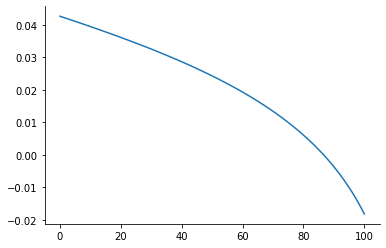

In [457]:
plt.plot(ϕ_avg)

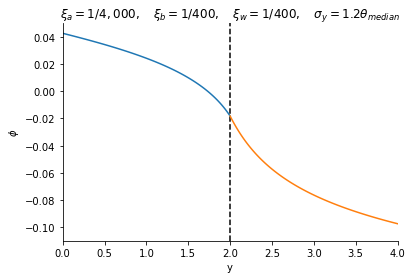

In [464]:
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_avg_list), axis=0, weights=dmg_weight)
# ϕ_bound = np.average(ϕ_avg_list, axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
plt.plot(y_grid[:numy_bar+1], ϕ_avg)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])
plt.vlines(x=2, ymin=-0.11, ymax=0.05, linestyle="dashed", color="black")
plt.xlim(0,4)
plt.ylim(-0.11, 0.05)
plt.ylabel('$\phi$')
plt.xlabel('y')
plt.title(r'$\xi_a = 1/4,000, \quad  \xi_b=1/400, \quad \xi_w = 1/400, \quad \sigma_y = 1.2 θ_{median} $')
plt.savefig("ϕ_2.pdf", facecolor="w", edgecolor='w', bbox_inches="tight")

In [386]:
yt_avg, et_avg, πᵈt_avg, πᶜt_avg, ιt_avg, ht_avg = simulate_jump(y_grid[:numy_bar+1], ems_avg, πᶜ_avg, πᵈ_avg, ι_avg, h_avg, θ_list)

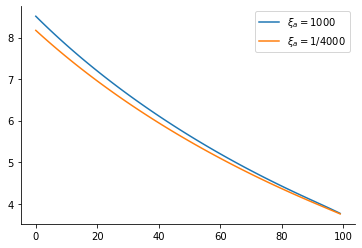

In [387]:
plt.plot(et[et>0], label="$\\xi_a = 1000$")
plt.plot(et_avg, label="$\\xi_a = 1/4000$")
plt.legend()

(0.0, 100.0)

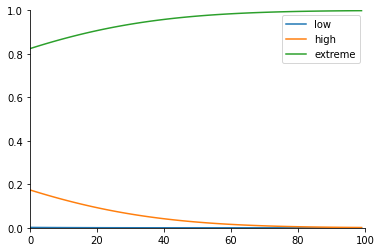

In [465]:
plt.plot(πᵈt_avg[:,0],label='low')
plt.plot(πᵈt_avg[:,1], label="high")
plt.plot(πᵈt_avg[:,2], label="extreme")
plt.legend()
plt.ylim(0,1)
plt.xlim(0,100)

(array([0.02445551, 0.02632012, 0.03798299, 0.05611707, 0.07075756,
        0.08919027, 0.05838843, 0.11004753, 0.15886828, 0.07232224,
        0.09622082, 0.05648816, 0.04171746, 0.05350249, 0.04762108]),
 array([1.0154    , 1.13499133, 1.25458267, 1.374174  , 1.49376533,
        1.61335667, 1.732948  , 1.85253933, 1.97213067, 2.091722  ,
        2.21131333, 2.33090467, 2.450496  , 2.57008733, 2.68967867,
        2.80927   ]),
 <BarContainer object of 15 artists>)

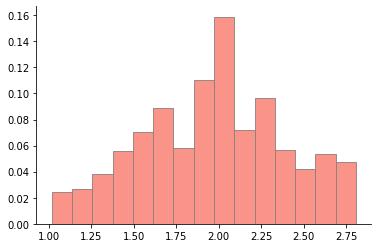

In [389]:
plt.hist(θ_list*1000, weights=πᶜt_avg[-1], alpha=0.6, color='salmon', ec="grey", bins=15)
# plt.hist(θ_list*1000, alpha=0.6, color='skyblue', ec="grey", bins=15)
plt.hist(θ_list*1000, weights=πᶜt_avg[0], alpha=0.6, color='salmon', ec="grey", bins=15)

# partition: carbon and temp

In [390]:
ξₐ = 1/4_000
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θtemp_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ_temp, ems_temp, πᶜ_temp, ι_temp, πᵈ_temp, h_temp, ϕ_temp_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.0017922688425227452,	 ft error: 0.0014353461254682975
episode: 2,	 ode error: 0.0014493034827446041,	 ft error: 0.0012986759826648442
episode: 3,	 ode error: 0.001341359099845658,	 ft error: 0.0012345641076022826
episode: 4,	 ode error: 0.0012717366330104569,	 ft error: 0.0011909078689250358
episode: 5,	 ode error: 0.0012180073718859716,	 ft error: 0.0011559832225773595
episode: 6,	 ode error: 0.0011739688414185267,	 ft error: 0.0011259470122338723
episode: 7,	 ode error: 0.0011369863640275251,	 ft error: 0.0010992407046590377
episode: 8,	 ode error: 0.0011054863342583677,	 ft error: 0.0010751504699649454
episode: 9,	 ode error: 0.0010783142776357522,	 ft error: 0.0010534053040095904
episode: 10,	 ode error: 0.0010545607700116,	 ft error: 0.0010335515525282334
episode: 11,	 ode error: 0.0010335067075582247,	 ft error: 0.0010154025038717376
episode: 12,	 ode error: 0.001014594553564877,	 ft error: 0.000998696859873131
episode: 13,	 ode error: 0.0009973992457211

episode: 161,	 ode error: 0.0003823130162235348,	 ft error: 0.0003817439153485161
episode: 162,	 ode error: 0.0003805481353361741,	 ft error: 0.000379984418708533
episode: 163,	 ode error: 0.00037879436248693034,	 ft error: 0.00037823595620751127
episode: 164,	 ode error: 0.0003770515857628696,	 ft error: 0.00037649841738752327
episode: 165,	 ode error: 0.0003753196950943028,	 ft error: 0.0003747716935953207
episode: 166,	 ode error: 0.0003735985822106698,	 ft error: 0.0003730556779405504
episode: 167,	 ode error: 0.0003718881405985567,	 ft error: 0.0003713502652538554
episode: 168,	 ode error: 0.0003701882654599378,	 ft error: 0.0003696553520470917
episode: 169,	 ode error: 0.0003684988536725998,	 ft error: 0.0003679708364745747
episode: 170,	 ode error: 0.00036681980375118713,	 ft error: 0.000366296618294996
episode: 171,	 ode error: 0.00036515101580970454,	 ft error: 0.0003646325988351564
episode: 172,	 ode error: 0.0003634923915248917,	 ft error: 0.000362978680954242
episode: 173,	

episode: 336,	 ode error: 0.00018335562416020232,	 ft error: 0.00018320307003390213
episode: 337,	 ode error: 0.00018263932964175016,	 ft error: 0.00018248774927965192
episode: 338,	 ode error: 0.00018192624035157285,	 ft error: 0.00018177562645403655
episode: 339,	 ode error: 0.00018121633875695672,	 ft error: 0.00018106668409225332
episode: 340,	 ode error: 0.0001805096074520557,	 ft error: 0.00018036090485560227
episode: 341,	 ode error: 0.0001798060291567107,	 ft error: 0.0001796582715300754
episode: 342,	 ode error: 0.00017910558671502264,	 ft error: 0.0001789587670254315
episode: 343,	 ode error: 0.000178408263094504,	 ft error: 0.00017826237437373882
episode: 344,	 ode error: 0.0001777140413843246,	 ft error: 0.00017756907672817254
episode: 345,	 ode error: 0.00017702290479463395,	 ft error: 0.00017687885736204317
episode: 346,	 ode error: 0.00017633483665502618,	 ft error: 0.00017619169966733944
episode: 347,	 ode error: 0.00017564982041332218,	 ft error: 0.00017550758715368747

episode: 511,	 ode error: 9.500795970977425e-05,	 ft error: 9.495406348478583e-05
episode: 512,	 ode error: 9.466411557563245e-05,	 ft error: 9.46105223335649e-05
episode: 513,	 ode error: 9.432163671807374e-05,	 ft error: 9.426834477211747e-05
episode: 514,	 ode error: 9.398051722705168e-05,	 ft error: 9.392752490927636e-05
episode: 515,	 ode error: 9.364075122954459e-05,	 ft error: 9.358805689083557e-05
episode: 516,	 ode error: 9.330233288971869e-05,	 ft error: 9.324993489985094e-05
episode: 517,	 ode error: 9.296525640835134e-05,	 ft error: 9.291315315573812e-05
episode: 518,	 ode error: 9.262951602299668e-05,	 ft error: 9.257770591468892e-05
episode: 519,	 ode error: 9.229510600752063e-05,	 ft error: 9.224358746937056e-05
episode: 520,	 ode error: 9.196202067224149e-05,	 ft error: 9.191079214857882e-05
episode: 521,	 ode error: 9.163025436338137e-05,	 ft error: 9.157931431707604e-05
episode: 522,	 ode error: 9.129980146314008e-05,	 ft error: 9.1249148375383e-05
episode: 523,	 ode 

episode: 686,	 ode error: 5.137033451617411e-05,	 ft error: 5.1350338382110304e-05
episode: 687,	 ode error: 5.119485950840505e-05,	 ft error: 5.117494933181329e-05
episode: 688,	 ode error: 5.102000835762214e-05,	 ft error: 5.100018328483188e-05
episode: 689,	 ode error: 5.0845778279737523e-05,	 ft error: 5.08260374719229e-05
episode: 690,	 ode error: 5.0672166514544644e-05,	 ft error: 5.065250914787489e-05
episode: 691,	 ode error: 5.049917032582253e-05,	 ft error: 5.0479595591207405e-05
episode: 692,	 ode error: 5.032678700095925e-05,	 ft error: 5.030729410396284e-05
episode: 693,	 ode error: 5.0155013850721104e-05,	 ft error: 5.013560201135951e-05
episode: 694,	 ode error: 4.998384820912834e-05,	 ft error: 4.996451666186101e-05
episode: 695,	 ode error: 4.981328743324399e-05,	 ft error: 4.979403542673677e-05
episode: 696,	 ode error: 4.964332890291948e-05,	 ft error: 4.9624155699807645e-05
episode: 697,	 ode error: 4.947397002034537e-05,	 ft error: 4.9454874897237697e-05
episode: 6

episode: 861,	 ode error: 2.8328078829491536e-05,	 ft error: 2.8317204329951034e-05
episode: 862,	 ode error: 2.8232285170220876e-05,	 ft error: 2.822144544068391e-05
episode: 863,	 ode error: 2.8136819497152216e-05,	 ft error: 2.812601440594272e-05
episode: 864,	 ode error: 2.804168067435187e-05,	 ft error: 2.8030910090246868e-05
episode: 865,	 ode error: 2.7946867569956244e-05,	 ft error: 2.7936131362094052e-05
episode: 866,	 ode error: 2.7852379056018213e-05,	 ft error: 2.7841677094168443e-05
episode: 867,	 ode error: 2.7758214008427313e-05,	 ft error: 2.7747546162785557e-05
episode: 868,	 ode error: 2.766437130709374e-05,	 ft error: 2.7653737448285476e-05
episode: 869,	 ode error: 2.7570849835880035e-05,	 ft error: 2.756024983505597e-05
episode: 870,	 ode error: 2.7477648482494193e-05,	 ft error: 2.7467082211208676e-05
episode: 871,	 ode error: 2.7384766138477293e-05,	 ft error: 2.7374233468833536e-05
episode: 872,	 ode error: 2.72922016993232e-05,	 ft error: 2.7281702503813753e-05

episode: 1036,	 ode error: 1.5693990949445656e-05,	 ft error: 1.568756265684738e-05
episode: 1037,	 ode error: 1.5641317065295942e-05,	 ft error: 1.5634906558453787e-05
episode: 1038,	 ode error: 1.558882223200999e-05,	 ft error: 1.5582429442444666e-05
episode: 1039,	 ode error: 1.5536505833426708e-05,	 ft error: 1.5530130692946918e-05
episode: 1040,	 ode error: 1.548436725547285e-05,	 ft error: 1.547800969616912e-05
episode: 1041,	 ode error: 1.5432405886272845e-05,	 ft error: 1.5426065840355257e-05
episode: 1042,	 ode error: 1.5380621116015884e-05,	 ft error: 1.5374298516085405e-05
episode: 1043,	 ode error: 1.5329012337132633e-05,	 ft error: 1.5322707116090704e-05
episode: 1044,	 ode error: 1.5277578944069073e-05,	 ft error: 1.5271291034860135e-05
episode: 1045,	 ode error: 1.5226320333375839e-05,	 ft error: 1.5220049669450083e-05
episode: 1046,	 ode error: 1.5175235903732288e-05,	 ft error: 1.5168982418651649e-05
episode: 1047,	 ode error: 1.5124325055908446e-05,	 ft error: 1.51180

episode: 1211,	 ode error: 8.733268183215136e-06,	 ft error: 8.72910565638078e-06
episode: 1212,	 ode error: 8.704176818792792e-06,	 ft error: 8.700023319818673e-06
episode: 1213,	 ode error: 8.67518360892145e-06,	 ft error: 8.671039102732075e-06
episode: 1214,	 ode error: 8.646288218160992e-06,	 ft error: 8.642152669879888e-06
episode: 1215,	 ode error: 8.617490312381126e-06,	 ft error: 8.613363687108116e-06
episode: 1216,	 ode error: 8.588789558466804e-06,	 ft error: 8.584671821604273e-06
episode: 1217,	 ode error: 8.560185624602833e-06,	 ft error: 8.556076741573586e-06
episode: 1218,	 ode error: 8.5316781799846e-06,	 ft error: 8.527578116424017e-06
episode: 1219,	 ode error: 8.503266895076877e-06,	 ft error: 8.499175616720016e-06
episode: 1220,	 ode error: 8.47495144135936e-06,	 ft error: 8.470868914043732e-06
episode: 1221,	 ode error: 8.446731491574405e-06,	 ft error: 8.442657681341966e-06
episode: 1222,	 ode error: 8.418606719460967e-06,	 ft error: 8.414541592394187e-06
episode: 

episode: 1380,	 ode error: 4.979251066918565e-06,	 ft error: 4.9762079169327995e-06
episode: 1381,	 ode error: 4.962784680374779e-06,	 ft error: 4.9597461949241195e-06
episode: 1382,	 ode error: 4.9463734514404835e-06,	 ft error: 4.943339612350125e-06
episode: 1383,	 ode error: 4.930017193146966e-06,	 ft error: 4.926987982277013e-06
episode: 1384,	 ode error: 4.913715719040402e-06,	 ft error: 4.910691118210446e-06
episode: 1385,	 ode error: 4.897468843227063e-06,	 ft error: 4.894448834419363e-06
episode: 1386,	 ode error: 4.881276380590055e-06,	 ft error: 4.878260945866594e-06
episode: 1387,	 ode error: 4.865138146520646e-06,	 ft error: 4.862127267908171e-06
episode: 1388,	 ode error: 4.849053957105189e-06,	 ft error: 4.846047616779056e-06
episode: 1389,	 ode error: 4.833023629094977e-06,	 ft error: 4.830021809338707e-06
episode: 1390,	 ode error: 4.817046979837506e-06,	 ft error: 4.814049662932307e-06
episode: 1391,	 ode error: 4.801123827310083e-06,	 ft error: 4.7981309955758e-06
epi

episode: 1548,	 ode error: 2.859855219388384e-06,	 ft error: 2.857386784034984e-06
episode: 1549,	 ode error: 2.850465455765715e-06,	 ft error: 2.847999428304271e-06
episode: 1550,	 ode error: 2.8411069222088886e-06,	 ft error: 2.8386432930858447e-06
episode: 1551,	 ode error: 2.831779513624887e-06,	 ft error: 2.8293182734173694e-06
episode: 1552,	 ode error: 2.822483125119969e-06,	 ft error: 2.820024264243992e-06
episode: 1553,	 ode error: 2.8132176522097877e-06,	 ft error: 2.8107611615054338e-06
episode: 1554,	 ode error: 2.803982990834679e-06,	 ft error: 2.8015288608407296e-06
episode: 1555,	 ode error: 2.7947790372382297e-06,	 ft error: 2.7923272587678425e-06
episode: 1556,	 ode error: 2.7856056880997673e-06,	 ft error: 2.7831562516428265e-06
episode: 1557,	 ode error: 2.7764628402379395e-06,	 ft error: 2.7740157366544045e-06
episode: 1558,	 ode error: 2.7673503909640554e-06,	 ft error: 2.7649056111069457e-06
episode: 1559,	 ode error: 2.758268237978436e-06,	 ft error: 2.7558257726

episode: 50,	 ode error: 0.0006971133914114751,	 ft error: 0.0006942085822954417
episode: 51,	 ode error: 0.0006922482561183628,	 ft error: 0.0006894112231550151
episode: 52,	 ode error: 0.0006874605542049382,	 ft error: 0.0006846884187827867
episode: 53,	 ode error: 0.0006827475870834505,	 ft error: 0.000680037667527434
episode: 54,	 ode error: 0.0006781068064216013,	 ft error: 0.0006754565970570083
episode: 55,	 ode error: 0.0006735358027879048,	 ft error: 0.0006709429564050994
episode: 56,	 ode error: 0.0006690322954201449,	 ft error: 0.0006664946083568639
episode: 57,	 ode error: 0.0006645941229631524,	 ft error: 0.0006621095222500949
episode: 58,	 ode error: 0.0006602192350532852,	 ft error: 0.0006577857672202501
episode: 59,	 ode error: 0.0006559056846501281,	 ft error: 0.0006535215058956802
episode: 60,	 ode error: 0.0006516516210318253,	 ft error: 0.0006493149885187257
episode: 61,	 ode error: 0.0006474552833834817,	 ft error: 0.000645164547491949
episode: 62,	 ode error: 0.000

episode: 204,	 ode error: 0.0003019230556369156,	 ft error: 0.0003011326823953766
episode: 205,	 ode error: 0.0003002453148957826,	 ft error: 0.0002994570748713945
episode: 206,	 ode error: 0.0002985744347884015,	 ft error: 0.00029778839730721285
episode: 207,	 ode error: 0.00029691046918912695,	 ft error: 0.0002961267018865982
episode: 208,	 ode error: 0.00029525347003876007,	 ft error: 0.0002944720388057635
episode: 209,	 ode error: 0.00029360348729578546,	 ft error: 0.00029282445623138775
episode: 210,	 ode error: 0.000291960568896762,	 ft error: 0.00029118400027075553
episode: 211,	 ode error: 0.00029032476072441305,	 ft error: 0.00028955071494571327
episode: 212,	 ode error: 0.00028869610658355,	 ft error: 0.00028792464217744973
episode: 213,	 ode error: 0.0002870746481838857,	 ft error: 0.0002863058217735202
episode: 214,	 ode error: 0.0002854604251295716,	 ft error: 0.00028469429142474745
episode: 215,	 ode error: 0.00028385347491459846,	 ft error: 0.0002830900867060541
episode:

episode: 362,	 ode error: 0.00012204636372426273,	 ft error: 0.00012171873769758572
episode: 363,	 ode error: 0.00012135307885626661,	 ft error: 0.00012102746618681179
episode: 364,	 ode error: 0.00012066385472479367,	 ft error: 0.00012034024190752299
episode: 365,	 ode error: 0.00011997866599075448,	 ft error: 0.00011965703960887623
episode: 366,	 ode error: 0.00011929748747434722,	 ft error: 0.00011897783419876722
episode: 367,	 ode error: 0.00011862029415422317,	 ft error: 0.00011830260074329839
episode: 368,	 ode error: 0.00011794706116675837,	 ft error: 0.00011763131446578443
episode: 369,	 ode error: 0.00011727776380541198,	 ft error: 0.00011696395074672905
episode: 370,	 ode error: 0.00011661237751981455,	 ft error: 0.00011630048512169719
episode: 371,	 ode error: 0.00011595087791497268,	 ft error: 0.00011564089328163867
episode: 372,	 ode error: 0.00011529324075057966,	 ft error: 0.00011498515107166245
episode: 373,	 ode error: 0.00011463944194017276,	 ft error: 0.0001143332344

episode: 524,	 ode error: 4.8931799421015275e-05,	 ft error: 4.87205110985776e-05
episode: 525,	 ode error: 4.865422890271262e-05,	 ft error: 4.844380580212397e-05
episode: 526,	 ode error: 4.837818352321536e-05,	 ft error: 4.816861983824676e-05
episode: 527,	 ode error: 4.810365484248771e-05,	 ft error: 4.7894944818262695e-05
episode: 528,	 ode error: 4.783063446931672e-05,	 ft error: 4.7622772401436274e-05
episode: 529,	 ode error: 4.755911406122994e-05,	 ft error: 4.73520942954192e-05
episode: 530,	 ode error: 4.728908532445101e-05,	 ft error: 4.708290225581095e-05
episode: 531,	 ode error: 4.7020540013707843e-05,	 ft error: 4.6815188086390035e-05
episode: 532,	 ode error: 4.6753469932207586e-05,	 ft error: 4.654894363895212e-05
episode: 533,	 ode error: 4.6487866931455555e-05,	 ft error: 4.6284160813124996e-05
episode: 534,	 ode error: 4.622372291117913e-05,	 ft error: 4.6020831555998454e-05
episode: 535,	 ode error: 4.5961029819232874e-05,	 ft error: 4.575894786270259e-05
episode:

episode: 693,	 ode error: 1.9298923160040738e-05,	 ft error: 2.0689415437235202e-05
episode: 694,	 ode error: 1.9247428533066075e-05,	 ft error: 2.063688061752315e-05
episode: 695,	 ode error: 1.9196055314914986e-05,	 ft error: 2.0584473179457996e-05
episode: 696,	 ode error: 1.9144803249902633e-05,	 ft error: 2.053219283935463e-05
episode: 697,	 ode error: 1.90936720827386e-05,	 ft error: 2.0480039314615027e-05
episode: 698,	 ode error: 1.9042661558521355e-05,	 ft error: 2.0428012324526235e-05
episode: 699,	 ode error: 1.8991771422739633e-05,	 ft error: 2.0376111589543354e-05
episode: 700,	 ode error: 1.8941001421266242e-05,	 ft error: 2.032433683200654e-05
episode: 701,	 ode error: 1.889035130035769e-05,	 ft error: 2.027268777549917e-05
episode: 702,	 ode error: 1.8839820806652993e-05,	 ft error: 2.022116414486519e-05
episode: 703,	 ode error: 1.8789409687166474e-05,	 ft error: 2.0169765667296207e-05
episode: 704,	 ode error: 1.8739117689288665e-05,	 ft error: 2.0118492071452554e-05


episode: 865,	 ode error: 1.2026908460619851e-05,	 ft error: 1.3315476237128292e-05
episode: 866,	 ode error: 1.199284627615514e-05,	 ft error: 1.3281104637048274e-05
episode: 867,	 ode error: 1.1958867290618944e-05,	 ft error: 1.3246817097527694e-05
episode: 868,	 ode error: 1.1924971319651978e-05,	 ft error: 1.3212613415557647e-05
episode: 869,	 ode error: 1.1891158179259172e-05,	 ft error: 1.3178493389089108e-05
episode: 870,	 ode error: 1.1857427685816116e-05,	 ft error: 1.3144456815656718e-05
episode: 871,	 ode error: 1.1823779656065889e-05,	 ft error: 1.3110503493893774e-05
episode: 872,	 ode error: 1.1790213907116352e-05,	 ft error: 1.307663322278052e-05
episode: 873,	 ode error: 1.175673025644234e-05,	 ft error: 1.3042845801632582e-05
episode: 874,	 ode error: 1.172332852188447e-05,	 ft error: 1.3009141030274434e-05
episode: 875,	 ode error: 1.1690008521649849e-05,	 ft error: 1.29755187088428e-05
episode: 876,	 ode error: 1.165677007431047e-05,	 ft error: 1.2941978637913873e-05

episode: 1036,	 ode error: 7.271140519857298e-06,	 ft error: 8.524633266354203e-06
episode: 1037,	 ode error: 7.248866664067127e-06,	 ft error: 8.502314124680482e-06
episode: 1038,	 ode error: 7.226648679994798e-06,	 ft error: 8.480051428005897e-06
episode: 1039,	 ode error: 7.204486435952195e-06,	 ft error: 8.457845007033005e-06
episode: 1040,	 ode error: 7.1823798006112355e-06,	 ft error: 8.435694693736489e-06
episode: 1041,	 ode error: 7.160328643002385e-06,	 ft error: 8.413600321744801e-06
episode: 1042,	 ode error: 7.138332832510832e-06,	 ft error: 8.391561726293906e-06
episode: 1043,	 ode error: 7.116392238871175e-06,	 ft error: 8.36957874447014e-06
episode: 1044,	 ode error: 7.094506732166587e-06,	 ft error: 8.347651214354417e-06
episode: 1045,	 ode error: 7.072676182823658e-06,	 ft error: 8.325778976074616e-06
episode: 1046,	 ode error: 7.050900461605896e-06,	 ft error: 8.303961871285181e-06
episode: 1047,	 ode error: 7.029179439613752e-06,	 ft error: 8.282199743109286e-06
epis

episode: 1207,	 ode error: 4.17617500084782e-06,	 ft error: 5.423646083993946e-06
episode: 1208,	 ode error: 4.161761192964674e-06,	 ft error: 5.4092126259193875e-06
episode: 1209,	 ode error: 4.147384458485961e-06,	 ft error: 5.394816458478373e-06
episode: 1210,	 ode error: 4.133044706517428e-06,	 ft error: 5.380457489742123e-06
episode: 1211,	 ode error: 4.118741846366973e-06,	 ft error: 5.366135627770293e-06
episode: 1212,	 ode error: 4.104475787552179e-06,	 ft error: 5.351850781073568e-06
episode: 1213,	 ode error: 4.0902464397890635e-06,	 ft error: 5.337602858174195e-06
episode: 1214,	 ode error: 4.076053713001325e-06,	 ft error: 5.323391767744767e-06
episode: 1215,	 ode error: 4.061897517316734e-06,	 ft error: 5.309217418700737e-06
episode: 1216,	 ode error: 4.04777776306448e-06,	 ft error: 5.295079720316065e-06
episode: 1217,	 ode error: 4.0336943607756305e-06,	 ft error: 5.280978582026623e-06
episode: 1218,	 ode error: 4.019647221186818e-06,	 ft error: 5.266913913025417e-06
epi

episode: 1379,	 ode error: 2.1732394449685535e-06,	 ft error: 3.4196305539330174e-06
episode: 1380,	 ode error: 2.1640235027154547e-06,	 ft error: 3.4104176040855583e-06
episode: 1381,	 ode error: 2.154831710451195e-06,	 ft error: 3.401228875349327e-06
episode: 1382,	 ode error: 2.1456640072221454e-06,	 ft error: 3.3920643063382423e-06
episode: 1383,	 ode error: 2.136520332222887e-06,	 ft error: 3.382923835805e-06
episode: 1384,	 ode error: 2.127400624792335e-06,	 ft error: 3.3738074024329085e-06
episode: 1385,	 ode error: 2.118304824412086e-06,	 ft error: 3.364714945529775e-06
episode: 1386,	 ode error: 2.109232870707963e-06,	 ft error: 3.3556464041836764e-06
episode: 1387,	 ode error: 2.100184703451017e-06,	 ft error: 3.3466017176792913e-06
episode: 1388,	 ode error: 2.091160262553273e-06,	 ft error: 3.3375808253359915e-06
episode: 1389,	 ode error: 2.082159488071036e-06,	 ft error: 3.3285836668779196e-06
episode: 1390,	 ode error: 2.0731823202036447e-06,	 ft error: 3.319610182225818

episode: 1551,	 ode error: 2.3613202476949397e-06,	 ft error: 2.1448030270455427e-06
episode: 1552,	 ode error: 2.363558809104205e-06,	 ft error: 2.138964265187282e-06
episode: 1553,	 ode error: 2.365794017560681e-06,	 ft error: 2.1331410711885232e-06
episode: 1554,	 ode error: 2.368025870819201e-06,	 ft error: 2.1273334043410883e-06
episode: 1555,	 ode error: 2.3702543666973214e-06,	 ft error: 2.121541224595995e-06
episode: 1556,	 ode error: 2.3724795030705473e-06,	 ft error: 2.1157644916613982e-06
episode: 1557,	 ode error: 2.3747012778744495e-06,	 ft error: 2.1100031656386595e-06
episode: 1558,	 ode error: 2.3769196891025492e-06,	 ft error: 2.104257206305323e-06
episode: 1559,	 ode error: 2.3791347348060474e-06,	 ft error: 2.0985265740056103e-06
episode: 1560,	 ode error: 2.381346413093553e-06,	 ft error: 2.0928112292109557e-06
episode: 1561,	 ode error: 2.3835547221346624e-06,	 ft error: 2.0871111319648956e-06
episode: 1562,	 ode error: 2.38575966015253e-06,	 ft error: 2.0814262426

episode: 122,	 ode error: 0.0006772819278795391,	 ft error: 0.0006775875683893522
episode: 123,	 ode error: 0.0006752611167453783,	 ft error: 0.0006755611573985392
episode: 124,	 ode error: 0.0006732463485164844,	 ft error: 0.000673540880081087
episode: 125,	 ode error: 0.0006712376049231589,	 ft error: 0.0006715267113928624
episode: 126,	 ode error: 0.0006692348677695976,	 ft error: 0.0006695186266150501
episode: 127,	 ode error: 0.0006672381189329435,	 ft error: 0.0006675166013452259
episode: 128,	 ode error: 0.000665247340362052,	 ft error: 0.0006655206115948933
episode: 129,	 ode error: 0.000663262514076218,	 ft error: 0.000663530633801419
episode: 130,	 ode error: 0.0006612836221638308,	 ft error: 0.0006615466448520412
episode: 131,	 ode error: 0.0006593106467809918,	 ft error: 0.0006595686220968455
episode: 132,	 ode error: 0.0006573435701500842,	 ft error: 0.0006575965433651872
episode: 133,	 ode error: 0.0006553823745583371,	 ft error: 0.0006556303869660839
episode: 134,	 ode e

episode: 278,	 ode error: 0.00042500215387570705,	 ft error: 0.0004249779100657288
episode: 279,	 ode error: 0.0004237346740056043,	 ft error: 0.00042371034694767273
episode: 280,	 ode error: 0.0004224709743937417,	 ft error: 0.00042244656846844586
episode: 281,	 ode error: 0.0004212110437542254,	 ft error: 0.00042118656321227244
episode: 282,	 ode error: 0.00041995487083518125,	 ft error: 0.0004199303198047557
episode: 283,	 ode error: 0.0004187024444186753,	 ft error: 0.0004186778268972652
episode: 284,	 ode error: 0.0004174537533205595,	 ft error: 0.000417429073193328
episode: 285,	 ode error: 0.00041620878639038266,	 ft error: 0.00041618404742600756
episode: 286,	 ode error: 0.0004149675325112816,	 ft error: 0.00041494273836458856
episode: 287,	 ode error: 0.00041372998059986427,	 ft error: 0.0004137051348179303
episode: 288,	 ode error: 0.0004124961196061088,	 ft error: 0.000412471225628037
episode: 289,	 ode error: 0.000411265938513243,	 ft error: 0.00041124099967789857
episode: 

episode: 434,	 ode error: 0.00026671006355385345,	 ft error: 0.00026669022115732854
episode: 435,	 ode error: 0.00026591465279824007,	 ft error: 0.0002658948588642185
episode: 436,	 ode error: 0.0002651216141260382,	 ft error: 0.0002651018685238815
episode: 437,	 ode error: 0.0002643309404635276,	 ft error: 0.00026431124306151393
episode: 438,	 ode error: 0.00026354262475808,	 ft error: 0.0002635229754243777
episode: 439,	 ode error: 0.0002627566599781049,	 ft error: 0.00026273705857944124
episode: 440,	 ode error: 0.00026197303911298345,	 ft error: 0.0002619534855148135
episode: 441,	 ode error: 0.00026119175517300684,	 ft error: 0.0002611722492391888
episode: 442,	 ode error: 0.00026041280118931575,	 ft error: 0.0002603933427819394
episode: 443,	 ode error: 0.0002596361702138278,	 ft error: 0.00025961675919639976
episode: 444,	 ode error: 0.0002588618553191885,	 ft error: 0.00025884249155195643
episode: 445,	 ode error: 0.00025808984959870354,	 ft error: 0.0002580705329420045
episode

episode: 590,	 ode error: 0.0001673729593733254,	 ft error: 0.00016735893991588296
episode: 591,	 ode error: 0.0001668737968052662,	 ft error: 0.00016685980427264918
episode: 592,	 ode error: 0.00016637612289056413,	 ft error: 0.00016636215717250047
episode: 593,	 ode error: 0.00016587993318990693,	 ft error: 0.00016586599417523867
episode: 594,	 ode error: 0.00016538522327721962,	 ft error: 0.00016537131085486712
episode: 595,	 ode error: 0.00016489198873962264,	 ft error: 0.00016487810280042353
episode: 596,	 ode error: 0.00016440022517739614,	 ft error: 0.00016438636561149264
episode: 597,	 ode error: 0.00016390992820394074,	 ft error: 0.00016389609490223095
episode: 598,	 ode error: 0.00016342109344573473,	 ft error: 0.00016340728629979373
episode: 599,	 ode error: 0.00016293371654230063,	 ft error: 0.0001629199354433175
episode: 600,	 ode error: 0.00016244779314616097,	 ft error: 0.0001624340379868805
episode: 601,	 ode error: 0.00016196331892280277,	 ft error: 0.00016194958959594

episode: 746,	 ode error: 0.00010503405482870261,	 ft error: 0.00010502313353079792
episode: 747,	 ode error: 0.00010472080827315434,	 ft error: 0.00010470990108373454
episode: 748,	 ode error: 0.00010440849594115691,	 ft error: 0.00010439760280256394
episode: 749,	 ode error: 0.00010409711504665822,	 ft error: 0.00010408623590122772
episode: 750,	 ode error: 0.00010378666281191237,	 ft error: 0.0001037757976024567
episode: 751,	 ode error: 0.00010347713646745955,	 ft error: 0.00010346628513740094
episode: 752,	 ode error: 0.00010316853325209206,	 ft error: 0.0001031576957448895
episode: 753,	 ode error: 0.00010286085041284353,	 ft error: 0.00010285002667189311
episode: 754,	 ode error: 0.00010255408520495142,	 ft error: 0.00010254327517449555
episode: 755,	 ode error: 0.00010224823489184273,	 ft error: 0.00010223743851534943
episode: 756,	 ode error: 0.00010194329674510121,	 ft error: 0.00010193251396746947
episode: 757,	 ode error: 0.00010163926804444671,	 ft error: 0.000101628498810

episode: 902,	 ode error: 6.591387828548559e-05,	 ft error: 6.590459466627545e-05
episode: 903,	 ode error: 6.571730479704575e-05,	 ft error: 6.570802875892809e-05
episode: 904,	 ode error: 6.552131758274691e-05,	 ft error: 6.551204909679975e-05
episode: 905,	 ode error: 6.532591489413612e-05,	 ft error: 6.531665393096539e-05
episode: 906,	 ode error: 6.513109498797241e-05,	 ft error: 6.512184151948505e-05
episode: 907,	 ode error: 6.493685612621661e-05,	 ft error: 6.492761012324064e-05
episode: 908,	 ode error: 6.474319657601222e-05,	 ft error: 6.473395800954407e-05
episode: 909,	 ode error: 6.455011460966933e-05,	 ft error: 6.454088345125841e-05
episode: 910,	 ode error: 6.435760850464871e-05,	 ft error: 6.434838472610394e-05
episode: 911,	 ode error: 6.416567654355049e-05,	 ft error: 6.415646011661189e-05
episode: 912,	 ode error: 6.397431701409516e-05,	 ft error: 6.396510791035574e-05
episode: 913,	 ode error: 6.37835282091113e-05,	 ft error: 6.377432640013633e-05
episode: 914,	 od

episode: 1058,	 ode error: 4.1364690150471825e-05,	 ft error: 4.135630240325224e-05
episode: 1059,	 ode error: 4.12413346113714e-05,	 ft error: 4.123295111032229e-05
episode: 1060,	 ode error: 4.1118346984598316e-05,	 ft error: 4.110996771481783e-05
episode: 1061,	 ode error: 4.099572617289053e-05,	 ft error: 4.0987351119422165e-05
episode: 1062,	 ode error: 4.087347108226117e-05,	 ft error: 4.086510022950167e-05
episode: 1063,	 ode error: 4.075158062198073e-05,	 ft error: 4.074321395564999e-05
episode: 1064,	 ode error: 4.063005370457773e-05,	 ft error: 4.0621691209524746e-05
episode: 1065,	 ode error: 4.050888924581964e-05,	 ft error: 4.050053090722446e-05
episode: 1066,	 ode error: 4.0388086164710926e-05,	 ft error: 4.0379731967715715e-05
episode: 1067,	 ode error: 4.02676433834783e-05,	 ft error: 4.025929331338829e-05
episode: 1068,	 ode error: 4.014755982755945e-05,	 ft error: 4.013921387000889e-05
episode: 1069,	 ode error: 4.002783442560217e-05,	 ft error: 4.001949256607351e-05


episode: 1214,	 ode error: 2.5959438086983885e-05,	 ft error: 2.5951562571818743e-05
episode: 1215,	 ode error: 2.5882029700957264e-05,	 ft error: 2.587415667475631e-05
episode: 1216,	 ode error: 2.5804852192910788e-05,	 ft error: 2.579698164755414e-05
episode: 1217,	 ode error: 2.5727904874256816e-05,	 ft error: 2.5720036801596402e-05
episode: 1218,	 ode error: 2.5651187058462052e-05,	 ft error: 2.5643321449886347e-05
episode: 1219,	 ode error: 2.557469806104039e-05,	 ft error: 2.5566834908757885e-05
episode: 1220,	 ode error: 2.549843719954685e-05,	 ft error: 2.549057649533134e-05
episode: 1221,	 ode error: 2.5422403793570617e-05,	 ft error: 2.5414545529918918e-05
episode: 1222,	 ode error: 2.5346597164732252e-05,	 ft error: 2.5338741333202908e-05
episode: 1223,	 ode error: 2.5271016636673697e-05,	 ft error: 2.5263163229520085e-05
episode: 1224,	 ode error: 2.5195661535056544e-05,	 ft error: 2.5187810544039884e-05
episode: 1225,	 ode error: 2.5120531187549896e-05,	 ft error: 2.511268

episode: 1369,	 ode error: 1.6341055700877733e-05,	 ft error: 1.633348426441361e-05
episode: 1370,	 ode error: 1.6292335314755562e-05,	 ft error: 1.6284765395798338e-05
episode: 1371,	 ode error: 1.6243760244573444e-05,	 ft error: 1.6236191838908676e-05
episode: 1372,	 ode error: 1.619533005692243e-05,	 ft error: 1.618776315960117e-05
episode: 1373,	 ode error: 1.6147044319685068e-05,	 ft error: 1.613947892604532e-05
episode: 1374,	 ode error: 1.6098902602032592e-05,	 ft error: 1.6091338707382073e-05
episode: 1375,	 ode error: 1.60509044744208e-05,	 ft error: 1.6043342074371452e-05
episode: 1376,	 ode error: 1.600304950858788e-05,	 ft error: 1.5995488598143558e-05
episode: 1377,	 ode error: 1.5955337277548344e-05,	 ft error: 1.594777785209519e-05
episode: 1378,	 ode error: 1.5907767355589127e-05,	 ft error: 1.590020941087215e-05
episode: 1379,	 ode error: 1.5860339318269148e-05,	 ft error: 1.5852782849259027e-05
episode: 1380,	 ode error: 1.5813052742409553e-05,	 ft error: 1.5805497745

episode: 1525,	 ode error: 1.1907688103815346e-05,	 ft error: 1.0249278327434386e-05
episode: 1526,	 ode error: 1.1890562298287315e-05,	 ft error: 1.0218706661772419e-05
episode: 1527,	 ode error: 1.1873483310559891e-05,	 ft error: 1.0188226182705762e-05
episode: 1528,	 ode error: 1.1856451017209834e-05,	 ft error: 1.0157836617582147e-05
episode: 1529,	 ode error: 1.1839465295123936e-05,	 ft error: 1.0127537695969746e-05
episode: 1530,	 ode error: 1.1822526021487047e-05,	 ft error: 1.0097329146742847e-05
episode: 1531,	 ode error: 1.1805633073795483e-05,	 ft error: 1.0067210700579848e-05
episode: 1532,	 ode error: 1.178878632983912e-05,	 ft error: 1.0037182089500662e-05
episode: 1533,	 ode error: 1.177198566770612e-05,	 ft error: 1.0007243044507508e-05
episode: 1534,	 ode error: 1.175523096580272e-05,	 ft error: 9.977393298591746e-06
episode: 1535,	 ode error: 1.1738522102823323e-05,	 ft error: 9.947632586086257e-06
episode: 1536,	 ode error: 1.172185895775587e-05,	 ft error: 9.9179606

episode: 1681,	 ode error: 9.732265190676321e-06,	 ft error: 6.43138217001904e-06
episode: 1682,	 ode error: 9.721124940425909e-06,	 ft error: 6.412198251213678e-06
episode: 1683,	 ode error: 9.710015552833229e-06,	 ft error: 6.393071552932931e-06
episode: 1684,	 ode error: 9.698936944687428e-06,	 ft error: 6.374001904711306e-06
episode: 1685,	 ode error: 9.687889032977458e-06,	 ft error: 6.354989137101012e-06
episode: 1686,	 ode error: 9.676871734909183e-06,	 ft error: 6.336033079821594e-06
episode: 1687,	 ode error: 9.66588496790817e-06,	 ft error: 6.317133563749078e-06
episode: 1688,	 ode error: 9.654928649610643e-06,	 ft error: 6.2982904204533785e-06
episode: 1689,	 ode error: 9.644002697864411e-06,	 ft error: 6.2795034814581525e-06
episode: 1690,	 ode error: 9.633107030730828e-06,	 ft error: 6.260772579397278e-06
episode: 1691,	 ode error: 9.622241566476688e-06,	 ft error: 6.242097547320968e-06
episode: 1692,	 ode error: 9.611406223583476e-06,	 ft error: 6.223478218233177e-06
epis

episode: 1837,	 ode error: 8.374894886792325e-06,	 ft error: 4.0356363273374996e-06
episode: 1838,	 ode error: 8.382046080730827e-06,	 ft error: 4.02359838965379e-06
episode: 1839,	 ode error: 8.389177307882126e-06,	 ft error: 4.011596358618105e-06
episode: 1840,	 ode error: 8.396288622769421e-06,	 ft error: 3.999630127417738e-06
episode: 1841,	 ode error: 8.403380079774898e-06,	 ft error: 3.987699589054946e-06
episode: 1842,	 ode error: 8.410451733140243e-06,	 ft error: 3.975804637688467e-06
episode: 1843,	 ode error: 8.417503636962739e-06,	 ft error: 3.9639451660892595e-06
episode: 1844,	 ode error: 8.42453584519272e-06,	 ft error: 3.952121069572545e-06
episode: 1845,	 ode error: 8.431548411647963e-06,	 ft error: 3.940332241649433e-06
episode: 1846,	 ode error: 8.438541389990567e-06,	 ft error: 3.928578577635141e-06
episode: 1847,	 ode error: 8.445514833744055e-06,	 ft error: 3.91685997233604e-06
episode: 1848,	 ode error: 8.452468796295789e-06,	 ft error: 3.905176321576202e-06
episo

episode: 1993,	 ode error: 9.279755758702125e-06,	 ft error: 2.5323076305779533e-06
episode: 1994,	 ode error: 9.284370107634415e-06,	 ft error: 2.5247538652332464e-06
episode: 1995,	 ode error: 9.288971462223636e-06,	 ft error: 2.5172226320036017e-06
episode: 1996,	 ode error: 9.293559858431473e-06,	 ft error: 2.5097138631654157e-06
episode: 1997,	 ode error: 9.298135332124852e-06,	 ft error: 2.502227492244084e-06
episode: 1998,	 ode error: 9.302697919071805e-06,	 ft error: 2.494763451886077e-06
episode: 1999,	 ode error: 9.307247654938899e-06,	 ft error: 2.487321675385494e-06
episode: 2000,	 ode error: 9.311784575297748e-06,	 ft error: 2.4799020969153616e-06
episode: 2001,	 ode error: 9.316308715634874e-06,	 ft error: 2.4725046502786325e-06
episode: 2002,	 ode error: 9.320820111329811e-06,	 ft error: 2.465129268445591e-06
episode: 2003,	 ode error: 9.325318797664357e-06,	 ft error: 2.4577758869307837e-06
episode: 2004,	 ode error: 9.329804809837824e-06,	 ft error: 2.450444439213347e-

episode: 61,	 ode error: 0.048680653598931506,	 ft error: 0.009505970120733075
episode: 62,	 ode error: 0.04883123640797607,	 ft error: 0.009168730700029165
episode: 63,	 ode error: 0.04899501058887228,	 ft error: 0.008941692316019925
episode: 64,	 ode error: 0.04917625502620654,	 ft error: 0.008932718969738088
episode: 65,	 ode error: 0.04938014824761496,	 ft error: 0.008924262148329795
episode: 66,	 ode error: 0.04961316700606209,	 ft error: 0.008916354709867213
episode: 67,	 ode error: 0.04988380256992437,	 ft error: 0.008909090593588766
episode: 68,	 ode error: 0.05020366213634728,	 ft error: 0.008902493032982897
episode: 69,	 ode error: 0.05058919723791688,	 ft error: 0.008896606712554222
episode: 70,	 ode error: 0.051064546536402085,	 ft error: 0.008891460848233293
episode: 71,	 ode error: 0.05166646133041631,	 ft error: 0.008887051746481583
episode: 72,	 ode error: 0.05245333246480968,	 ft error: 0.008883285923146425
episode: 73,	 ode error: 0.05352286229078432,	 ft error: 0.008

episode: 220,	 ode error: 0.00024779552428528986,	 ft error: 0.0002467450862829688
episode: 221,	 ode error: 0.0002460046680218609,	 ft error: 0.0002449607674095735
episode: 222,	 ode error: 0.0002442255259074936,	 ft error: 0.0002431881067675029
episode: 223,	 ode error: 0.00024245800985530491,	 ft error: 0.00024142701687629442
episode: 224,	 ode error: 0.0002407020325952187,	 ft error: 0.0002396774110719156
episode: 225,	 ode error: 0.00023895750767035403,	 ft error: 0.0002379392034999872
episode: 226,	 ode error: 0.00023722434943306123,	 ft error: 0.00023621230911217522
episode: 227,	 ode error: 0.0002355024730404981,	 ft error: 0.00023449664366186526
episode: 228,	 ode error: 0.00023379179444996524,	 ft error: 0.00023279212369863486
episode: 229,	 ode error: 0.00023209223041361618,	 ft error: 0.0002310986665618233
episode: 230,	 ode error: 0.000230403698473096,	 ft error: 0.00022941619037680772
episode: 231,	 ode error: 0.00022872611695372812,	 ft error: 0.00022774461404836505
epis

episode: 383,	 ode error: 6.638073905703779e-05,	 ft error: 6.548866948327681e-05
episode: 384,	 ode error: 6.575644073422953e-05,	 ft error: 6.486034380667287e-05
episode: 385,	 ode error: 6.513631994933312e-05,	 ft error: 6.423621998596918e-05
episode: 386,	 ode error: 6.452035561555489e-05,	 ft error: 6.361627692362075e-05
episode: 387,	 ode error: 6.390852681667513e-05,	 ft error: 6.30004936925018e-05
episode: 388,	 ode error: 6.330081280561586e-05,	 ft error: 6.238884953717791e-05
episode: 389,	 ode error: 6.269719300327462e-05,	 ft error: 6.178132386944202e-05
episode: 390,	 ode error: 6.209764699704307e-05,	 ft error: 6.117789626967907e-05
episode: 391,	 ode error: 6.150215453960156e-05,	 ft error: 6.057854648372034e-05
episode: 392,	 ode error: 6.091069554753543e-05,	 ft error: 5.998325442233462e-05
episode: 393,	 ode error: 6.032325010001463e-05,	 ft error: 5.9392000159932956e-05
episode: 394,	 ode error: 5.973979843757718e-05,	 ft error: 5.880476393290331e-05
episode: 395,	 o

episode: 545,	 ode error: 5.156809741577817e-05,	 ft error: 7.377052729911257e-06
episode: 546,	 ode error: 5.156810021968347e-05,	 ft error: 7.2348839967364044e-06
episode: 547,	 ode error: 5.156810274415603e-05,	 ft error: 7.094714612326802e-06
episode: 548,	 ode error: 5.156810498939586e-05,	 ft error: 6.956530754313277e-06
episode: 549,	 ode error: 5.156810695642408e-05,	 ft error: 6.8203185098203445e-06
episode: 550,	 ode error: 5.156810865822481e-05,	 ft error: 6.686063875905683e-06
episode: 551,	 ode error: 5.156811009663941e-05,	 ft error: 6.55375275919005e-06
episode: 552,	 ode error: 5.156811127435826e-05,	 ft error: 6.423370976574305e-06
episode: 553,	 ode error: 5.1568112197796686e-05,	 ft error: 6.294904255146894e-06
episode: 554,	 ode error: 5.156811287917987e-05,	 ft error: 6.168338233155287e-06
episode: 555,	 ode error: 5.156811331909726e-05,	 ft error: 6.0436584605842265e-06
episode: 556,	 ode error: 5.1568113525096704e-05,	 ft error: 5.920850399040075e-06
episode: 557

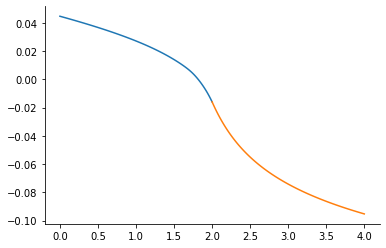

In [391]:
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_temp_list), axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
plt.plot(y_grid[:numy_bar+1], ϕ_temp)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [392]:
yt_temp, et_temp, πᵈt_temp, πᶜt_temp, ιt_temp, ht_temp = simulate_jump(y_grid[:numy_bar+1], ems_temp, πᶜ_temp, πᵈ_temp, ι_temp, h_temp, θtemp_list)

In [393]:
ξₐ = 1/4_000
dmg_weight = np.array([0.475, 0.475, 0.05])
args = (δ, η, θcarb_list, γ1, γ2, γ3_list, dmg_weight, ς, ξₘ, ξₐ, ξ, σy)
ϕ_carb, ems_carb, πᶜ_carb, ι_carb, πᵈ_carb, h_carb, ϕ_carb_list = solve_jump(y_grid, numy_bar, args, tol=2e-6)

episode: 1,	 ode error: 0.0017968336813708316,	 ft error: 0.0014404249890431595
episode: 2,	 ode error: 0.0014576810621416394,	 ft error: 0.0013073621785973373
episode: 3,	 ode error: 0.001347419767083684,	 ft error: 0.0012425198643410261
episode: 4,	 ode error: 0.0012780031950608776,	 ft error: 0.0011985740195372947
episode: 5,	 ode error: 0.0012247315716268786,	 ft error: 0.001163557210053984
episode: 6,	 ode error: 0.0011810912505349118,	 ft error: 0.0011335255604077211
episode: 7,	 ode error: 0.0011443920682627463,	 ft error: 0.0011068609305298419
episode: 8,	 ode error: 0.0011130681914286878,	 ft error: 0.0010828133438289668
episode: 9,	 ode error: 0.0010859917089198622,	 ft error: 0.0010610976141129274
episode: 10,	 ode error: 0.0010622806155747267,	 ft error: 0.001041259119569205
episode: 11,	 ode error: 0.0010412371487393316,	 ft error: 0.001023109750641738
episode: 12,	 ode error: 0.0010223179752648103,	 ft error: 0.0010063990388578135
episode: 13,	 ode error: 0.00100510660916

episode: 165,	 ode error: 0.0003802102443668803,	 ft error: 0.0003796605248809181
episode: 166,	 ode error: 0.0003784746101438409,	 ft error: 0.0003779299798300819
episode: 167,	 ode error: 0.00037674968744117506,	 ft error: 0.0003762100782297532
episode: 168,	 ode error: 0.00037503537143285465,	 ft error: 0.0003745007165574521
episode: 169,	 ode error: 0.000373331558965901,	 ft error: 0.0003728017929301627
episode: 170,	 ode error: 0.00037163814852149424,	 ft error: 0.0003711132070668514
episode: 171,	 ode error: 0.0003699550401773168,	 ft error: 0.00036943486025229255
episode: 172,	 ode error: 0.0003682821355715923,	 ft error: 0.0003677666553011707
episode: 173,	 ode error: 0.0003666193378673553,	 ft error: 0.00036610849652405725
episode: 174,	 ode error: 0.00036496655171850626,	 ft error: 0.00036446028969396493
episode: 175,	 ode error: 0.0003633236832361719,	 ft error: 0.00036282194201375795
episode: 176,	 ode error: 0.00036169063995686464,	 ft error: 0.000361193362084881
episode: 

episode: 343,	 ode error: 0.0001812793379868796,	 ft error: 0.00018113152315618608
episode: 344,	 ode error: 0.00018057652392501156,	 ft error: 0.00018042963372259802
episode: 345,	 ode error: 0.00017987682070394917,	 ft error: 0.00017973084828928437
episode: 346,	 ode error: 0.00017918021157713908,	 ft error: 0.0001790351501721373
episode: 347,	 ode error: 0.00017848667991661742,	 ft error: 0.0001783425228048021
episode: 348,	 ode error: 0.00017779620921192397,	 ft error: 0.00017765294973763612
episode: 349,	 ode error: 0.00017710878306882358,	 ft error: 0.00017696641463678386
episode: 350,	 ode error: 0.00017642438520817471,	 ft error: 0.0001762829012825808
episode: 351,	 ode error: 0.00017574299946506225,	 ft error: 0.0001756023935688365
episode: 352,	 ode error: 0.00017506460978719573,	 ft error: 0.00017492487550160862
episode: 353,	 ode error: 0.00017438920023463437,	 ft error: 0.0001742503311982548
episode: 354,	 ode error: 0.0001737167549777772,	 ft error: 0.0001735787448861372


episode: 527,	 ode error: 9.132139644203111e-05,	 ft error: 9.127031482016046e-05
episode: 528,	 ode error: 9.099376164551243e-05,	 ft error: 9.094295856063028e-05
episode: 529,	 ode error: 9.066741674401647e-05,	 ft error: 9.061689080096247e-05
episode: 530,	 ode error: 9.034235635346972e-05,	 ft error: 9.029210617422327e-05
episode: 531,	 ode error: 9.001857512354382e-05,	 ft error: 8.996859934722509e-05
episode: 532,	 ode error: 8.96960677372378e-05,	 ft error: 8.964636501980947e-05
episode: 533,	 ode error: 8.937482891040161e-05,	 ft error: 8.93253979244076e-05
episode: 534,	 ode error: 8.905485339154827e-05,	 ft error: 8.900569282597101e-05
episode: 535,	 ode error: 8.873613596153409e-05,	 ft error: 8.86872445214626e-05
episode: 536,	 ode error: 8.841867143302912e-05,	 ft error: 8.837004783925537e-05
episode: 537,	 ode error: 8.810245465015276e-05,	 ft error: 8.805409763915548e-05
episode: 538,	 ode error: 8.778748048817039e-05,	 ft error: 8.773938881163901e-05
episode: 539,	 ode 

episode: 710,	 ode error: 4.828257554183768e-05,	 ft error: 4.826262503252373e-05
episode: 711,	 ode error: 4.811849370427981e-05,	 ft error: 4.809861263134023e-05
episode: 712,	 ode error: 4.79549836180233e-05,	 ft error: 4.7935171443626766e-05
episode: 713,	 ode error: 4.77920429850276e-05,	 ft error: 4.777229918206949e-05
episode: 714,	 ode error: 4.762966952515178e-05,	 ft error: 4.760999357684056e-05
episode: 715,	 ode error: 4.7467860975992796e-05,	 ft error: 4.7448252376014466e-05
episode: 716,	 ode error: 4.730661509274919e-05,	 ft error: 4.728707334471227e-05
episode: 717,	 ode error: 4.714592964781192e-05,	 ft error: 4.712645426510158e-05
episode: 718,	 ode error: 4.698580243032123e-05,	 ft error: 4.696639293600332e-05
episode: 719,	 ode error: 4.6826231246258824e-05,	 ft error: 4.680688717270676e-05
episode: 720,	 ode error: 4.6667213917760044e-05,	 ft error: 4.6647934806622514e-05
episode: 721,	 ode error: 4.650874828329417e-05,	 ft error: 4.64895336850744e-05
episode: 722,

episode: 894,	 ode error: 2.5886158098243836e-05,	 ft error: 2.587457339639036e-05
episode: 895,	 ode error: 2.579896353191197e-05,	 ft error: 2.578740957132064e-05
episode: 896,	 ode error: 2.5712066415165035e-05,	 ft error: 2.5700543078826153e-05
episode: 897,	 ode error: 2.5625465721121647e-05,	 ft error: 2.5613972892505703e-05
episode: 898,	 ode error: 2.553916042661035e-05,	 ft error: 2.5527697989520075e-05
episode: 899,	 ode error: 2.545314951204168e-05,	 ft error: 2.544171735070766e-05
episode: 900,	 ode error: 2.536743196119044e-05,	 ft error: 2.535602996026065e-05
episode: 901,	 ode error: 2.5282006761510466e-05,	 ft error: 2.527063480618763e-05
episode: 902,	 ode error: 2.519687290396971e-05,	 ft error: 2.5185530879781592e-05
episode: 903,	 ode error: 2.511202938307582e-05,	 ft error: 2.5100717175966885e-05
episode: 904,	 ode error: 2.5027475196762313e-05,	 ft error: 2.501619269316043e-05
episode: 905,	 ode error: 2.4943209346549788e-05,	 ft error: 2.4931956433179213e-05
epis

episode: 1078,	 ode error: 1.3948019956316502e-05,	 ft error: 1.3940500936092856e-05
episode: 1079,	 ode error: 1.3901411254229972e-05,	 ft error: 1.3893907387096949e-05
episode: 1080,	 ode error: 1.3854960322967299e-05,	 ft error: 1.3847471550439602e-05
episode: 1081,	 ode error: 1.3808666621785361e-05,	 ft error: 1.380119288551159e-05
episode: 1082,	 ode error: 1.3762529611777781e-05,	 ft error: 1.3755070853739098e-05
episode: 1083,	 ode error: 1.3716548755891844e-05,	 ft error: 1.3709104918306163e-05
episode: 1084,	 ode error: 1.3670723519038e-05,	 ft error: 1.3663294544200937e-05
episode: 1085,	 ode error: 1.362505336787779e-05,	 ft error: 1.3617639198516367e-05
episode: 1086,	 ode error: 1.3579537770941818e-05,	 ft error: 1.3572138349779439e-05
episode: 1087,	 ode error: 1.3534176198629197e-05,	 ft error: 1.3526791468691329e-05
episode: 1088,	 ode error: 1.3488968123070728e-05,	 ft error: 1.3481598027711058e-05
episode: 1089,	 ode error: 1.3443913018438116e-05,	 ft error: 1.343655

episode: 1257,	 ode error: 7.679177221279012e-06,	 ft error: 7.67361749626679e-06
episode: 1258,	 ode error: 7.653716067719811e-06,	 ft error: 7.64816390085484e-06
episode: 1259,	 ode error: 7.6283404416835e-06,	 ft error: 7.622795803579238e-06
episode: 1260,	 ode error: 7.6030500523725265e-06,	 ft error: 7.597512913584681e-06
episode: 1261,	 ode error: 7.577844609725731e-06,	 ft error: 7.57231494117235e-06
episode: 1262,	 ode error: 7.552723824805728e-06,	 ft error: 7.547201597244794e-06
episode: 1263,	 ode error: 7.527687409615135e-06,	 ft error: 7.522172594184862e-06
episode: 1264,	 ode error: 7.502735077249555e-06,	 ft error: 7.497227644976771e-06
episode: 1265,	 ode error: 7.477866541723667e-06,	 ft error: 7.472366463784352e-06
episode: 1266,	 ode error: 7.453081518005167e-06,	 ft error: 7.44758876585853e-06
episode: 1267,	 ode error: 7.4283797220210494e-06,	 ft error: 7.422894267051598e-06
episode: 1268,	 ode error: 7.403760870816991e-06,	 ft error: 7.398282684580501e-06
episode:

episode: 1440,	 ode error: 4.191942107617248e-06,	 ft error: 4.1873719595908465e-06
episode: 1441,	 ode error: 4.178154179201496e-06,	 ft error: 4.17358772030844e-06
episode: 1442,	 ode error: 4.16441220560935e-06,	 ft error: 4.159849421453421e-06
episode: 1443,	 ode error: 4.15071603176065e-06,	 ft error: 4.146156907872123e-06
episode: 1444,	 ode error: 4.137065503163851e-06,	 ft error: 4.132510025197286e-06
episode: 1445,	 ode error: 4.1234604655875085e-06,	 ft error: 4.118908619223557e-06
episode: 1446,	 ode error: 4.109900765652467e-06,	 ft error: 4.105352536531992e-06
episode: 1447,	 ode error: 4.096386250314918e-06,	 ft error: 4.09184162423563e-06
episode: 1448,	 ode error: 4.082916767091257e-06,	 ft error: 4.07837572995636e-06
episode: 1449,	 ode error: 4.069492163991518e-06,	 ft error: 4.064954701755534e-06
episode: 1450,	 ode error: 4.056112289653382e-06,	 ft error: 4.0515783881570995e-06
episode: 1451,	 ode error: 4.042776993078167e-06,	 ft error: 4.038246638425151e-06
episod

episode: 1624,	 ode error: 2.291976111378001e-06,	 ft error: 2.28788952126117e-06
episode: 1625,	 ode error: 2.284498826351394e-06,	 ft error: 2.2804140190300455e-06
episode: 1626,	 ode error: 2.2770462709294356e-06,	 ft error: 2.2729632391758443e-06
episode: 1627,	 ode error: 2.2696183621994997e-06,	 ft error: 2.2655370990100807e-06
episode: 1628,	 ode error: 2.2622150176792796e-06,	 ft error: 2.258135516191214e-06
episode: 1629,	 ode error: 2.2548361551921053e-06,	 ft error: 2.250758408169536e-06
episode: 1630,	 ode error: 2.2474816926144328e-06,	 ft error: 2.2434056933205255e-06
episode: 1631,	 ode error: 2.240151548330558e-06,	 ft error: 2.236077289742104e-06
episode: 1632,	 ode error: 2.232845640971542e-06,	 ft error: 2.2287731162029534e-06
episode: 1633,	 ode error: 2.2255638893651196e-06,	 ft error: 2.221493091494886e-06
episode: 1634,	 ode error: 2.2183062126174486e-06,	 ft error: 2.2142371348723064e-06
episode: 1635,	 ode error: 2.211072530054238e-06,	 ft error: 2.207005165589

episode: 117,	 ode error: 0.0004784255024545812,	 ft error: 0.00047737657791690574
episode: 118,	 ode error: 0.0004760187363332804,	 ft error: 0.0004749813725429819
episode: 119,	 ode error: 0.00047362926597999697,	 ft error: 0.0004726031369951811
episode: 120,	 ode error: 0.0004712567651191029,	 ft error: 0.00047024154651503086
episode: 121,	 ode error: 0.00046890090721953134,	 ft error: 0.0004678962758161478
episode: 122,	 ode error: 0.0004665613653332204,	 ft error: 0.0004655669989454941
episode: 123,	 ode error: 0.0004642378119697106,	 ft error: 0.0004632533891951382
episode: 124,	 ode error: 0.0004619299190118133,	 ft error: 0.0004609551190631195
episode: 125,	 ode error: 0.0004596373576751466,	 ft error: 0.00045867186026575296
episode: 126,	 ode error: 0.00045735979851454416,	 ft error: 0.000456403283792863
episode: 127,	 ode error: 0.0004550969114783958,	 ft error: 0.0004541490600230384
episode: 128,	 ode error: 0.00045284836601226374,	 ft error: 0.00045190885887801124
episode: 

episode: 285,	 ode error: 0.0001933566852842446,	 ft error: 0.00019285384401039607
episode: 286,	 ode error: 0.00019224839226908712,	 ft error: 0.00019175809927285867
episode: 287,	 ode error: 0.0001911458090230379,	 ft error: 0.00019066958439832582
episode: 288,	 ode error: 0.00019004880349739086,	 ft error: 0.00018958877763472493
episode: 289,	 ode error: 0.00018895720144153686,	 ft error: 0.000188516517799243
episode: 290,	 ode error: 0.00018787075994007672,	 ft error: 0.00018745439465244856
episode: 291,	 ode error: 0.00018678951328471207,	 ft error: 0.00018627283321544694
episode: 292,	 ode error: 0.00018571732379060399,	 ft error: 0.00018532264706119794
episode: 293,	 ode error: 0.0001846492104017628,	 ft error: 0.00018413974977017633
episode: 294,	 ode error: 0.00018359047227187013,	 ft error: 0.00018308627308685765
episode: 295,	 ode error: 0.00018253979365577403,	 ft error: 0.0001820401228866166
episode: 296,	 ode error: 0.0001814961217311645,	 ft error: 0.00018111123409947824

episode: 455,	 ode error: 7.436082997760356e-05,	 ft error: 7.40820360648394e-05
episode: 456,	 ode error: 7.394838700084554e-05,	 ft error: 7.367100879662285e-05
episode: 457,	 ode error: 7.353819624179706e-05,	 ft error: 7.32622217858997e-05
episode: 458,	 ode error: 7.313024564675958e-05,	 ft error: 7.285566315855715e-05
episode: 459,	 ode error: 7.272452320442057e-05,	 ft error: 7.245132107735105e-05
episode: 460,	 ode error: 7.232101694706699e-05,	 ft error: 7.20491837436175e-05
episode: 461,	 ode error: 7.191971495151134e-05,	 ft error: 7.164923939817491e-05
episode: 462,	 ode error: 7.152060534019187e-05,	 ft error: 7.12514763228043e-05
episode: 463,	 ode error: 7.112367628200867e-05,	 ft error: 7.085588284129012e-05
episode: 464,	 ode error: 7.072891599324256e-05,	 ft error: 7.046244732062298e-05
episode: 465,	 ode error: 7.033631273829105e-05,	 ft error: 7.007115817173985e-05
episode: 466,	 ode error: 6.994585483039687e-05,	 ft error: 6.968200385049547e-05
episode: 467,	 ode e

episode: 633,	 ode error: 2.7514329494039767e-05,	 ft error: 2.727513554783012e-05
episode: 634,	 ode error: 2.7360166229367655e-05,	 ft error: 2.712042601146769e-05
episode: 635,	 ode error: 2.7206807654491243e-05,	 ft error: 2.696652323814127e-05
episode: 636,	 ode error: 2.705424952747365e-05,	 ft error: 2.681342298203419e-05
episode: 637,	 ode error: 2.6902487617577373e-05,	 ft error: 2.666112100824699e-05
episode: 638,	 ode error: 2.675151770586612e-05,	 ft error: 2.6509613093722573e-05
episode: 639,	 ode error: 2.6601335585767195e-05,	 ft error: 2.635889502719998e-05
episode: 640,	 ode error: 2.645193706375497e-05,	 ft error: 2.620896261044022e-05
episode: 641,	 ode error: 2.630331795984084e-05,	 ft error: 2.6059811658295705e-05
episode: 642,	 ode error: 2.6155474108212795e-05,	 ft error: 2.591143799984356e-05
episode: 643,	 ode error: 2.6008401357797907e-05,	 ft error: 2.5763837478547567e-05
episode: 644,	 ode error: 2.586209557272896e-05,	 ft error: 2.5617005952766985e-05
episo

episode: 817,	 ode error: 1.3057534428760165e-05,	 ft error: 1.4324846596350482e-05
episode: 818,	 ode error: 1.3021460237077706e-05,	 ft error: 1.4288385719897028e-05
episode: 819,	 ode error: 1.2985472025934681e-05,	 ft error: 1.4252013241025652e-05
episode: 820,	 ode error: 1.2949569610772138e-05,	 ft error: 1.4215728907050751e-05
episode: 821,	 ode error: 1.2913752807476705e-05,	 ft error: 1.4179532468004455e-05
episode: 822,	 ode error: 1.2878021432381363e-05,	 ft error: 1.4143423674439309e-05
episode: 823,	 ode error: 1.2842375302253884e-05,	 ft error: 1.4107402279203476e-05
episode: 824,	 ode error: 1.2806814234303298e-05,	 ft error: 1.407146803588527e-05
episode: 825,	 ode error: 1.2771338046171042e-05,	 ft error: 1.4035620700732915e-05
episode: 826,	 ode error: 1.2735946555928655e-05,	 ft error: 1.3999860030705868e-05
episode: 827,	 ode error: 1.2700639582073769e-05,	 ft error: 1.3964185785157504e-05
episode: 828,	 ode error: 1.2665416943530457e-05,	 ft error: 1.39285977242796

episode: 1000,	 ode error: 7.717525977410627e-06,	 ft error: 8.936915087698801e-06
episode: 1001,	 ode error: 7.694427413224237e-06,	 ft error: 8.913736595540789e-06
episode: 1002,	 ode error: 7.671385894029948e-06,	 ft error: 8.890616244710178e-06
episode: 1003,	 ode error: 7.648401288078794e-06,	 ft error: 8.867553855003893e-06
episode: 1004,	 ode error: 7.625473463992874e-06,	 ft error: 8.844549247606637e-06
episode: 1005,	 ode error: 7.6026022907628085e-06,	 ft error: 8.821602245114024e-06
episode: 1006,	 ode error: 7.579787637747114e-06,	 ft error: 8.798712671440057e-06
episode: 1007,	 ode error: 7.557029374664507e-06,	 ft error: 8.775880351909645e-06
episode: 1008,	 ode error: 7.534327371593578e-06,	 ft error: 8.753105113674942e-06
episode: 1009,	 ode error: 7.5116814989702695e-06,	 ft error: 8.730386784905805e-06
episode: 1010,	 ode error: 7.489091627579692e-06,	 ft error: 8.707725195668722e-06
episode: 1011,	 ode error: 7.4665576285594295e-06,	 ft error: 8.685120177117275e-06
e

episode: 1183,	 ode error: 4.320713704904867e-06,	 ft error: 5.530113745509657e-06
episode: 1184,	 ode error: 4.306128467558215e-06,	 ft error: 5.5154968916249865e-06
episode: 1185,	 ode error: 4.291580351665017e-06,	 ft error: 5.5009174251482995e-06
episode: 1186,	 ode error: 4.277069267757396e-06,	 ft error: 5.4863752553073e-06
episode: 1187,	 ode error: 4.262595126561334e-06,	 ft error: 5.471870291410645e-06
episode: 1188,	 ode error: 4.248157838999402e-06,	 ft error: 5.457402443252712e-06
episode: 1189,	 ode error: 4.23375731618616e-06,	 ft error: 5.4429716203850216e-06
episode: 1190,	 ode error: 4.219393469434384e-06,	 ft error: 5.428577732937331e-06
episode: 1191,	 ode error: 4.20506621024889e-06,	 ft error: 5.4142206908081025e-06
episode: 1192,	 ode error: 4.190775450328677e-06,	 ft error: 5.3999004044856065e-06
episode: 1193,	 ode error: 4.176521101566e-06,	 ft error: 5.385616784585323e-06
episode: 1194,	 ode error: 4.1623030760475944e-06,	 ft error: 5.371369741456744e-06
episo

episode: 1366,	 ode error: 2.1882160387843013e-06,	 ft error: 3.3950178219300615e-06
episode: 1367,	 ode error: 2.1791157295143987e-06,	 ft error: 3.3859154261485043e-06
episode: 1368,	 ode error: 2.170039096316775e-06,	 ft error: 3.3768367941356776e-06
episode: 1369,	 ode error: 2.160986080099322e-06,	 ft error: 3.367781866147705e-06
episode: 1370,	 ode error: 2.1519566219049954e-06,	 ft error: 3.3587505830536455e-06
episode: 1371,	 ode error: 2.142950662916912e-06,	 ft error: 3.3497428850633635e-06
episode: 1372,	 ode error: 2.1339681444551225e-06,	 ft error: 3.3407587130227885e-06
episode: 1373,	 ode error: 2.1250090079751494e-06,	 ft error: 3.331798008252007e-06
episode: 1374,	 ode error: 2.116073195069856e-06,	 ft error: 3.3228607113425235e-06
episode: 1375,	 ode error: 2.1071606474700702e-06,	 ft error: 3.3139467636028597e-06
episode: 1376,	 ode error: 2.098271307040601e-06,	 ft error: 3.305056106549705e-06
episode: 1377,	 ode error: 2.0894051157830827e-06,	 ft error: 3.296188681

episode: 1549,	 ode error: 2.412709268715947e-06,	 ft error: 2.0709535441855906e-06
episode: 1550,	 ode error: 2.4147075100577095e-06,	 ft error: 2.0653346999646716e-06
episode: 1551,	 ode error: 2.4167031303715114e-06,	 ft error: 2.0597307650559635e-06
episode: 1552,	 ode error: 2.418696125139428e-06,	 ft error: 2.05414170124929e-06
episode: 1553,	 ode error: 2.4206864899131947e-06,	 ft error: 2.048567470161004e-06
episode: 1554,	 ode error: 2.4226742203102493e-06,	 ft error: 2.043008033765966e-06
episode: 1555,	 ode error: 2.424659312013624e-06,	 ft error: 2.037463353749917e-06
episode: 1556,	 ode error: 2.4266417607783967e-06,	 ft error: 2.031933392515617e-06
episode: 1557,	 ode error: 2.428621562419167e-06,	 ft error: 2.026418111795066e-06
episode: 1558,	 ode error: 2.430598712818081e-06,	 ft error: 2.020917473944765e-06
episode: 1559,	 ode error: 2.4325732079194095e-06,	 ft error: 2.0154314412171304e-06
episode: 1560,	 ode error: 2.4345450437342642e-06,	 ft error: 2.00995997610744

episode: 142,	 ode error: 0.0006327541319363467,	 ft error: 0.000632976046851345
episode: 143,	 ode error: 0.0006308664066632221,	 ft error: 0.0006310832331036844
episode: 144,	 ode error: 0.000628984325961833,	 ft error: 0.0006291960915952068
episode: 145,	 ode error: 0.0006271078729155621,	 ft error: 0.000627314606302364
episode: 146,	 ode error: 0.0006252370306546421,	 ft error: 0.0006254387615564396
episode: 147,	 ode error: 0.0006233717823551849,	 ft error: 0.0006235685420139433
episode: 148,	 ode error: 0.0006215121112383224,	 ft error: 0.0006217039326191637
episode: 149,	 ode error: 0.0006196580005694713,	 ft error: 0.0006198449185616333
episode: 150,	 ode error: 0.000617809433657605,	 ft error: 0.0006179914852757346
episode: 151,	 ode error: 0.0006159663938547921,	 ft error: 0.0006161436183495008
episode: 152,	 ode error: 0.0006141288645556771,	 ft error: 0.0006143013035453393
episode: 153,	 ode error: 0.0006122968291971879,	 ft error: 0.0006124645267234496
episode: 154,	 ode e

episode: 307,	 ode error: 0.00038654326653485044,	 ft error: 0.00038651574727770666
episode: 308,	 ode error: 0.0003853905207705778,	 ft error: 0.00038536300367329285
episode: 309,	 ode error: 0.00038424121277901805,	 ft error: 0.0003842136997867877
episode: 310,	 ode error: 0.0003830953323028526,	 ft error: 0.00038306782529792804
episode: 311,	 ode error: 0.00038195286911550555,	 ft error: 0.00038192536992734394
episode: 312,	 ode error: 0.0003808138130210729,	 ft error: 0.00038078632341939644
episode: 313,	 ode error: 0.0003796781538542198,	 ft error: 0.00037965067555314114
episode: 314,	 ode error: 0.0003785458814800723,	 ft error: 0.00037851841614302184
episode: 315,	 ode error: 0.0003774169857941324,	 ft error: 0.0003773895350329034
episode: 316,	 ode error: 0.00037629145672219116,	 ft error: 0.00037626402209477627
episode: 317,	 ode error: 0.00037516928422021264,	 ft error: 0.00037514186724004384
episode: 318,	 ode error: 0.00037405045827426057,	 ft error: 0.00037402306040448807


episode: 472,	 ode error: 0.00023614484344979903,	 ft error: 0.00023612496606317812
episode: 473,	 ode error: 0.00023544060738197052,	 ft error: 0.0002354207759622251
episode: 474,	 ode error: 0.00023473847144842106,	 ft error: 0.0002347186858335515
episode: 475,	 ode error: 0.00023403842938664017,	 ft error: 0.00023401868941512935
episode: 476,	 ode error: 0.00023334047495279428,	 ft error: 0.0002333207804629256
episode: 477,	 ode error: 0.00023264460192166437,	 ft error: 0.0002326249527525674
episode: 478,	 ode error: 0.00023195080408660294,	 ft error: 0.00023193120007536372
episode: 479,	 ode error: 0.00023125907525945886,	 ft error: 0.00023123951624658598
episode: 480,	 ode error: 0.00023056940927054835,	 ft error: 0.00023054989509219137
episode: 481,	 ode error: 0.00022988179996857546,	 ft error: 0.00022986233046408863
episode: 482,	 ode error: 0.00022919624122059307,	 ft error: 0.00022917681622737035
episode: 483,	 ode error: 0.00022851272691193423,	 ft error: 0.00022849334627030

episode: 637,	 ode error: 0.00014426351909282314,	 ft error: 0.00014424924995759536
episode: 638,	 ode error: 0.00014383329069493482,	 ft error: 0.00014381904535542186
episode: 639,	 ode error: 0.00014340434534409032,	 ft error: 0.00014339012370167178
episode: 640,	 ode error: 0.00014297667921418344,	 ft error: 0.00014296248117088667
episode: 641,	 ode error: 0.00014255028849051812,	 ft error: 0.0001425361139492191
episode: 642,	 ode error: 0.00014212516936977005,	 ft error: 0.00014211101823392397
episode: 643,	 ode error: 0.0001417013180599622,	 ft error: 0.00014168719023169296
episode: 644,	 ode error: 0.00014127873078041795,	 ft error: 0.00014126462616402086
episode: 645,	 ode error: 0.00014085740376173605,	 ft error: 0.00014084332226119156
episode: 646,	 ode error: 0.00014043733324575335,	 ft error: 0.0001404232747663492
episode: 647,	 ode error: 0.00014001851548551907,	 ft error: 0.00014000447993073317
episode: 648,	 ode error: 0.0001396009467452468,	 ft error: 0.00013958693402144

episode: 802,	 ode error: 8.813225968162721e-05,	 ft error: 8.812084535061068e-05
episode: 803,	 ode error: 8.786943095218526e-05,	 ft error: 8.78580287263601e-05
episode: 804,	 ode error: 8.760738606704895e-05,	 ft error: 8.759599589745297e-05
episode: 805,	 ode error: 8.73461226886653e-05,	 ft error: 8.733474452668477e-05
episode: 806,	 ode error: 8.70856384864525e-05,	 ft error: 8.707427228443754e-05
episode: 807,	 ode error: 8.682593113677685e-05,	 ft error: 8.681457684655189e-05
episode: 808,	 ode error: 8.656699832293273e-05,	 ft error: 8.655565589761142e-05
episode: 809,	 ode error: 8.630883773512639e-05,	 ft error: 8.629750712687198e-05
episode: 810,	 ode error: 8.60514470704492e-05,	 ft error: 8.604012823200854e-05
episode: 811,	 ode error: 8.579482403286011e-05,	 ft error: 8.578351691749624e-05
episode: 812,	 ode error: 8.553896633316509e-05,	 ft error: 8.552767089400892e-05
episode: 813,	 ode error: 8.528387168899748e-05,	 ft error: 8.527258787888181e-05
episode: 814,	 ode e

episode: 967,	 ode error: 5.384161480239053e-05,	 ft error: 5.3831672622619196e-05
episode: 968,	 ode error: 5.368105367328205e-05,	 ft error: 5.367111787007069e-05
episode: 969,	 ode error: 5.3520971404671805e-05,	 ft error: 5.3511041953937154e-05
episode: 970,	 ode error: 5.336136656847049e-05,	 ft error: 5.335144344637925e-05
episode: 971,	 ode error: 5.320223774084472e-05,	 ft error: 5.3192320923952284e-05
episode: 972,	 ode error: 5.3043583502210105e-05,	 ft error: 5.303367296681979e-05
episode: 973,	 ode error: 5.2885402437212264e-05,	 ft error: 5.287549816018755e-05
episode: 974,	 ode error: 5.272769313472195e-05,	 ft error: 5.271779509249952e-05
episode: 975,	 ode error: 5.257045418781371e-05,	 ft error: 5.256056235705686e-05
episode: 976,	 ode error: 5.241368419376107e-05,	 ft error: 5.240379855137034e-05
episode: 977,	 ode error: 5.225738175401739e-05,	 ft error: 5.224750227725283e-05
episode: 978,	 ode error: 5.2101545474208914e-05,	 ft error: 5.2091672139801634e-05
episode:

episode: 1132,	 ode error: 3.289370358651217e-05,	 ft error: 3.288455302031627e-05
episode: 1133,	 ode error: 3.279561857919195e-05,	 ft error: 3.278647153594679e-05
episode: 1134,	 ode error: 3.269782610926405e-05,	 ft error: 3.268868257633173e-05
episode: 1135,	 ode error: 3.260032530427444e-05,	 ft error: 3.259118526999227e-05
episode: 1136,	 ode error: 3.250311529437813e-05,	 ft error: 3.24939787461435e-05
episode: 1137,	 ode error: 3.240619521231768e-05,	 ft error: 3.2397062138395105e-05
episode: 1138,	 ode error: 3.230956419342712e-05,	 ft error: 3.230043458202214e-05
episode: 1139,	 ode error: 3.221322137561479e-05,	 ft error: 3.2204095214797654e-05
episode: 1140,	 ode error: 3.211716589936273e-05,	 ft error: 3.210804317736275e-05
episode: 1141,	 ode error: 3.2021396907716245e-05,	 ft error: 3.2012277612486484e-05
episode: 1142,	 ode error: 3.192591354627371e-05,	 ft error: 3.1916797666314833e-05
episode: 1143,	 ode error: 3.1830714963184195e-05,	 ft error: 3.1821602486844146e-0

episode: 1297,	 ode error: 2.0096922567177647e-05,	 ft error: 2.0088219005824175e-05
episode: 1298,	 ode error: 2.003700418006806e-05,	 ft error: 2.0028302658246327e-05
episode: 1299,	 ode error: 1.997726450258348e-05,	 ft error: 1.9968565013739337e-05
episode: 1300,	 ode error: 1.991770300173489e-05,	 ft error: 1.9909005539673712e-05
episode: 1301,	 ode error: 1.9858319146121624e-05,	 ft error: 1.9849623704067586e-05
episode: 1302,	 ode error: 1.9799112405930082e-05,	 ft error: 1.9790418977714646e-05
episode: 1303,	 ode error: 1.9740082252925686e-05,	 ft error: 1.973139083210248e-05
episode: 1304,	 ode error: 1.968122816044921e-05,	 ft error: 1.9672538740383994e-05
episode: 1305,	 ode error: 1.9622549603411348e-05,	 ft error: 1.961386217797882e-05
episode: 1306,	 ode error: 1.9564046058289687e-05,	 ft error: 1.9555360621416794e-05
episode: 1307,	 ode error: 1.950571700312458e-05,	 ft error: 1.9497033547551577e-05
episode: 1308,	 ode error: 1.944756191750918e-05,	 ft error: 1.943888043

episode: 1462,	 ode error: 1.2987662796761281e-05,	 ft error: 1.2271191832854042e-05
episode: 1463,	 ode error: 1.2967625376504554e-05,	 ft error: 1.2234590337871037e-05
episode: 1464,	 ode error: 1.294764229305679e-05,	 ft error: 1.2198098010979264e-05
episode: 1465,	 ode error: 1.2927713405177274e-05,	 ft error: 1.2161714526282008e-05
episode: 1466,	 ode error: 1.2907838571968011e-05,	 ft error: 1.2125439559039036e-05
episode: 1467,	 ode error: 1.2888017652865758e-05,	 ft error: 1.208927278636048e-05
episode: 1468,	 ode error: 1.286825050764571e-05,	 ft error: 1.2053213884292518e-05
episode: 1469,	 ode error: 1.2848536996423253e-05,	 ft error: 1.2017262532073211e-05
episode: 1470,	 ode error: 1.2828876979636749e-05,	 ft error: 1.1981418409125663e-05
episode: 1471,	 ode error: 1.2809270318073178e-05,	 ft error: 1.1945681194410382e-05
episode: 1472,	 ode error: 1.2789716872855258e-05,	 ft error: 1.1910050570218544e-05
episode: 1473,	 ode error: 1.2770216505428938e-05,	 ft error: 1.1874

episode: 1627,	 ode error: 1.0322289983552027e-05,	 ft error: 7.49597477802307e-06
episode: 1628,	 ode error: 1.0309536736524745e-05,	 ft error: 7.473616003006445e-06
episode: 1629,	 ode error: 1.0296818630251915e-05,	 ft error: 7.4513239164501295e-06
episode: 1630,	 ode error: 1.0284135570807578e-05,	 ft error: 7.42909832041061e-06
episode: 1631,	 ode error: 1.0271487464499252e-05,	 ft error: 7.406939015325298e-06
episode: 1632,	 ode error: 1.02588742178845e-05,	 ft error: 7.384845804129607e-06
episode: 1633,	 ode error: 1.0246295737751885e-05,	 ft error: 7.362818489620171e-06
episode: 1634,	 ode error: 1.0233751931123791e-05,	 ft error: 7.340856875287516e-06
episode: 1635,	 ode error: 1.0221242705259782e-05,	 ft error: 7.318960764992241e-06
episode: 1636,	 ode error: 1.0208767967660337e-05,	 ft error: 7.2971299634738696e-06
episode: 1637,	 ode error: 1.0196327626056471e-05,	 ft error: 7.275364275888263e-06
episode: 1638,	 ode error: 1.0183921588414501e-05,	 ft error: 7.25366350803891

episode: 1792,	 ode error: 8.63100250912122e-06,	 ft error: 4.578947775668585e-06
episode: 1793,	 ode error: 8.622936414879882e-06,	 ft error: 4.565289585210334e-06
episode: 1794,	 ode error: 8.61489281336291e-06,	 ft error: 4.551672132766897e-06
episode: 1795,	 ode error: 8.606871643263267e-06,	 ft error: 4.538095297971593e-06
episode: 1796,	 ode error: 8.59887284342971e-06,	 ft error: 4.52455895874615e-06
episode: 1797,	 ode error: 8.590896352881825e-06,	 ft error: 4.51106299458511e-06
episode: 1798,	 ode error: 8.582942110792594e-06,	 ft error: 4.497607285214311e-06
episode: 1799,	 ode error: 8.575010056497192e-06,	 ft error: 4.484191710405853e-06
episode: 1800,	 ode error: 8.567100129488195e-06,	 ft error: 4.470816150625723e-06
episode: 1801,	 ode error: 8.559212269420591e-06,	 ft error: 4.457480485969834e-06
episode: 1802,	 ode error: 8.551346416106195e-06,	 ft error: 4.444184598523249e-06
episode: 1803,	 ode error: 8.543502509508184e-06,	 ft error: 4.430928368705697e-06
episode: 

episode: 1957,	 ode error: 9.123836896455633e-06,	 ft error: 2.797045647410605e-06
episode: 1958,	 ode error: 9.128875606501162e-06,	 ft error: 2.788702412280057e-06
episode: 1959,	 ode error: 9.133900165017567e-06,	 ft error: 2.7803840630299024e-06
episode: 1960,	 ode error: 9.138910611015418e-06,	 ft error: 2.7720905258765693e-06
episode: 1961,	 ode error: 9.143906983398776e-06,	 ft error: 2.763821726065041e-06
episode: 1962,	 ode error: 9.148889320959377e-06,	 ft error: 2.755577590043042e-06
episode: 1963,	 ode error: 9.153857662395407e-06,	 ft error: 2.7473580449984456e-06
episode: 1964,	 ode error: 9.158812046306103e-06,	 ft error: 2.7391630167776055e-06
episode: 1965,	 ode error: 9.163752511175531e-06,	 ft error: 2.7309924321983203e-06
episode: 1966,	 ode error: 9.168679095383731e-06,	 ft error: 2.722846218587242e-06
episode: 1967,	 ode error: 9.173591837215698e-06,	 ft error: 2.714724303733614e-06
episode: 1968,	 ode error: 9.17849077485733e-06,	 ft error: 2.7066266145477544e-06

episode: 42,	 ode error: 0.06800679192094138,	 ft error: 0.00895090023709538
episode: 43,	 ode error: 0.06825342877105675,	 ft error: 0.00893917136875919
episode: 44,	 ode error: 0.06853440839784032,	 ft error: 0.008929584201818747
episode: 45,	 ode error: 0.06885968466254272,	 ft error: 0.008921412207105786
episode: 46,	 ode error: 0.06924274436974845,	 ft error: 0.008914159304184457
episode: 47,	 ode error: 0.0697025357032424,	 ft error: 0.008907939037982756
episode: 48,	 ode error: 0.07026657400527675,	 ft error: 0.008902290373335061
episode: 49,	 ode error: 0.07097621291612925,	 ft error: 0.008897182865061661
episode: 50,	 ode error: 0.07189600136017396,	 ft error: 0.00889293194802146
episode: 51,	 ode error: 0.0731314350524223,	 ft error: 0.00888913314612221
episode: 52,	 ode error: 0.07486507318157881,	 ft error: 0.008885201106117343
episode: 53,	 ode error: 0.07743699382292256,	 ft error: 0.008879478538203664
episode: 54,	 ode error: 0.08154758721805287,	 ft error: 0.00886651949

episode: 207,	 ode error: 0.00027725776862074533,	 ft error: 0.00027609592345122225
episode: 208,	 ode error: 0.00027526990700503214,	 ft error: 0.00027411568387573454
episode: 209,	 ode error: 0.0002732953734019499,	 ft error: 0.00027214870007637637
episode: 210,	 ode error: 0.00027133405979723707,	 ft error: 0.00027019486497826634
episode: 211,	 ode error: 0.00026938585935520063,	 ft error: 0.00026825407267526413
episode: 212,	 ode error: 0.00026745066640649186,	 ft error: 0.00026632621841657844
episode: 213,	 ode error: 0.0002655283764360216,	 ft error: 0.0002644111985951094
episode: 214,	 ode error: 0.0002636188860703555,	 ft error: 0.00026250891073384874
episode: 215,	 ode error: 0.0002617220930649241,	 ft error: 0.0002606192534716084
episode: 216,	 ode error: 0.0002598378962913458,	 ft error: 0.000258742126554648
episode: 217,	 ode error: 0.00025796619572414207,	 ft error: 0.00025687743081849457
episode: 218,	 ode error: 0.0002561068924279269,	 ft error: 0.00025502506817825143
ep

episode: 377,	 ode error: 7.186146170857935e-05,	 ft error: 7.100549149367807e-05
episode: 378,	 ode error: 7.120060613493076e-05,	 ft error: 7.034040024019492e-05
episode: 379,	 ode error: 7.054411677227465e-05,	 ft error: 6.967969964024694e-05
episode: 380,	 ode error: 6.989197099761216e-05,	 ft error: 6.902336705069678e-05
episode: 381,	 ode error: 6.924414637047226e-05,	 ft error: 6.83713800126116e-05
episode: 382,	 ode error: 6.860062063143919e-05,	 ft error: 6.772371624883441e-05
episode: 383,	 ode error: 6.7961371700562e-05,	 ft error: 6.708035366280451e-05
episode: 384,	 ode error: 6.732637767614441e-05,	 ft error: 6.644127033719287e-05
episode: 385,	 ode error: 6.669561683327074e-05,	 ft error: 6.580644453168158e-05
episode: 386,	 ode error: 6.606906762239714e-05,	 ft error: 6.517585468351905e-05
episode: 387,	 ode error: 6.54467086680222e-05,	 ft error: 6.4549479404305e-05
episode: 388,	 ode error: 6.482851876726022e-05,	 ft error: 6.392729747890329e-05
episode: 389,	 ode err

episode: 548,	 ode error: 5.1564031300942466e-05,	 ft error: 7.296585655865625e-06
episode: 549,	 ode error: 5.156403401084149e-05,	 ft error: 7.15542509820144e-06
episode: 550,	 ode error: 5.156403645403926e-05,	 ft error: 7.016258412526066e-06
episode: 551,	 ode error: 5.15640386383654e-05,	 ft error: 6.879071736409781e-06
episode: 552,	 ode error: 5.1564040560477363e-05,	 ft error: 6.743851115736943e-06
episode: 553,	 ode error: 5.1564042234009445e-05,	 ft error: 6.610582505515532e-06
episode: 554,	 ode error: 5.156404366353254e-05,	 ft error: 6.479251770385996e-06
episode: 555,	 ode error: 5.156404484725644e-05,	 ft error: 6.349844683811723e-06
episode: 556,	 ode error: 5.156404580097538e-05,	 ft error: 6.222346930114439e-06
episode: 557,	 ode error: 5.1564046516679624e-05,	 ft error: 6.096744102901397e-06
episode: 558,	 ode error: 5.156404701469781e-05,	 ft error: 5.973021707887198e-06
episode: 559,	 ode error: 5.156404728844456e-05,	 ft error: 5.851165161968597e-06
episode: 560,	

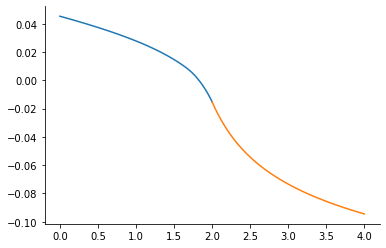

In [394]:
ϕ_bound = np.average(np.exp(-1/ξₘ*ϕ_carb_list), axis=0, weights=dmg_weight)
ϕ_bound = -ξₘ*np.log(ϕ_bound)
plt.plot(y_grid[:numy_bar+1], ϕ_carb)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [395]:
yt_carb, et_carb, πᵈt_carb, πᶜt_carb, ιt_carb, ht_carb = simulate_jump(y_grid[:numy_bar+1], ems_carb, πᶜ_carb, πᵈ_carb, ι_carb, h_carb,  θcarb_list)

Text(0.5, 0, 'years')

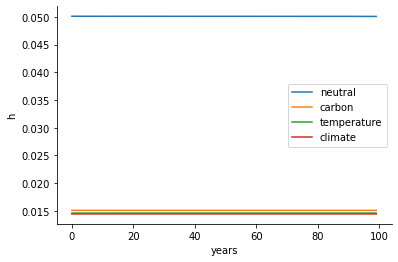

In [396]:
plt.plot(ht[ht>0], label="neutral")
plt.plot(ht_carb[ht_carb>0], label = "carbon")
plt.plot(ht_temp[ht_temp>0], label = "temperature")
plt.plot(ht_avg[ht_avg>0], label = "climate")
plt.legend()
plt.ylabel('h')
plt.xlabel('years')
# plt.ylim(0,0.0035)

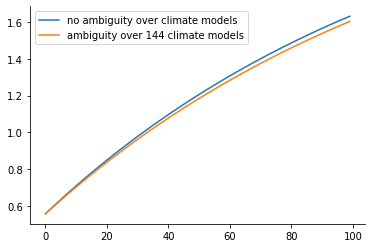

In [397]:
plt.plot(yt[yt>0],label="no ambiguity over climate models")
# plt.plot(yt_carb[yt_carb>0],label="ambiguity over carbon models")
# plt.plot(yt_temp[yt_temp>0],label="ambiguity over temperature models")
plt.plot(yt_avg[yt_avg>0],label="ambiguity over 144 climate models")
plt.legend()

(0.0, 100.0)

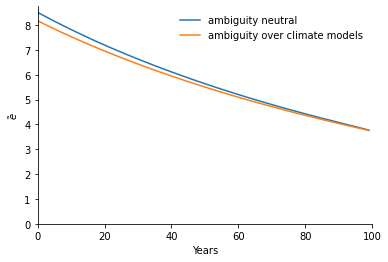

In [398]:
plt.plot(et[et>0], label="ambiguity neutral")
# plt.plot(et_carb[et_carb>0], label="ambiguity over carbon models")
# plt.plot(et_temp[et_temp>0], label="ambiguity over temperature models")
plt.plot(et_avg[et_avg>0], label="ambiguity over climate models")
plt.legend(frameon=False)
plt.ylabel("$\\tilde e$")
plt.xlabel('Years')
plt.ylim(bottom=0)
plt.xlim(0,100)
# plt.savefig("../figures/ems_partition_damage.png", facecolor='w', edgecolor='w',bbox_inches="tight")

## Approach two:
$$
\begin{aligned}
0 = \max_{\tilde e} \min_{g_j: \sum_j g_j \hat \pi_j=1} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta + \mathcal{I}(y)\sum_j\hat\pi_j g_j\left[\phi_j(y) - \phi(y) \right] \\
&  + \xi_m \mathcal{I}(y) \sum_j \hat\pi_j g_j \log g_j
\end{aligned}
$$
Minimize over $g_j$ gives:
$$
g_j = \cfrac{\exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right)}{\sum_{j} \hat\pi_j \exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right)}
$$
Plug back in:
$$
\begin{aligned}
0 = \max_{\tilde e} &- \delta \phi(y) + \delta\eta \log\tilde e \\
& +  \frac{d\phi}{dy} \theta \tilde e  + \frac{1}{2} \frac{d^2 \phi}{dy^2}(\tilde e)^2 |\sigma_y|^2\\
& + (\eta -1)(\gamma_1 + \gamma_2 y) \tilde e \theta  \\
&   - \xi_m \mathcal{I}(y) \log \left(\sum_j \hat\pi_j \exp\left( \frac{1}{\xi_m} [\phi(y) - \phi_j(y)] \right) \right)
\end{aligned}
$$

First order condition for $\tilde e$:
$$
 \frac{d^2 \phi}{dy^2} |\sigma_y|^2 (\tilde e)^2 + [\frac{d\phi(y)}{dy} + (\eta -1)(\gamma_1 + \gamma_2 y)]\theta \tilde e + \delta \eta = 0
$$

In [ ]:
y_grid_cap = y_grid[:numy_bar+1]

In [ ]:
# solve for approach 2
ς = 1/10
ξₘ = 0.1
dmg_weight = np.array([0.5, 0.5])
dΛ = γ1 + γ2*y_grid_cap
ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)
tol = 1e-8
ϕ = - δ*η*y_grid_cap**2
dy = y_grid_cap[1] - y_grid_cap[0]
ems = δ*η
ems_old = ems
episode = 0
ϵ = .3
lhs_error = 1
πo = np.ones(len(γ3_list))/len(γ3_list)
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    # update control
    temp = dϕdy + (η-1)*dΛ
    a = dϕdyy*σy**2  
    b = temp*θ
    c = δ*η
    Δ = b**2 - 4*a*c
    Δ[Δ < 0] = 0
    root1 = (-b - np.sqrt(Δ))/(2*a)
    root2 = (-b + np.sqrt(Δ))/(2*a)
    if root1.all() > 0:
        ems_new = root1
    else:
        ems_new = root2
    ems_new[ems_new < 1e-15] = 1e-15
    ems = ems_new*1 + ems_old*0.
    inside = np.array([πo[i]*np.exp(1/ξₘ*(ϕ - ϕ_list[i][:numy_bar+1])) for i in range(len(γ3_list))])
    sum_inside = np.sum(inside, axis=0)
    # coefficients
    A = -δ*np.ones(y_grid_cap.shape)
    By = θ*ems
    Cyy = ems**2*σy**2/2
    D = δ*η*np.log(ems) + (η-1)*dΛ*θ*ems - ξₘ*get_intensity(y_grid_cap,ς)*np.log(sum_inside)
    # solver
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ, (True, ϕ_bound[numy_bar]))
    rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    ems_old = ems
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

In [ ]:
plt.plot(y_grid_cap, ϕ)
plt.plot(y_grid[numy_bar:], ϕ_bound[numy_bar:])

In [ ]:
plt.plot(ems)